# Estimating a regional field
Here we will present the 4 methods we provide for estimating the regional component of gravity misfit.

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import os

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Get data

Here we will load a commonly used synthetic gravity and basement topography model. It includes topography of the Moho and the crystalline basement. The gravity effect from the Moho will represent the **regional** which we are aiming to isolate. We will forward model the gravity effects of both layers, and add some noise, to create an observed gravity dataset. We will then use a series of point where we know the basement topography to create a starting model, forward calculate its gravity effect, and remove it from the observed gravity to get a gravity misfit. We will then demonstrate the range of techniques implemented within *Invert4Geom* for isolated the regional component of this gravity misfit.

In [2]:
# get topography data
grid = invert4geom.load_bishop_model(coarsen_factor=20)

# extract grid spacing and region
spacing, buffer_region, _, _, _ = polar_utils.get_grid_info(
    grid.basement_topo, print_info=True
)

# get topography data
basement_topo = grid.basement_topo.to_dataset(name="upward")
moho_topo = grid.moho_topo.to_dataset(name="upward")

# create an inside region to reduce gravity edge effects
region = vd.pad_region(buffer_region, -spacing * 5)
region

grid spacing: 4000.0 m
grid region: (3900.0, 379900.0, 142900.0, 538900.0)
grid zmin: -9349.98535156
grid zmax: -276.429992676
grid registration: g


(23900.0, 359900.0, 162900.0, 518900.0)

In [3]:
basement_model = invert4geom.create_model(
    zref=basement_topo.upward.to_numpy().mean(),
    density_contrast=2800 - 2500,
    starting_topography=basement_topo,
)
moho_model = invert4geom.create_model(
    zref=moho_topo.upward.to_numpy().mean(),
    density_contrast=3300 - 2800,
    starting_topography=moho_topo,
)

## Prism layers

Create prism layers from the Moho and basement surfaces.

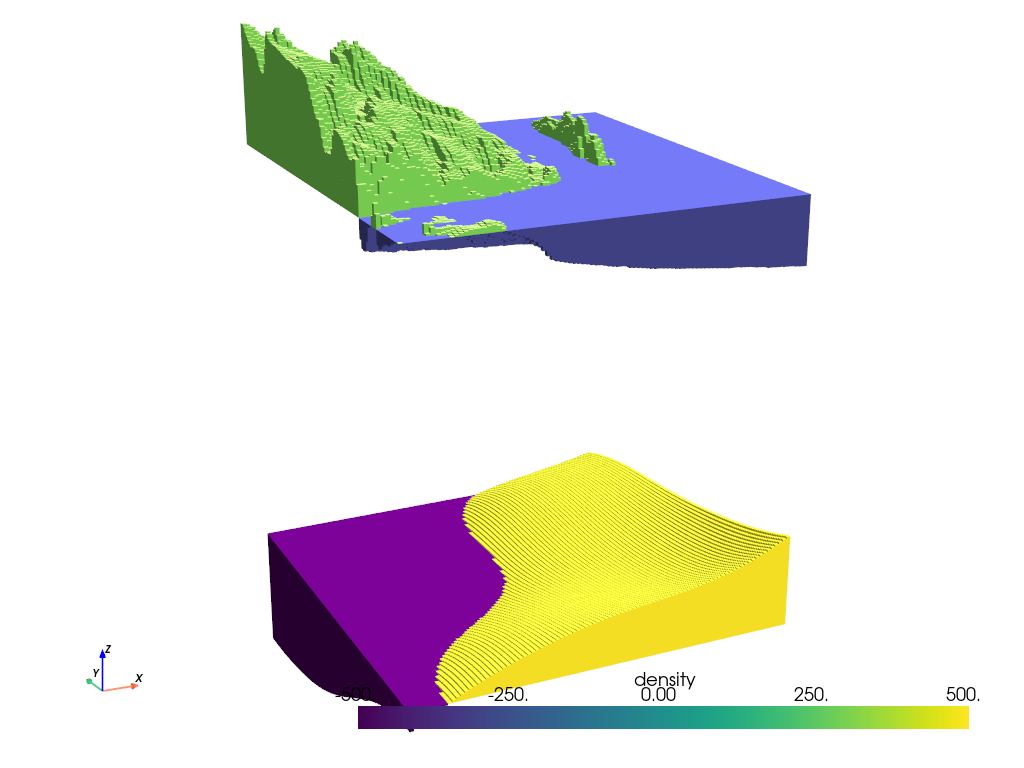

In [4]:
invert4geom.show_prism_layers(
    [basement_model, moho_model],
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

## Forward gravity of prism layers

Calculate the gravity effect of each of these prism layers

In [5]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

In [6]:
data = invert4geom.create_data(observations)

print(f"Gravity region (W,E,S,N): {data.region}")
print(f"Gravity spacing: {data.spacing} m")
data

Gravity region (W,E,S,N): (23900.0, 359900.0, 162900.0, 518900.0)
Gravity spacing: 4000.0 m


<xarray.Dataset> Size: 63kB
Dimensions:   (northing: 90, easting: 85)
Coordinates:
  * easting   (easting) float64 680B 2.39e+04 2.79e+04 ... 3.559e+05 3.599e+05
  * northing  (northing) float64 720B 1.629e+05 1.669e+05 ... 5.189e+05
Data variables:
    upward    (northing, easting) float64 61kB 1e+03 1e+03 1e+03 ... 1e+03 1e+03
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data

In [7]:
data.inv.forward_gravity(basement_model, name="basement_grav")
data.inv.forward_gravity(moho_model, name="moho_grav")
data

<xarray.Dataset> Size: 185kB
Dimensions:        (northing: 90, easting: 85)
Coordinates:
  * easting        (easting) float64 680B 2.39e+04 2.79e+04 ... 3.599e+05
  * northing       (northing) float64 720B 1.629e+05 1.669e+05 ... 5.189e+05
Data variables:
    upward         (northing, easting) float64 61kB 1e+03 1e+03 ... 1e+03 1e+03
    basement_grav  (northing, easting) float64 61kB -2.757 -2.269 ... -16.32
    moho_grav      (northing, easting) float64 61kB -3.04 -2.545 ... 15.05 14.69
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data

In [8]:
# add offset to the moho gravity
data["moho_grav"] += 100

data["gravity_anomaly_no_noise"] = data.basement_grav + data.moho_grav

In [9]:
# contaminate gravity with 2 mGal of random noise
data["gravity_anomaly"], stddev = invert4geom.contaminate(
    data.gravity_anomaly_no_noise,
    stddev=2,
    percent=False,
    seed=0,
)
data["uncert"] = xr.full_like(data.gravity_anomaly, stddev)
data

<xarray.Dataset> Size: 369kB
Dimensions:                   (northing: 90, easting: 85)
Coordinates:
  * easting                   (easting) float64 680B 2.39e+04 ... 3.599e+05
  * northing                  (northing) float64 720B 1.629e+05 ... 5.189e+05
Data variables:
    upward                    (northing, easting) float64 61kB 1e+03 ... 1e+03
    basement_grav             (northing, easting) float64 61kB -2.757 ... -16.32
    moho_grav                 (northing, easting) float64 61kB 96.96 ... 114.7
    gravity_anomaly_no_noise  (northing, easting) float64 61kB 94.2 ... 98.37
    gravity_anomaly           (northing, easting) float64 61kB 94.46 ... 98.23
    uncert                    (northing, easting) float64 61kB 2.0 2.0 ... 2.0
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data

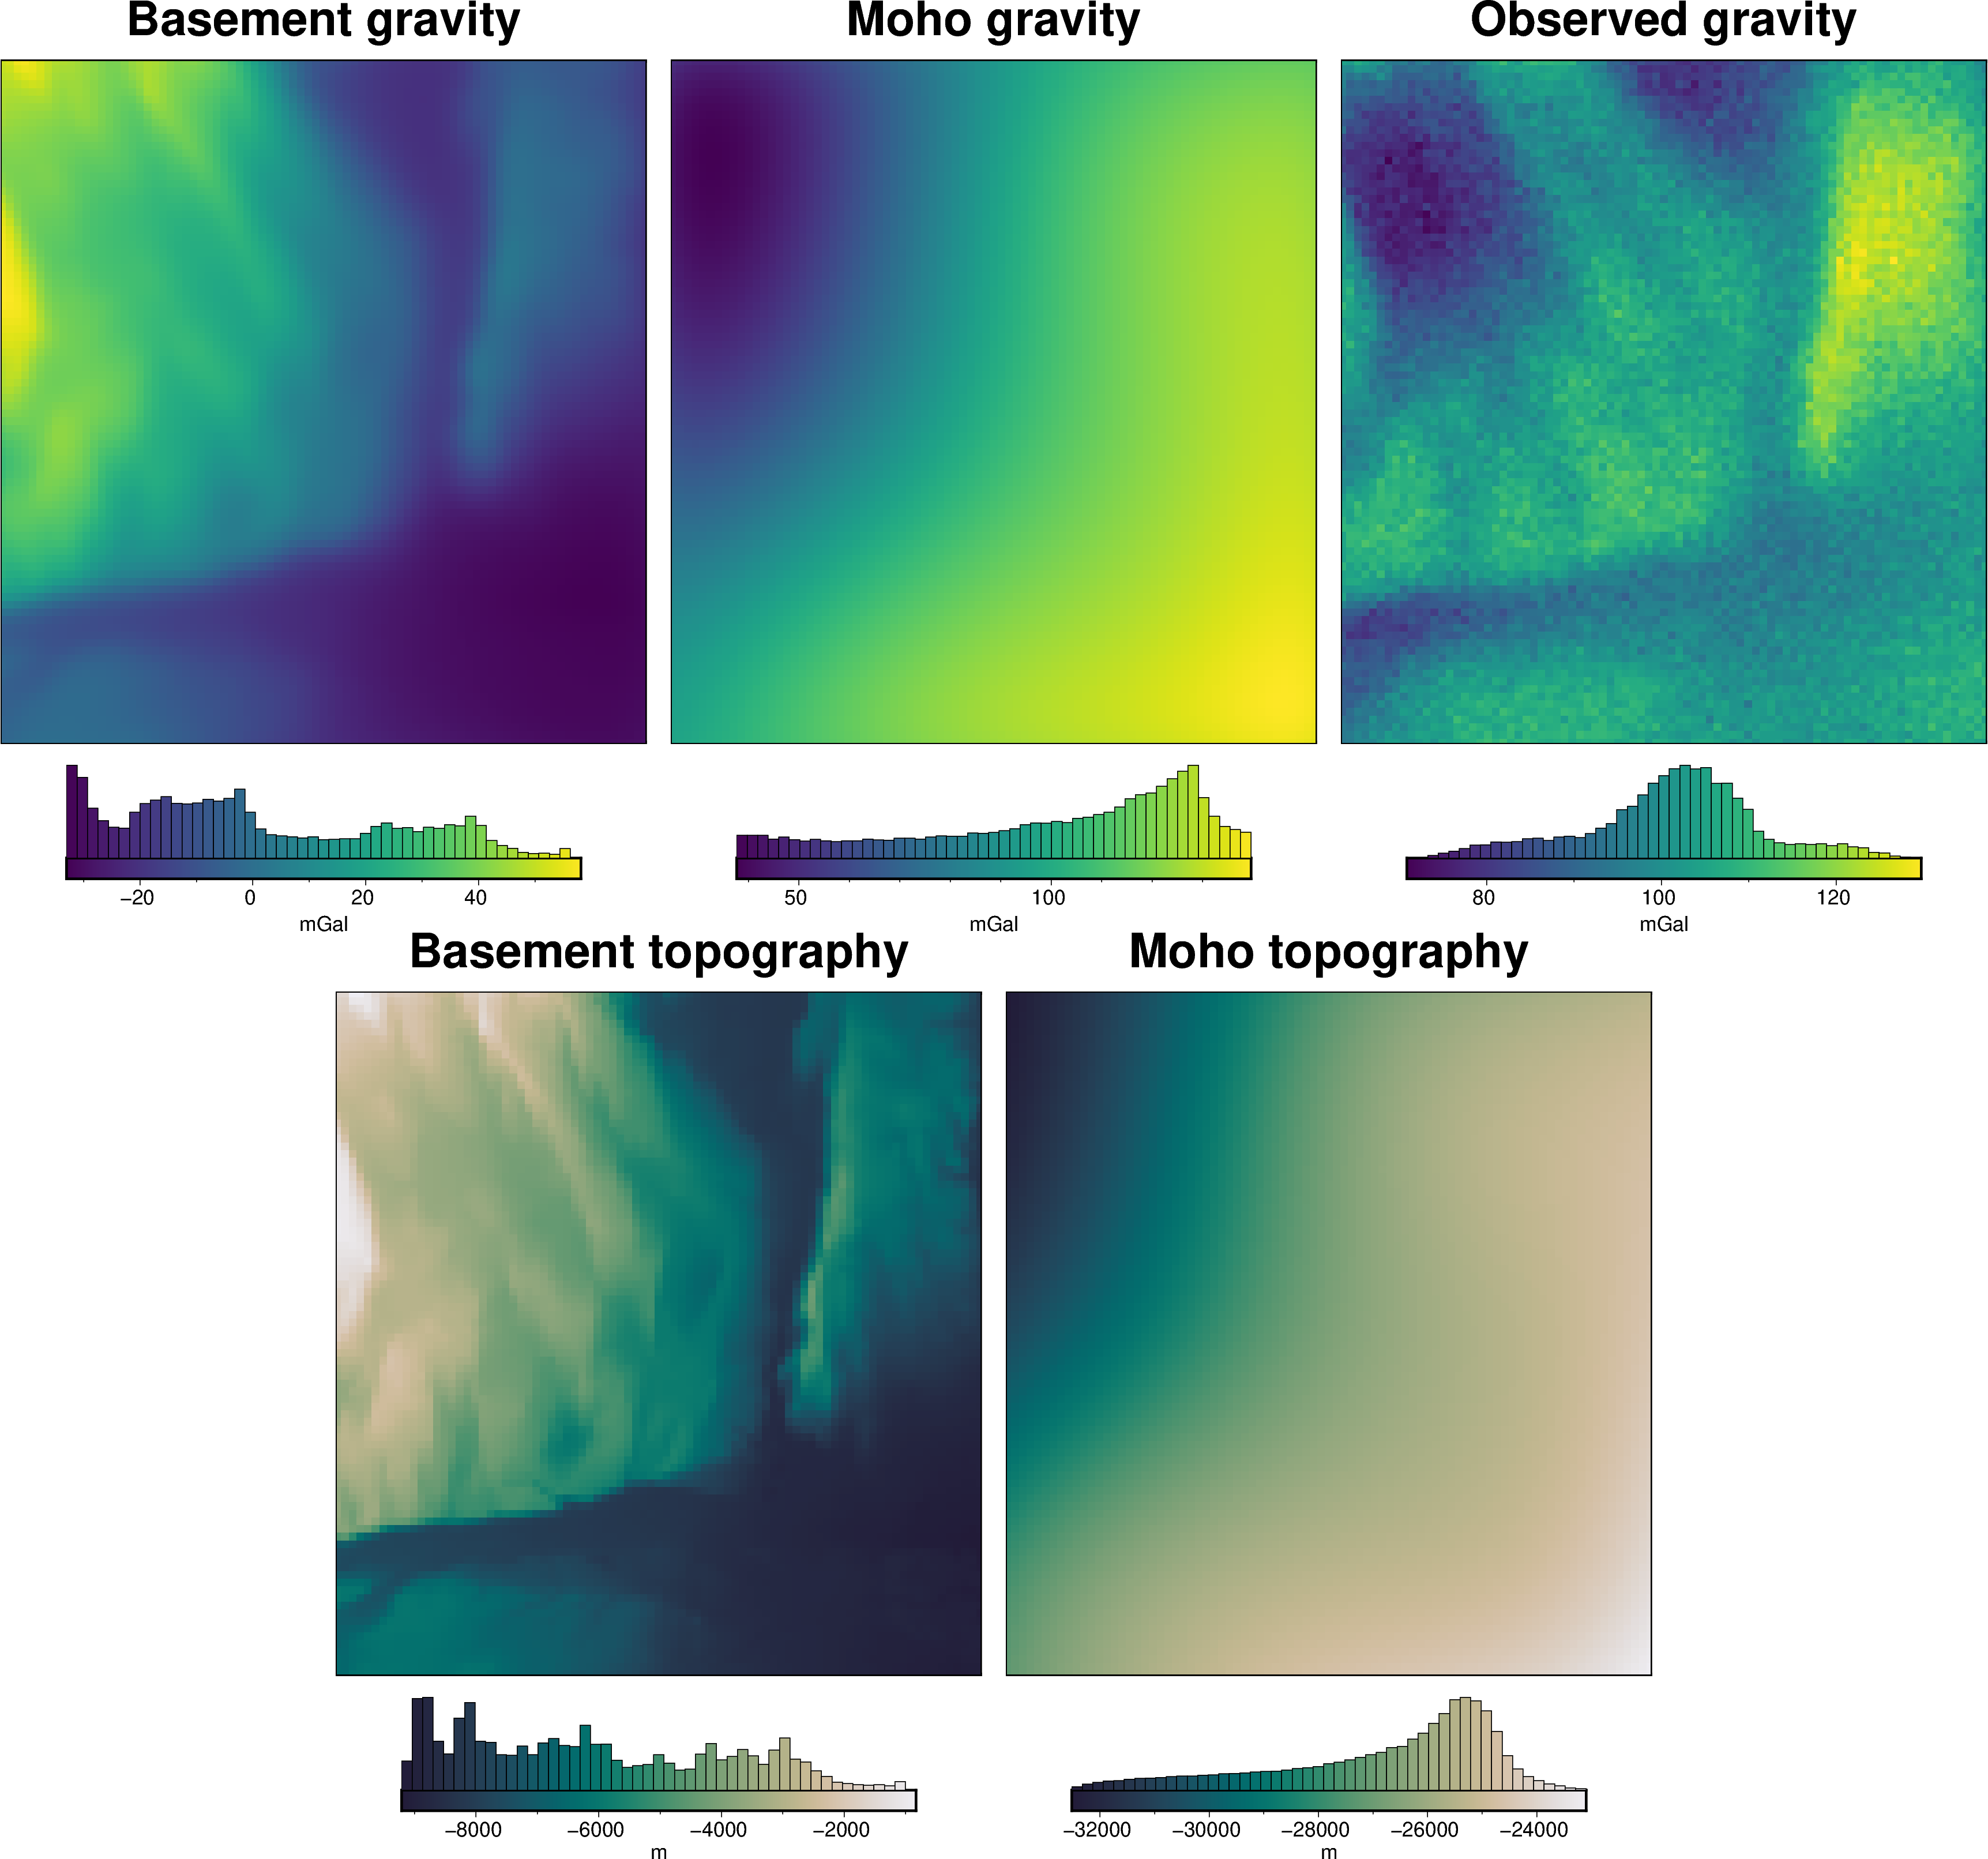

In [10]:
fig = maps.plot_grd(
    basement_model.topography,
    region=region,
    fig_height=10,
    title="Basement topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    moho_model.topography,
    region=region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Moho topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    data.basement_grav,
    region=region,
    fig=fig,
    origin_shift="both",
    xshift_amount=-1.5,
    yshift_amount=1.2,
    fig_height=10,
    title="Basement gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    data.moho_grav,
    region=region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Moho gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    data.gravity_anomaly,
    region=region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig.show()

## Create "a-priori" basement measurements
These points represent locations where we know the basement elevation, for example from drill holes, seismic surveys, or outcropping basement.

In [11]:
# create 10 random point within the outcropping basement region
num_constraints = 15
coords = vd.scatter_points(
    region=region,
    size=num_constraints,
    random_state=22,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    basement_topo.upward,
    "true_upward",
)

constraint_points["upward"] = constraint_points.true_upward

# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 2% of depth
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points = invert4geom.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.uncert**2)

constraint_points.head()

easting       northing  true_upward       upward      uncert  \
0   93942.740553  165086.148419 -6166.691339 -6151.184549  123.333827   
1  185744.836752  437747.618234 -5230.910817 -5244.731393  104.618216   
2  165200.779866  503888.251841 -4551.466895 -4493.169645   91.029338   
3  312585.151503  412789.886738 -6178.090981 -6165.129332  123.561820   
4   81410.282014  268837.863004 -4562.000830 -4610.875312   91.240017   

     weight  
0  0.000066  
1  0.000091  
2  0.000121  
3  0.000065  
4  0.000120

## Create starting basement model

Here we interpolate the *a-priori* point measurements to create a starting model of basement topography. We then use this to create a starting prism model.

In [12]:
# grid the sampled values using verde
starting_topography = invert4geom.create_topography(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=[*list(np.logspace(-60, 0, 100)), None],
    weights=constraint_points.weight,
).to_dataset(name="upward")

In [13]:
model = invert4geom.create_model(
    zref=basement_topo.upward.to_numpy().mean(),
    density_contrast=2800 - 2500,
    starting_topography=starting_topography,
)

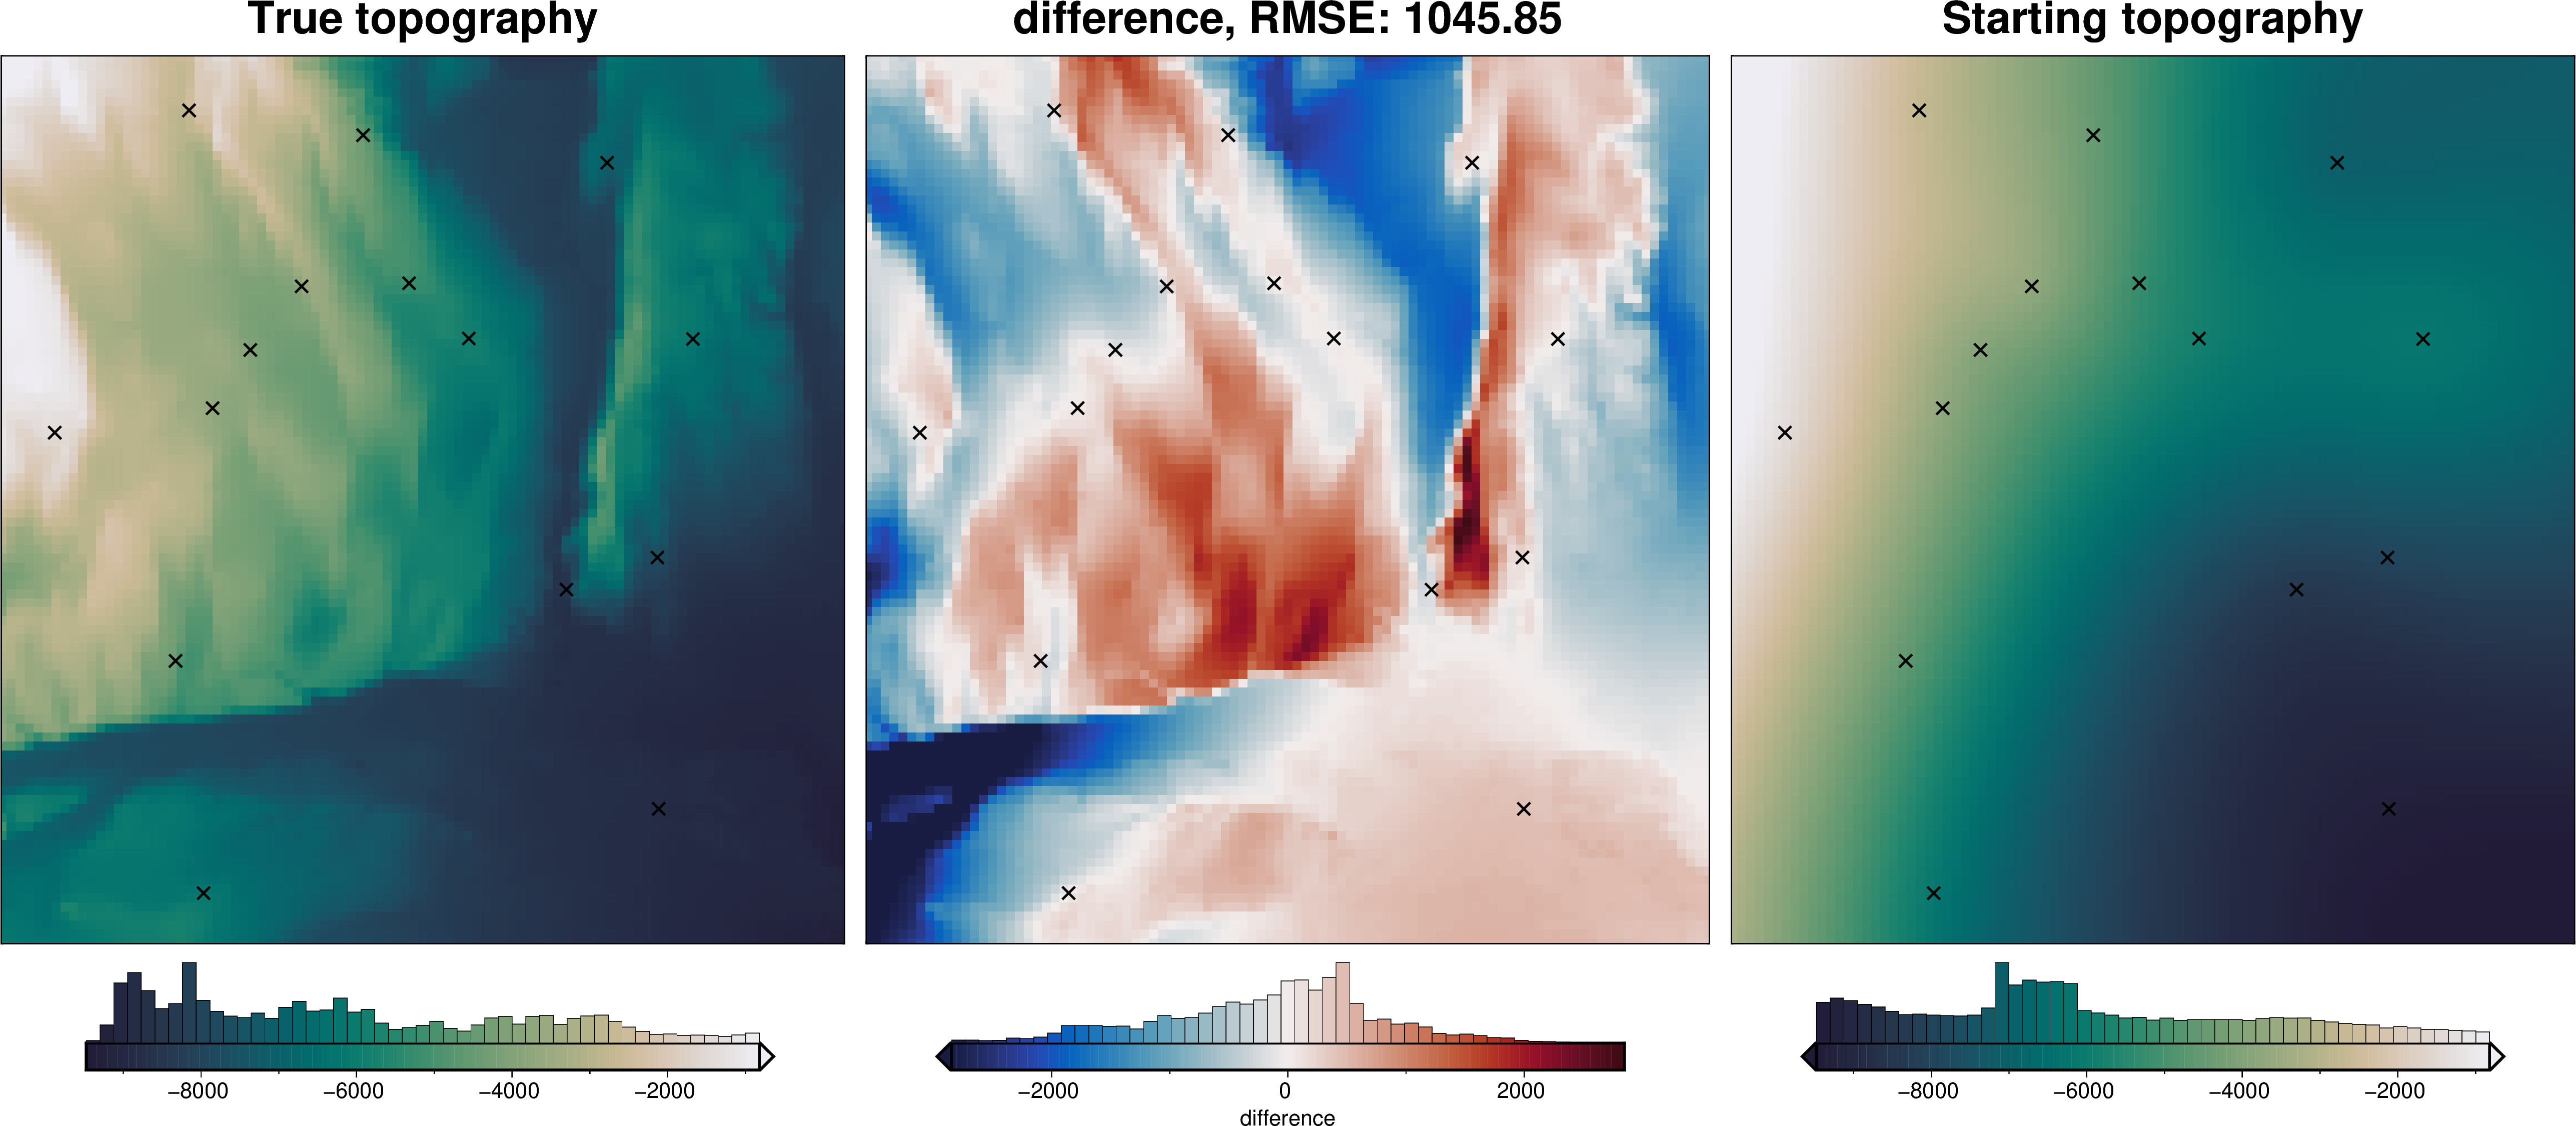

In [14]:
_ = polar_utils.grd_compare(
    basement_topo.upward,
    starting_topography.upward,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

## Gravity misfit

All inversions in Invert4Geom are based on a gravity misfit, not a gravity anomaly. This means before the inversion, we must create a starting prism model, forward model it's gravity effect, remove it from the gravity anomaly, and get a gravity misfit. 

### Forward gravity of starting prism layer

In [15]:
data.inv.starting_gravity(model)

# calculate the true residual misfit
# true misfit is difference between noise-free gravity and starting gravity
# true regional misfit is the moho gravity
# so true residual is misfit - true_regional
data["true_res"] = (
    data.gravity_anomaly_no_noise - data.starting_gravity - data.moho_grav
)

data

<xarray.Dataset> Size: 552kB
Dimensions:                   (northing: 90, easting: 85)
Coordinates:
  * easting                   (easting) float64 680B 2.39e+04 ... 3.599e+05
  * northing                  (northing) float64 720B 1.629e+05 ... 5.189e+05
Data variables:
    upward                    (northing, easting) float64 61kB 1e+03 ... 1e+03
    basement_grav             (northing, easting) float64 61kB -2.757 ... -16.32
    moho_grav                 (northing, easting) float64 61kB 96.96 ... 114.7
    gravity_anomaly_no_noise  (northing, easting) float64 61kB 94.2 ... 98.37
    gravity_anomaly           (northing, easting) float64 61kB 94.46 ... 98.23
    uncert                    (northing, easting) float64 61kB 2.0 2.0 ... 2.0
    starting_gravity          (northing, easting) float64 61kB 23.65 ... -10.12
    forward_gravity           (northing, easting) float64 61kB 23.65 ... -10.12
    true_res                  (northing, easting) float64 61kB -26.4 ... -6.2
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data

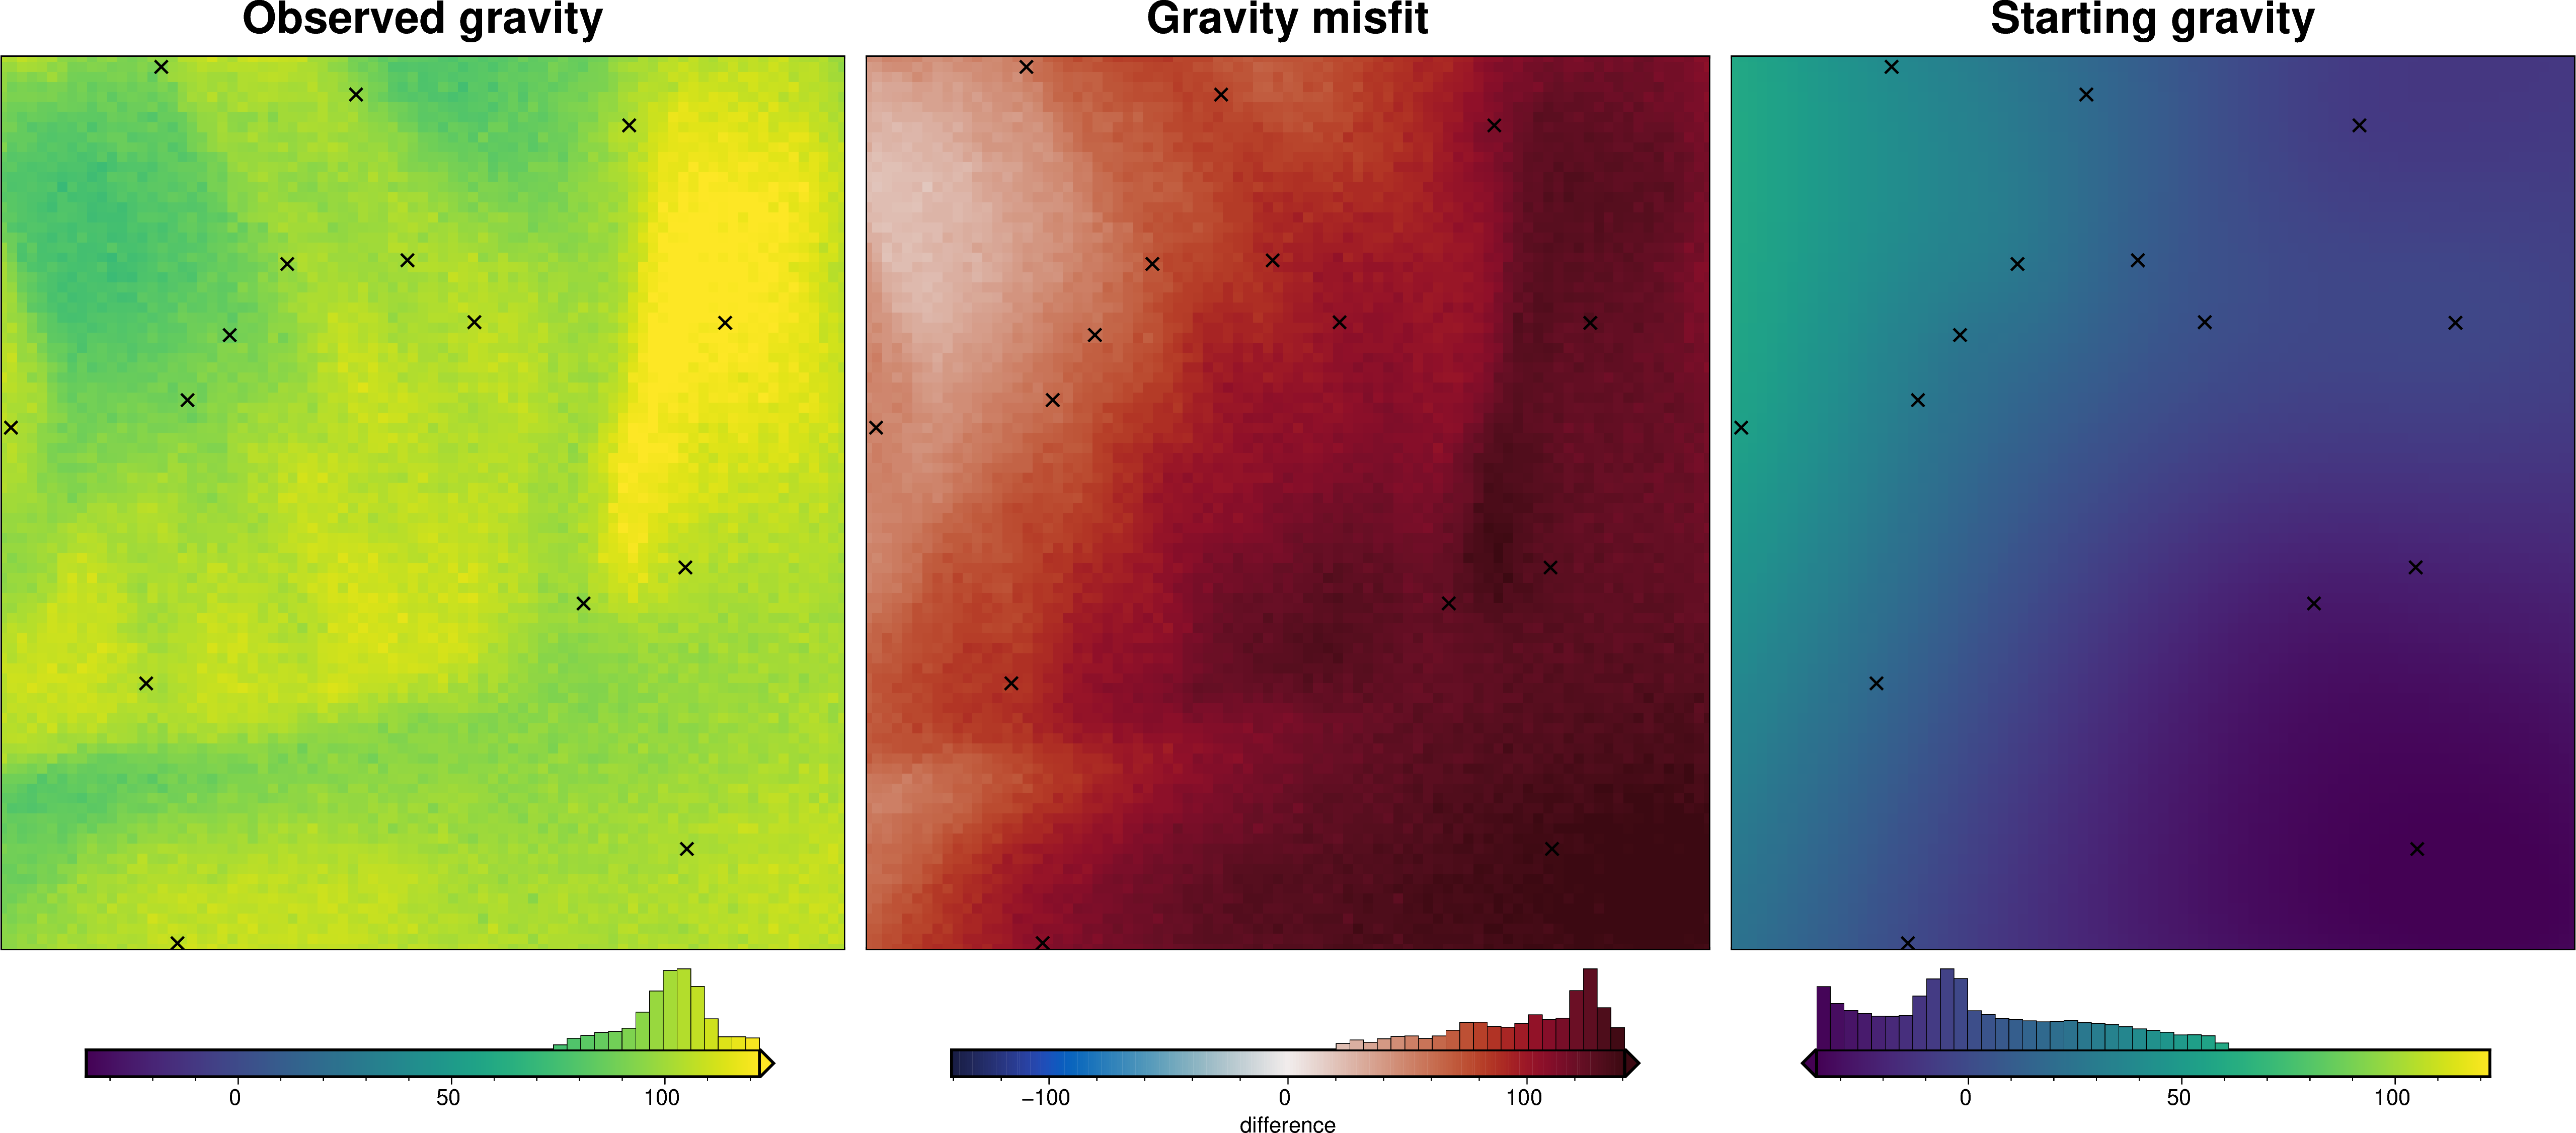

In [16]:
_ = polar_utils.grd_compare(
    data.gravity_anomaly,
    data.starting_gravity,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    title="Gravity misfit",
    rmse_in_title=False,
    grounding_line=False,
    points=constraint_points,
    points_style="x.3c",
)

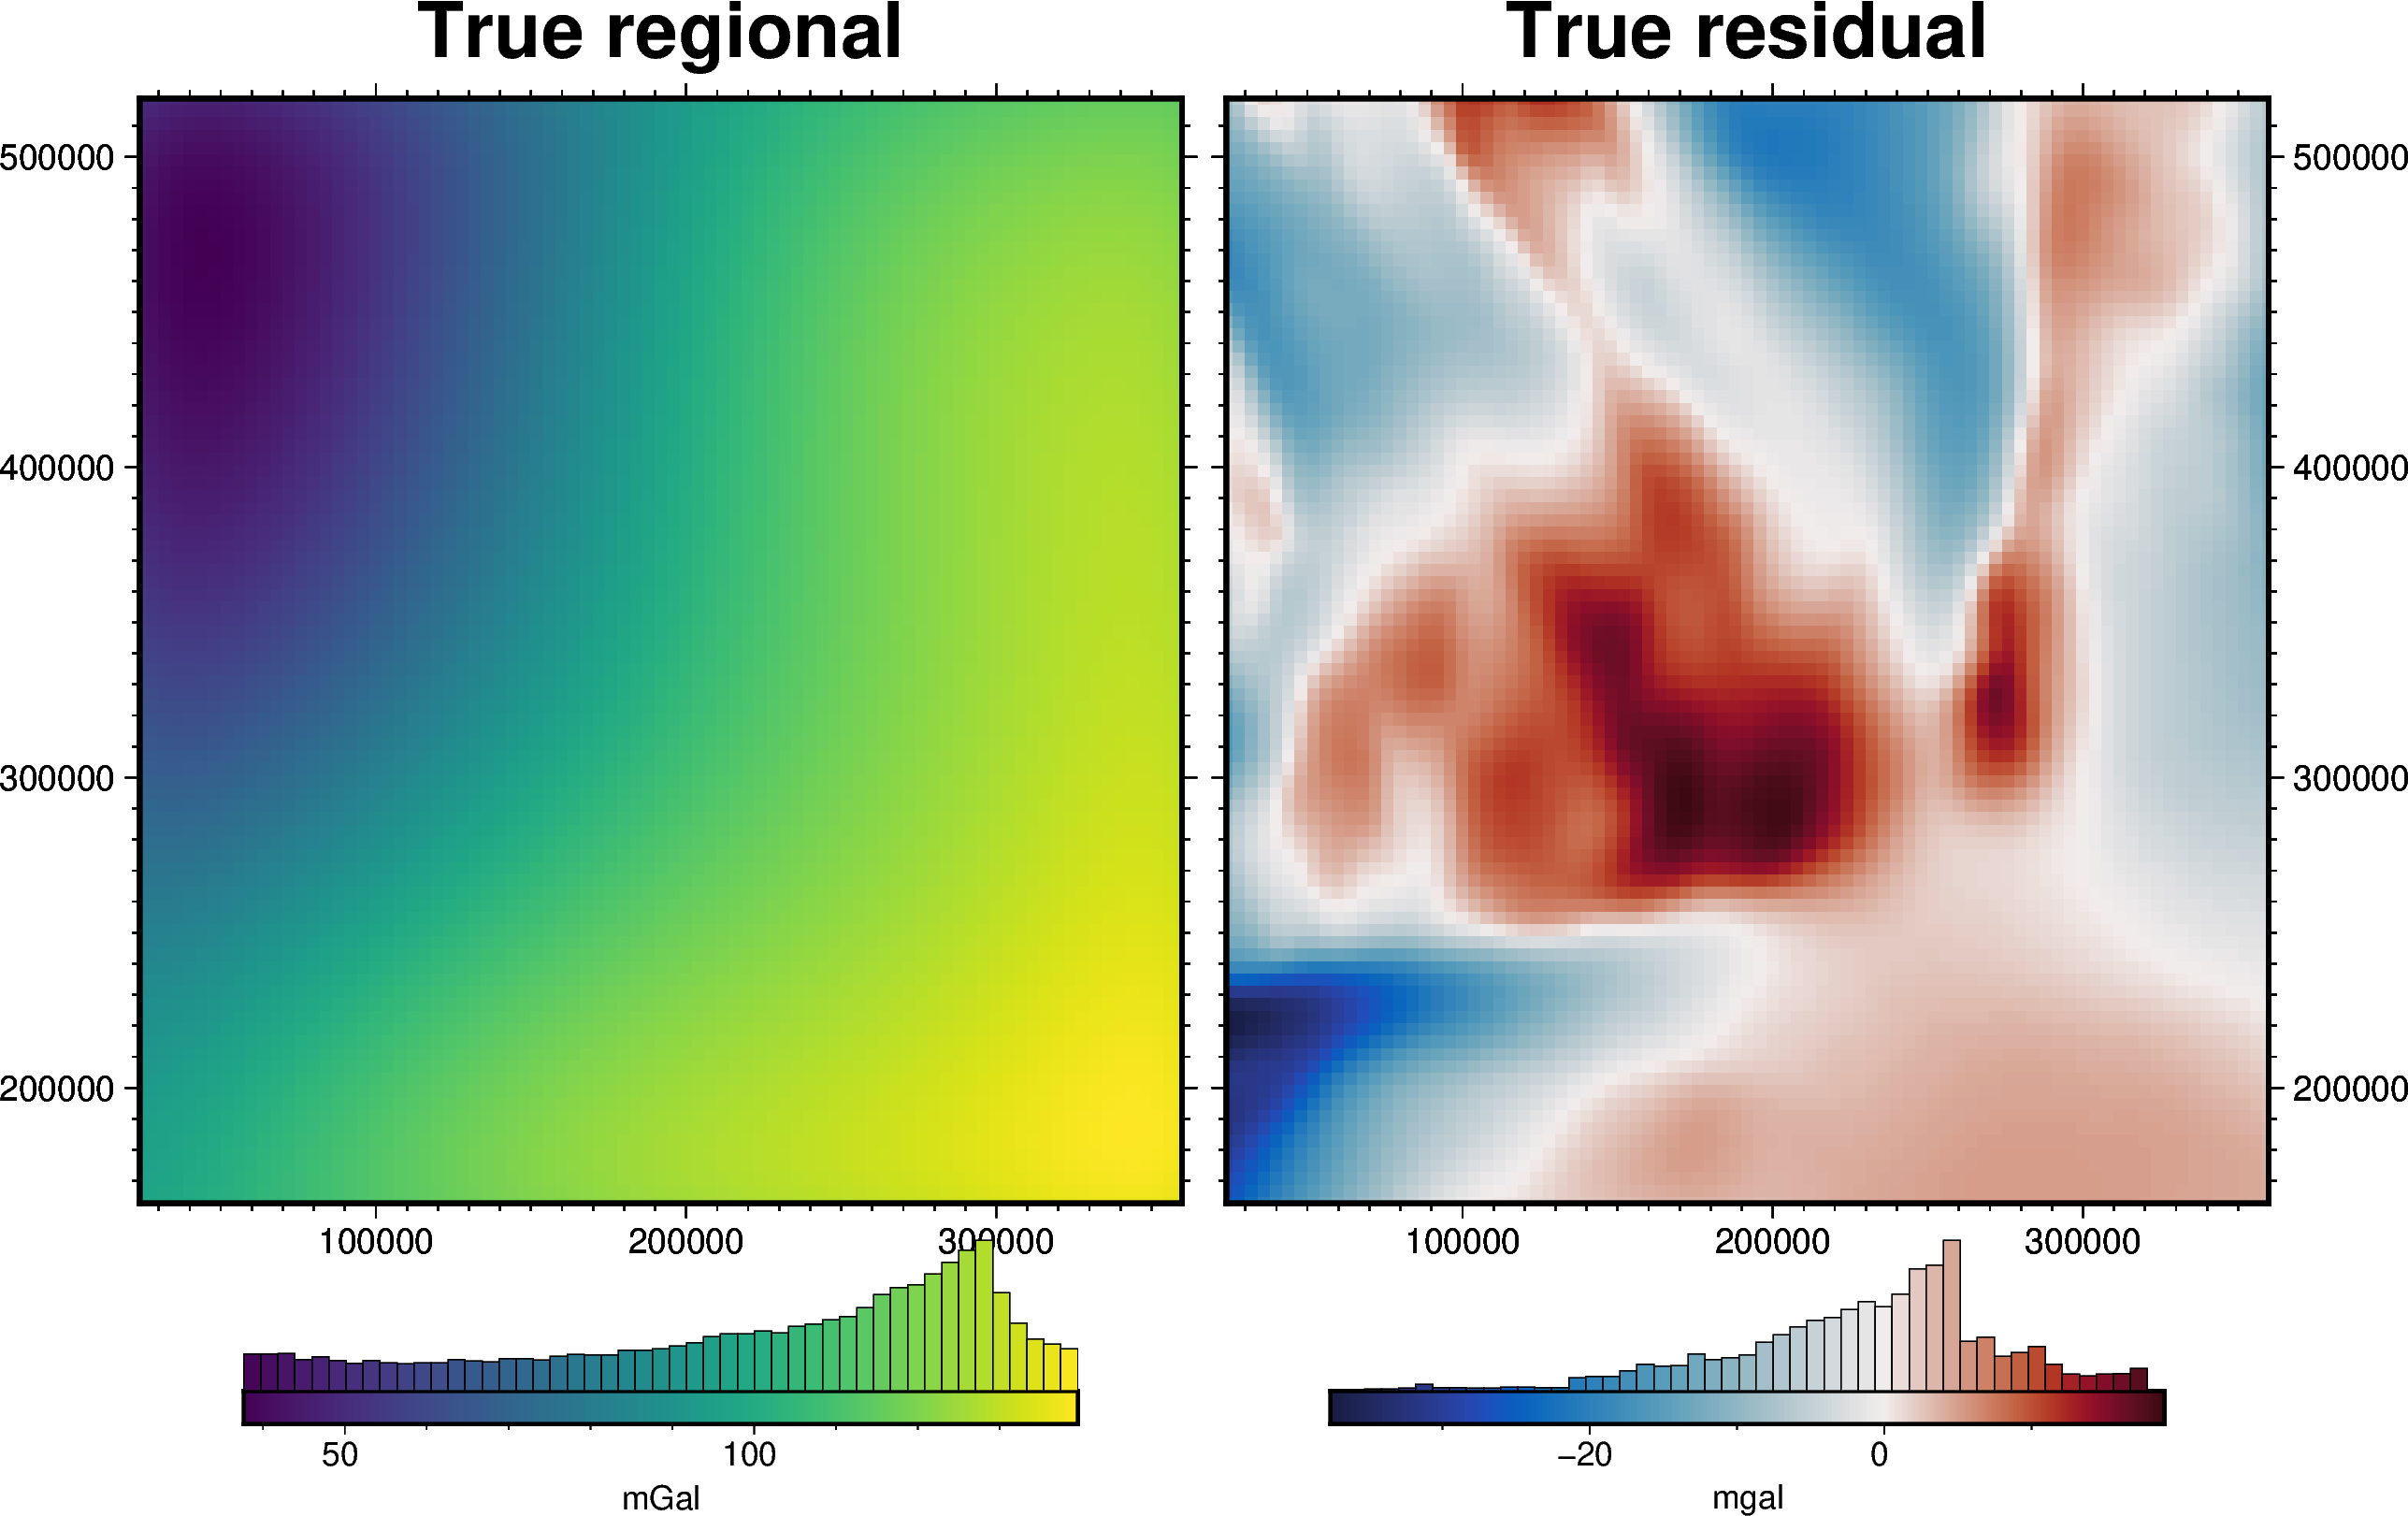

In [17]:
fig = maps.plot_grd(
    data.moho_grav,
    fig_height=10,
    title="True regional",
    cbar_label="mGal",
    hist=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    data.true_res,
    fig=fig,
    cmap="balance+h0",
    origin_shift="x",
    fig_height=10,
    title="True residual",
    cbar_label="mgal",
    hist=True,
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## True-Estimated regional plotting function

In [18]:
def regional_comparison(data, regional_column):
    # compare with true regional
    _ = polar_utils.grd_compare(
        data.moho_grav,
        data[regional_column],
        robust=True,
        grid1_name="True regional field",
        grid2_name="Estimated regional field",
        hist=True,
        inset=False,
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
    )
    # compare with true residual
    _ = polar_utils.grd_compare(
        data.true_res,
        data.res,
        cmap="balance+h0",
        robust=True,
        grid1_name="True residual field",
        grid2_name="Estimated residual field",
        hist=True,
        inset=False,
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
    )

## Save data so other notebooks can use it later


In [ ]:
# save gravity dataframe
data.to_netcdf("../tmp/regional_sep_grav.nc")

# save constraint points
constraint_points.to_csv("../tmp/regional_sep_constraint_points.csv")

# merge and save grids
ds = xr.merge(
    [
        basement_topo.upward.rename("basement"),
        moho_topo.upward.rename("moho"),
        starting_topography.upward.rename("starting"),
    ]
)
ds.drop_attrs().to_netcdf("../tmp/regional_sep_grids.nc")

## Regional estimation methods

Now that we have a gravity misfit (difference between the true observed gravity and the forward calculated gravity from our knowledge of the topography), we can try and separate out the portion of the misfit not related to our lack of understanding of the topography. This is the **regional misfit** and in this case is resulting from our lower layer of prisms.

There are 4 main techniques: a **constant** value for the regional field, **filtering** the misfit to get the regional, fitting a polynomial **trend** to the misfit to get the regional, calculating the long-wavelength component of the misfit using the **equivalent sources** method, and finding a regional field by using point of known elevation for the layer of interest (**constraint point minimization**).

In [20]:
data

<xarray.Dataset> Size: 552kB
Dimensions:                   (northing: 90, easting: 85)
Coordinates:
  * easting                   (easting) float64 680B 2.39e+04 ... 3.599e+05
  * northing                  (northing) float64 720B 1.629e+05 ... 5.189e+05
Data variables:
    upward                    (northing, easting) float64 61kB 1e+03 ... 1e+03
    basement_grav             (northing, easting) float64 61kB -2.757 ... -16.32
    moho_grav                 (northing, easting) float64 61kB 96.96 ... 114.7
    gravity_anomaly_no_noise  (northing, easting) float64 61kB 94.2 ... 98.37
    gravity_anomaly           (northing, easting) float64 61kB 94.46 ... 98.23
    uncert                    (northing, easting) float64 61kB 2.0 2.0 ... 2.0
    starting_gravity          (northing, easting) float64 61kB 23.65 ... -10.12
    forward_gravity           (northing, easting) float64 61kB 23.65 ... -10.12
    true_res                  (northing, easting) float64 61kB -26.4 ... -6.2
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data

### Constant value

#### 1) Constant value equal to average value of gravity misfit at constraint points

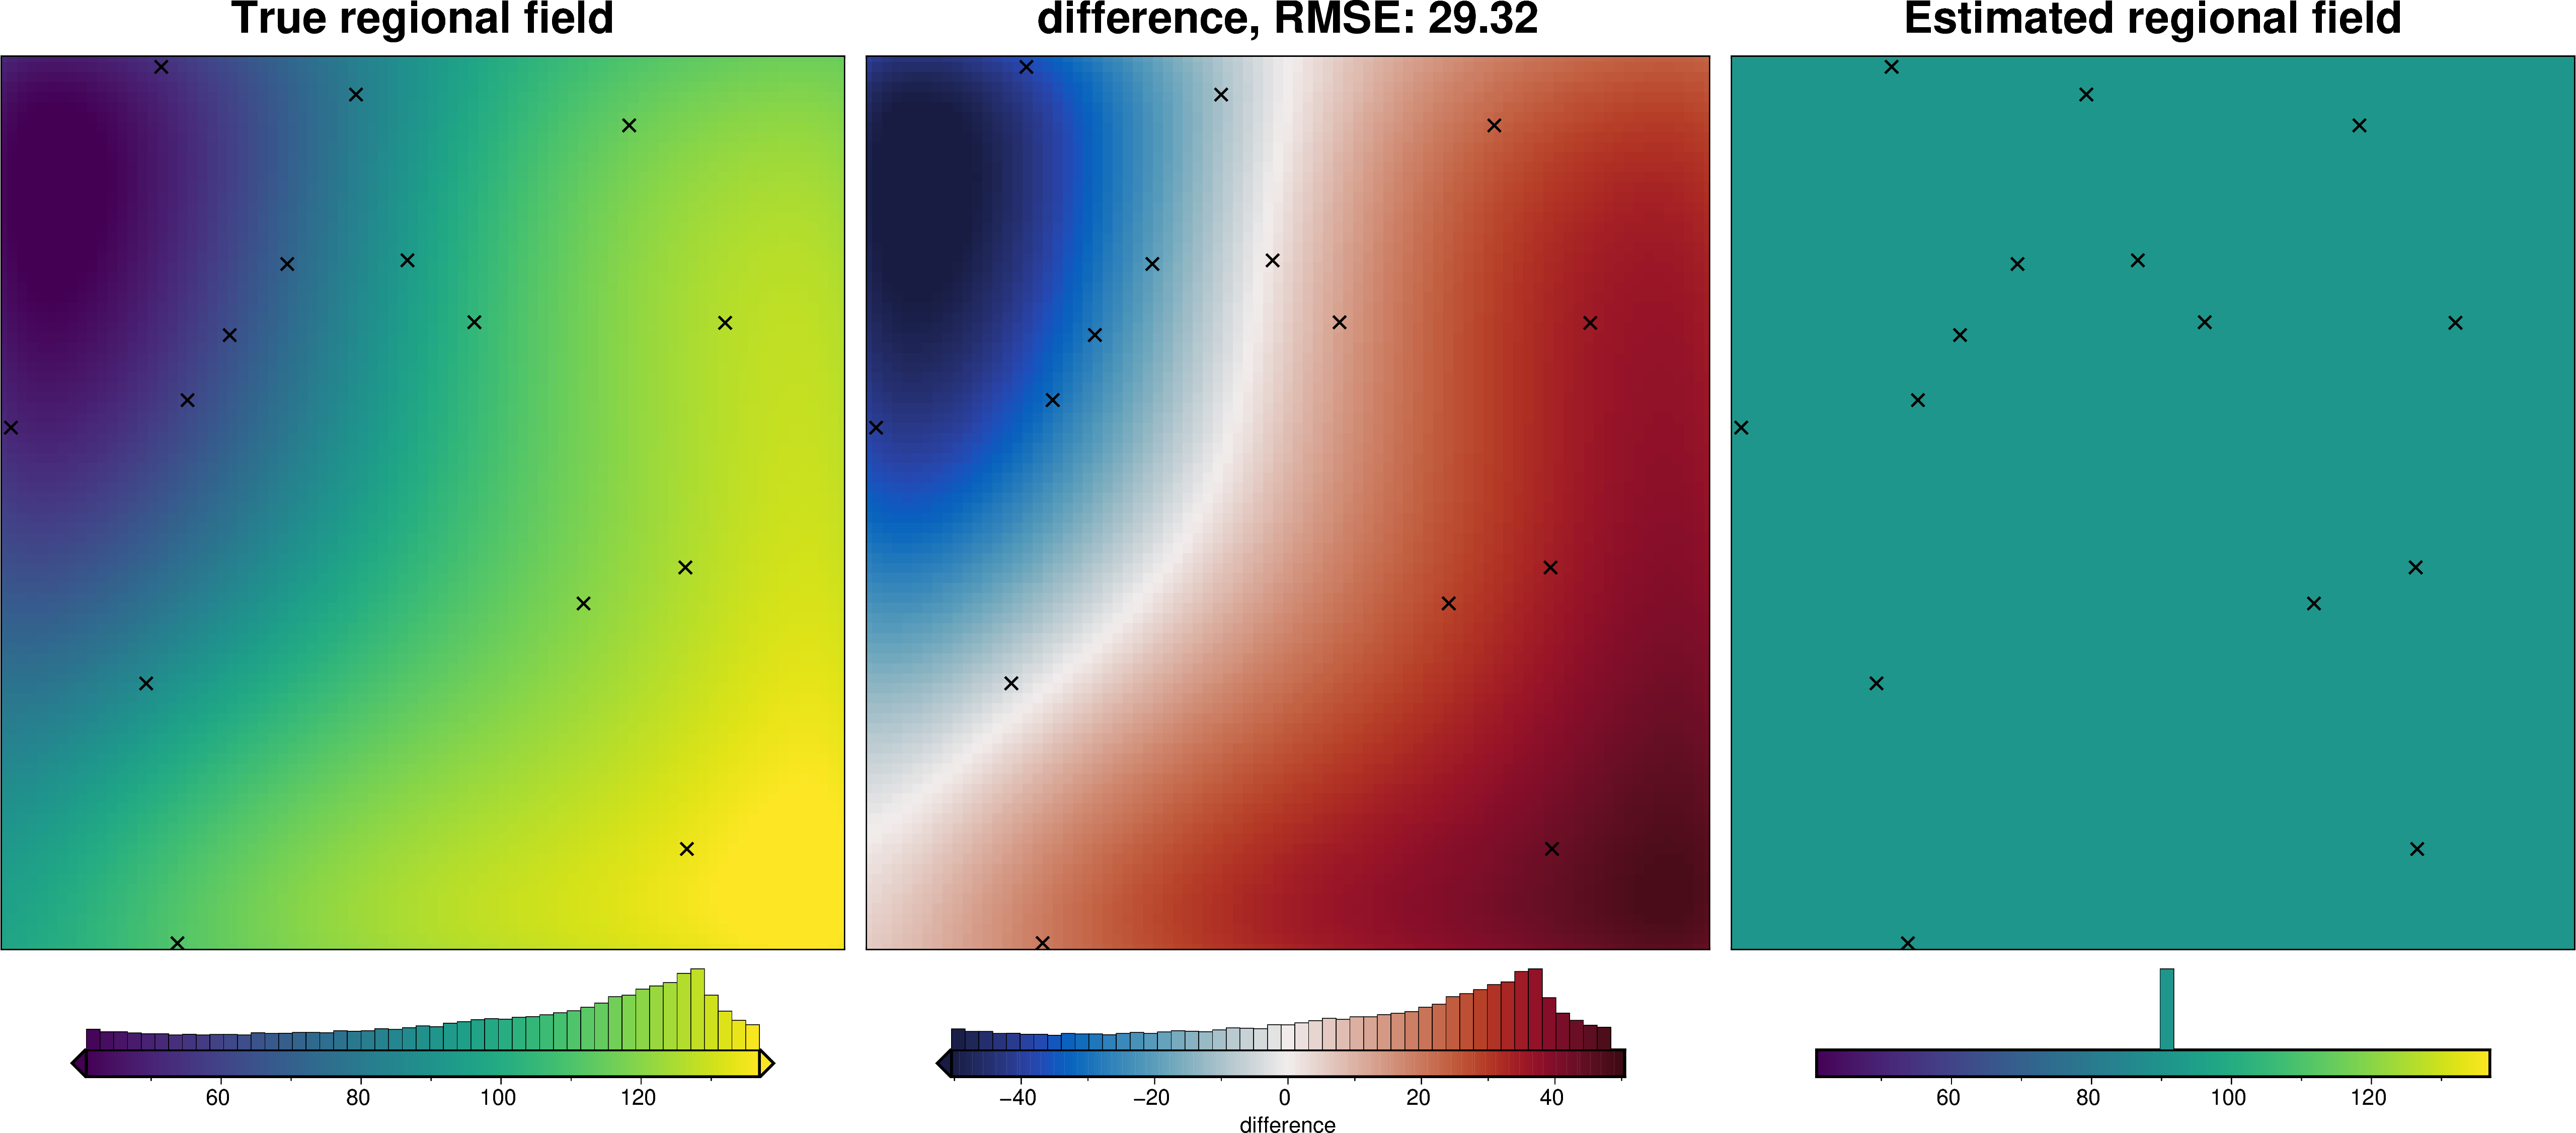

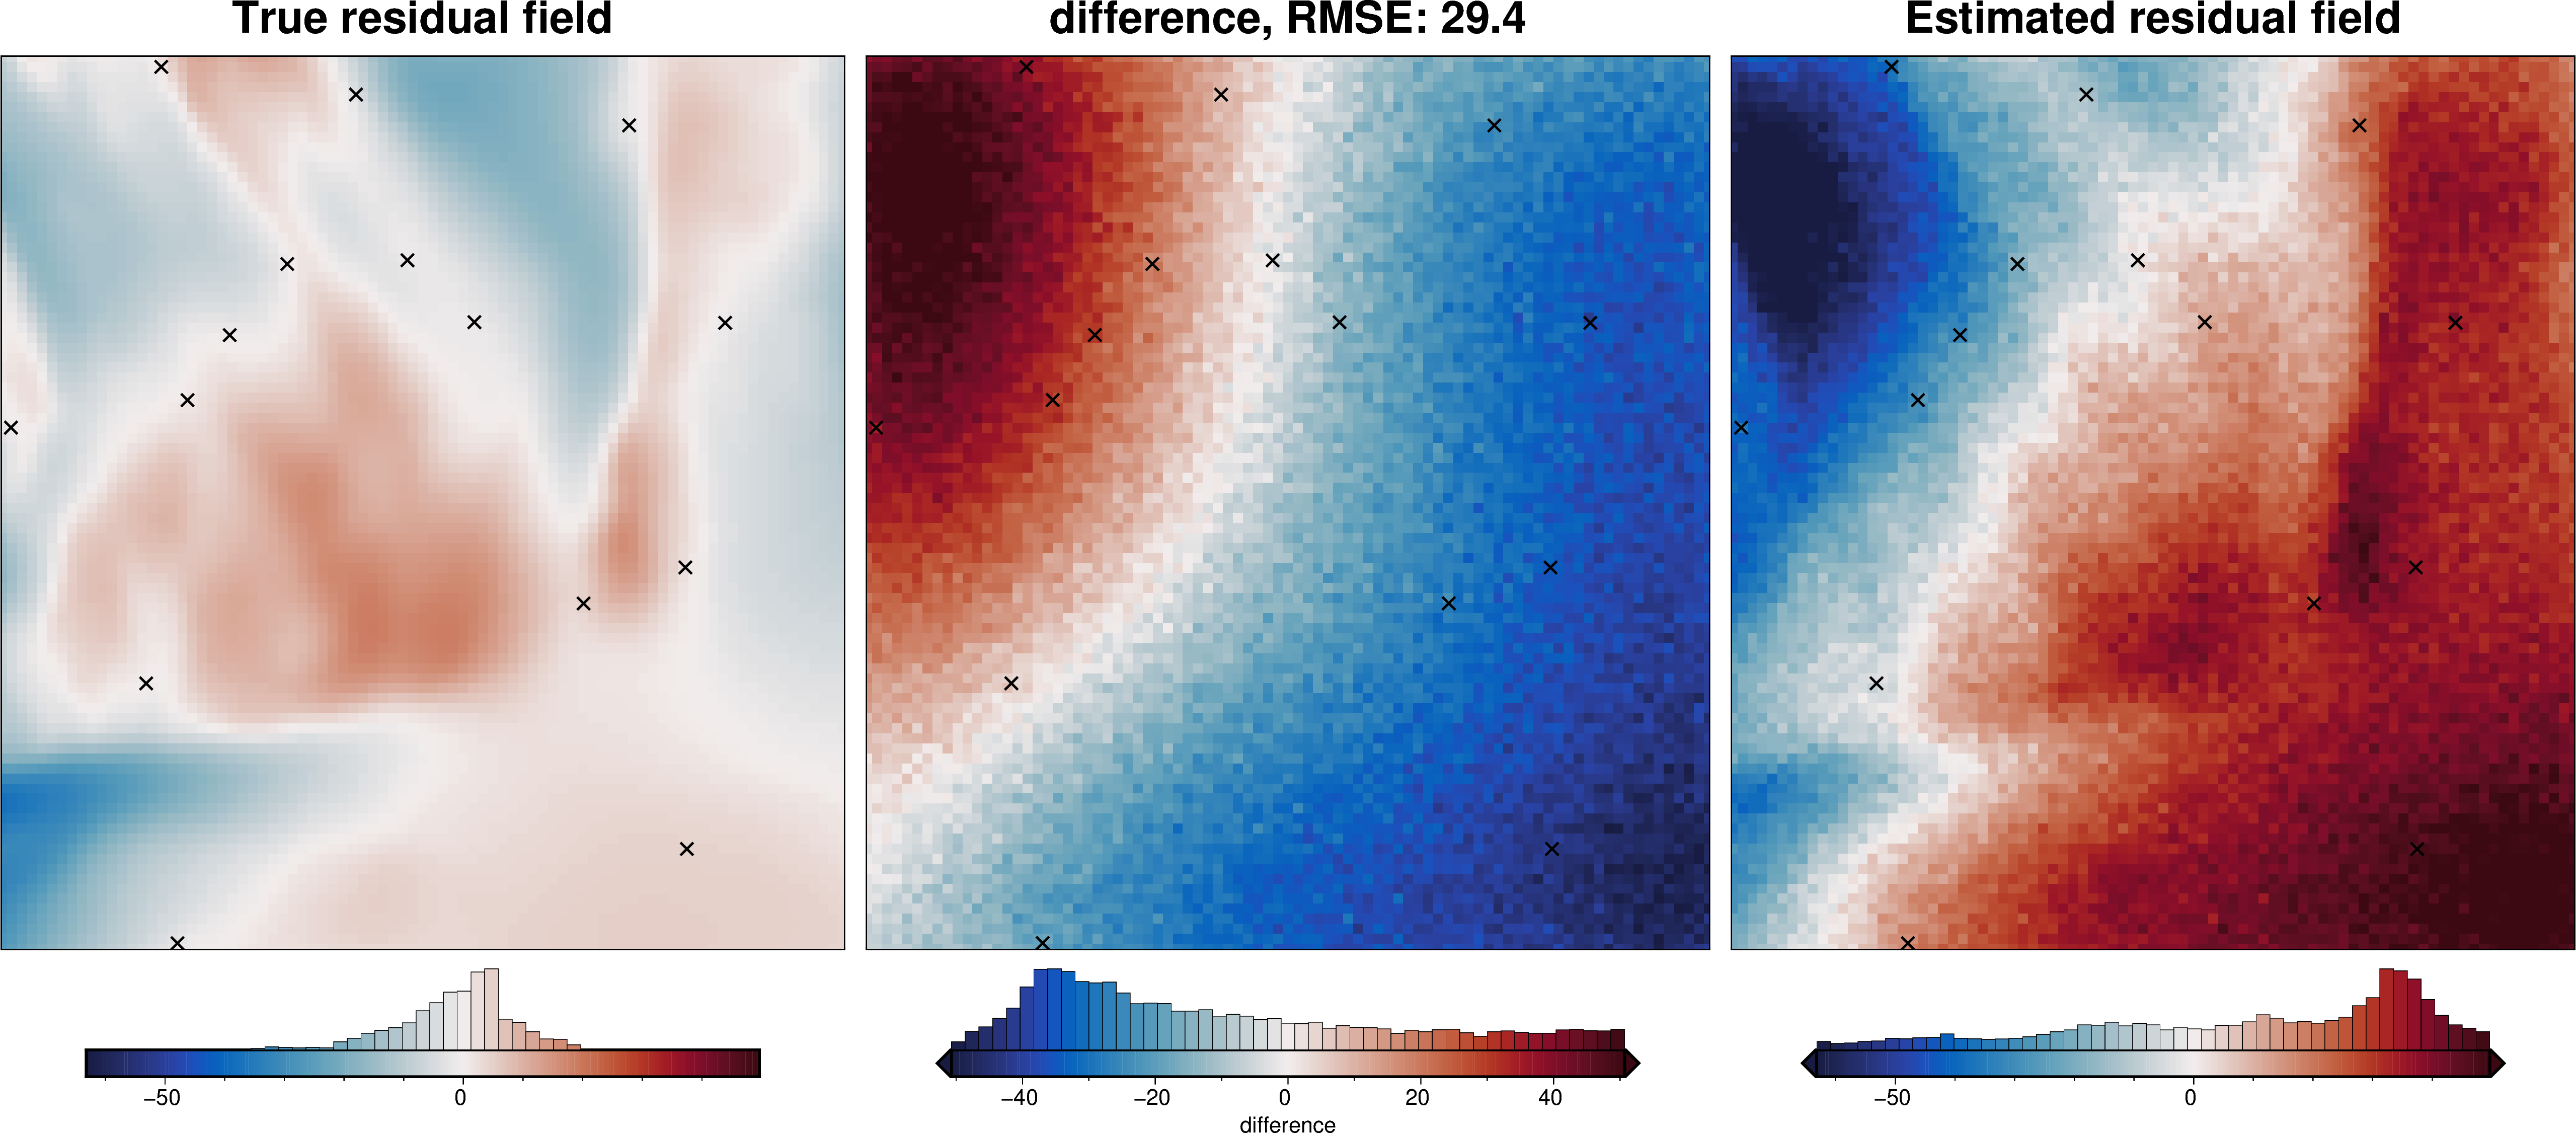

northing   easting  upward  basement_grav   moho_grav  \
0     162900.0   23900.0  1000.0      -2.757285   96.960094   
1     162900.0   27900.0  1000.0      -2.269120   97.455083   
2     162900.0   31900.0  1000.0      -1.542954   98.041998   
3     162900.0   35900.0  1000.0      -0.943922   98.703694   
4     162900.0   39900.0  1000.0      -0.600378   99.424611   
...        ...       ...     ...            ...         ...   
7645  518900.0  343900.0  1000.0     -10.351265  115.487366   
7646  518900.0  347900.0  1000.0     -11.802201  115.432978   
7647  518900.0  351900.0  1000.0     -13.471863  115.293789   
7648  518900.0  355900.0  1000.0     -15.076520  115.053595   
7649  518900.0  359900.0  1000.0     -16.322967  114.694342   

      gravity_anomaly_no_noise  gravity_anomaly  uncert  starting_gravity  \
0                    94.202809        94.460183     2.0         23.647390   
1                    95.185963        94.927666     2.0         22.471577   
2                    96.499044        97.785802     2.0         21.191806   
3                    97.759772        97.975486     2.0         19.849115   
4                    98.824233        97.758807     2.0         18.468023   
...                        ...              ...     ...               ...   
7645                105.136101       103.016203     2.0        -10.567831   
7646                103.630778       102.575691     2.0        -10.493463   
7647                101.821926       104.594824     2.0        -10.401262   
7648                 99.977075        98.286146     2.0        -10.282826   
7649                 98.371374        98.233297     2.0        -10.123443   

      forward_gravity   true_res      misfit        reg        res  \
0           23.647390 -26.404674   70.812794  91.191699 -20.378905   
1           22.471577 -24.740697   72.456090  91.191699 -18.735609   
2           21.191806 -22.734761   76.593996  91.191699 -14.597703   
3           19.849115 -20.793037   78.126371  91.191699 -13.065328   
4           18.468023 -19.068402   79.290784  91.191699 -11.900915   
...               ...        ...         ...        ...        ...   
7645       -10.567831   0.216566  113.584034  91.191699  22.392335   
7646       -10.493463  -1.308738  113.069154  91.191699  21.877456   
7647       -10.401262  -3.070601  114.996086  91.191699  23.804388   
7648       -10.282826  -4.793694  108.568973  91.191699  17.377274   
7649       -10.123443  -6.199525  108.356740  91.191699  17.165042   

      constant_reg  constant_res  
0        91.191699    -20.378905  
1        91.191699    -18.735609  
2        91.191699    -14.597703  
3        91.191699    -13.065328  
4        91.191699    -11.900915  
...            ...           ...  
7645     91.191699     22.392335  
7646     91.191699     21.877456  
7647     91.191699     23.804388  
7648     91.191699     17.377274  
7649     91.191699     17.165042  

[7650 rows x 16 columns]

In [21]:
# estimate regional with the mean misfit at constraints
data = invert4geom.regional_constant(
    grav_ds=data,
    constraints_df=constraint_points,
)
data["constant_reg"] = data.reg
data["constant_res"] = data.res

regional_comparison(data, "constant_reg")

data.inv.df

#### 2) apply a custom constant value

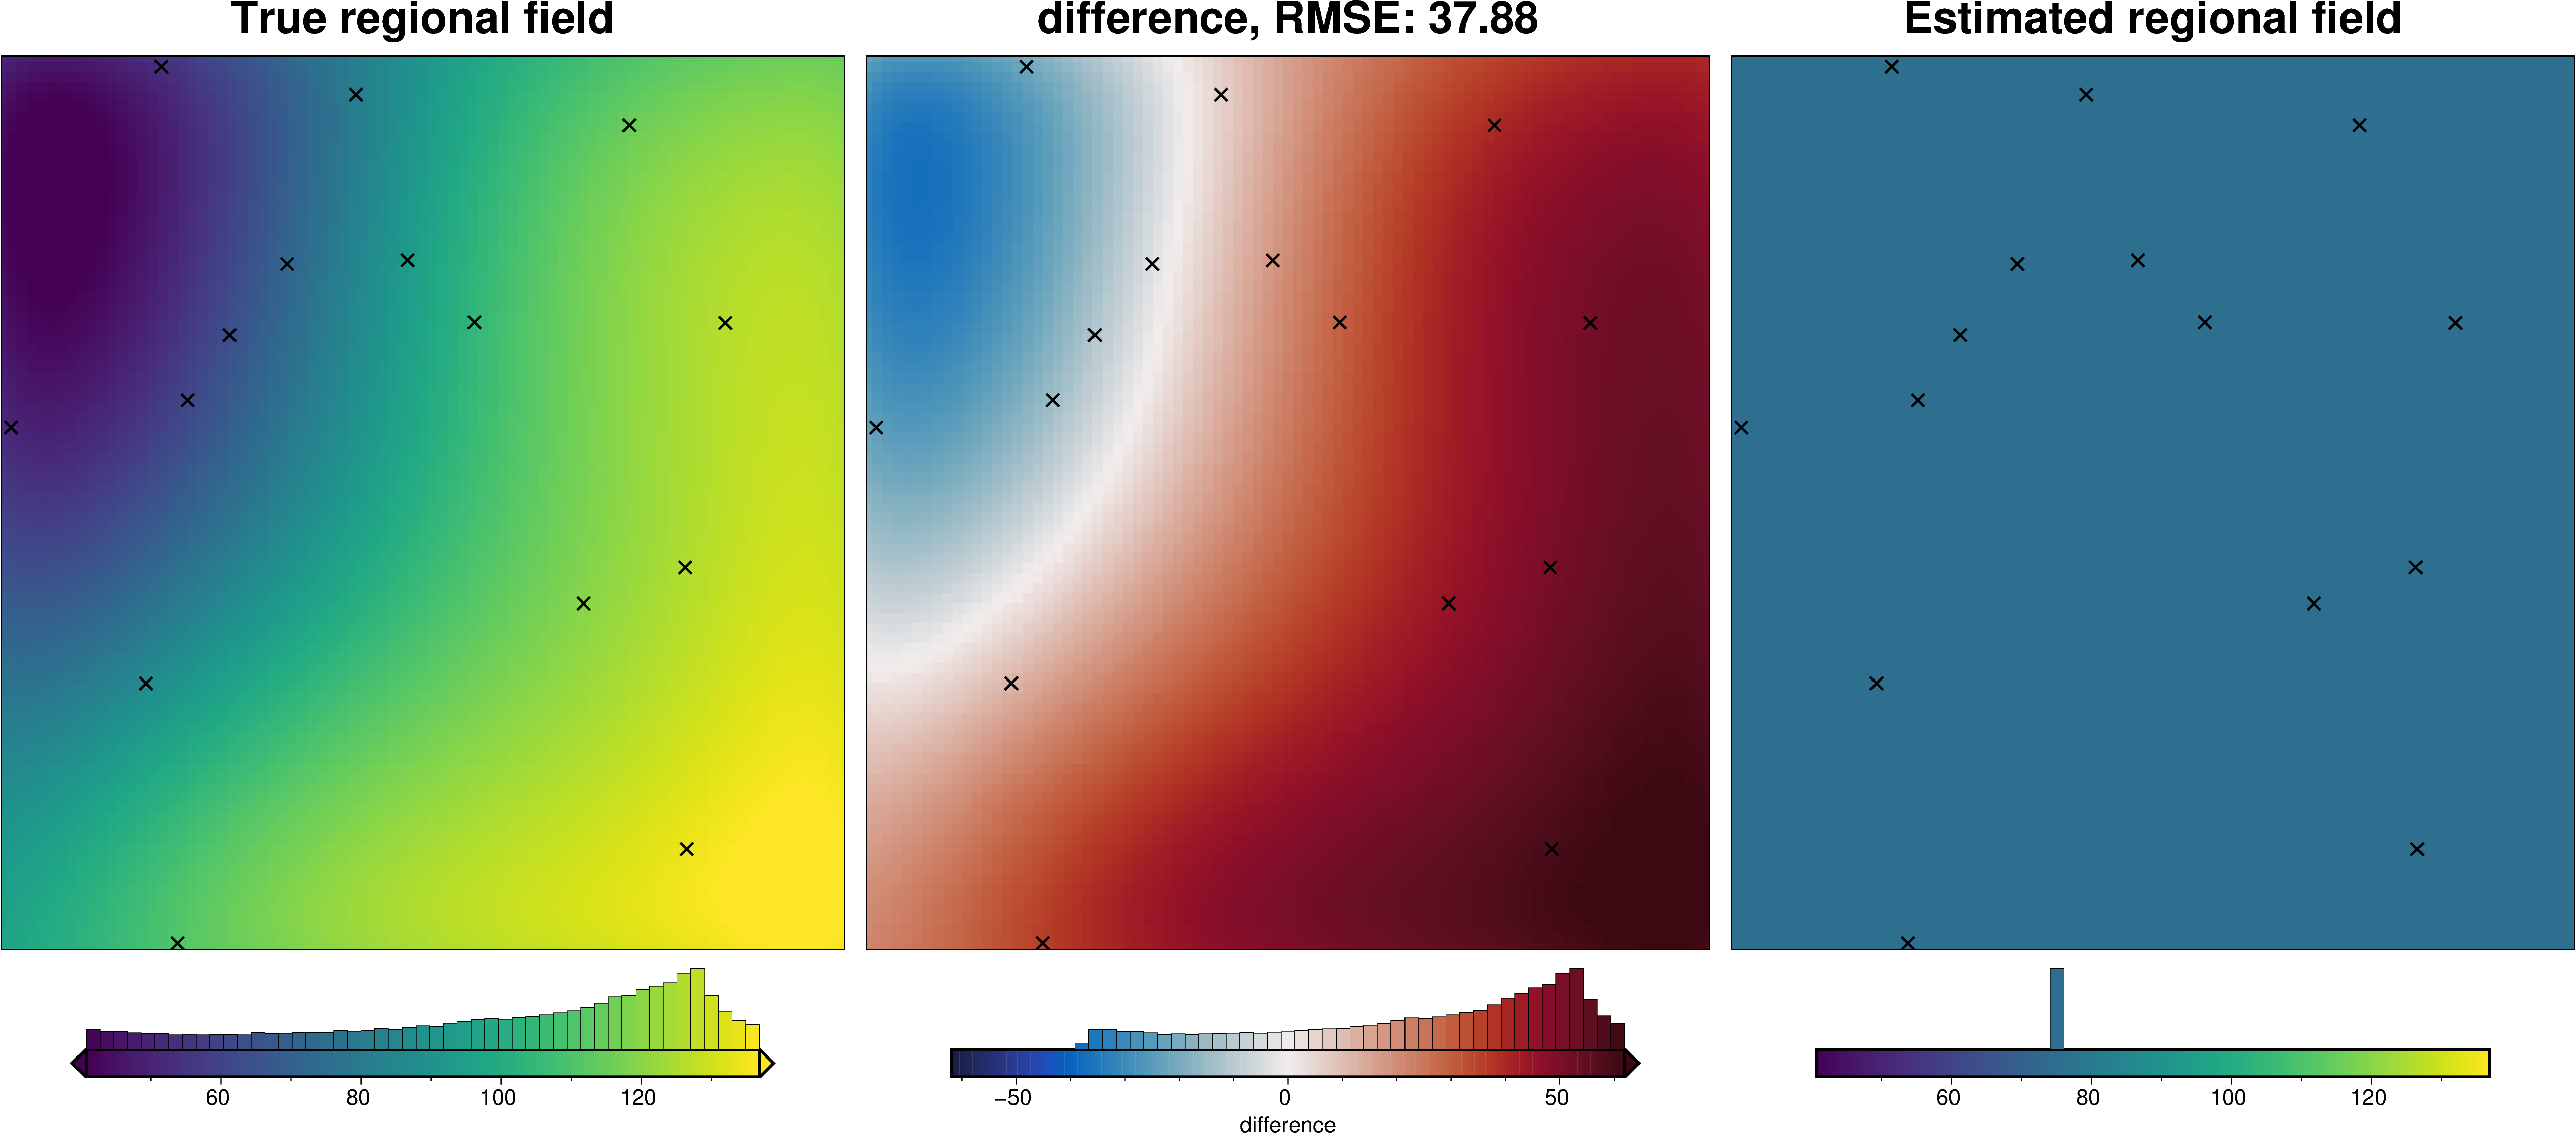

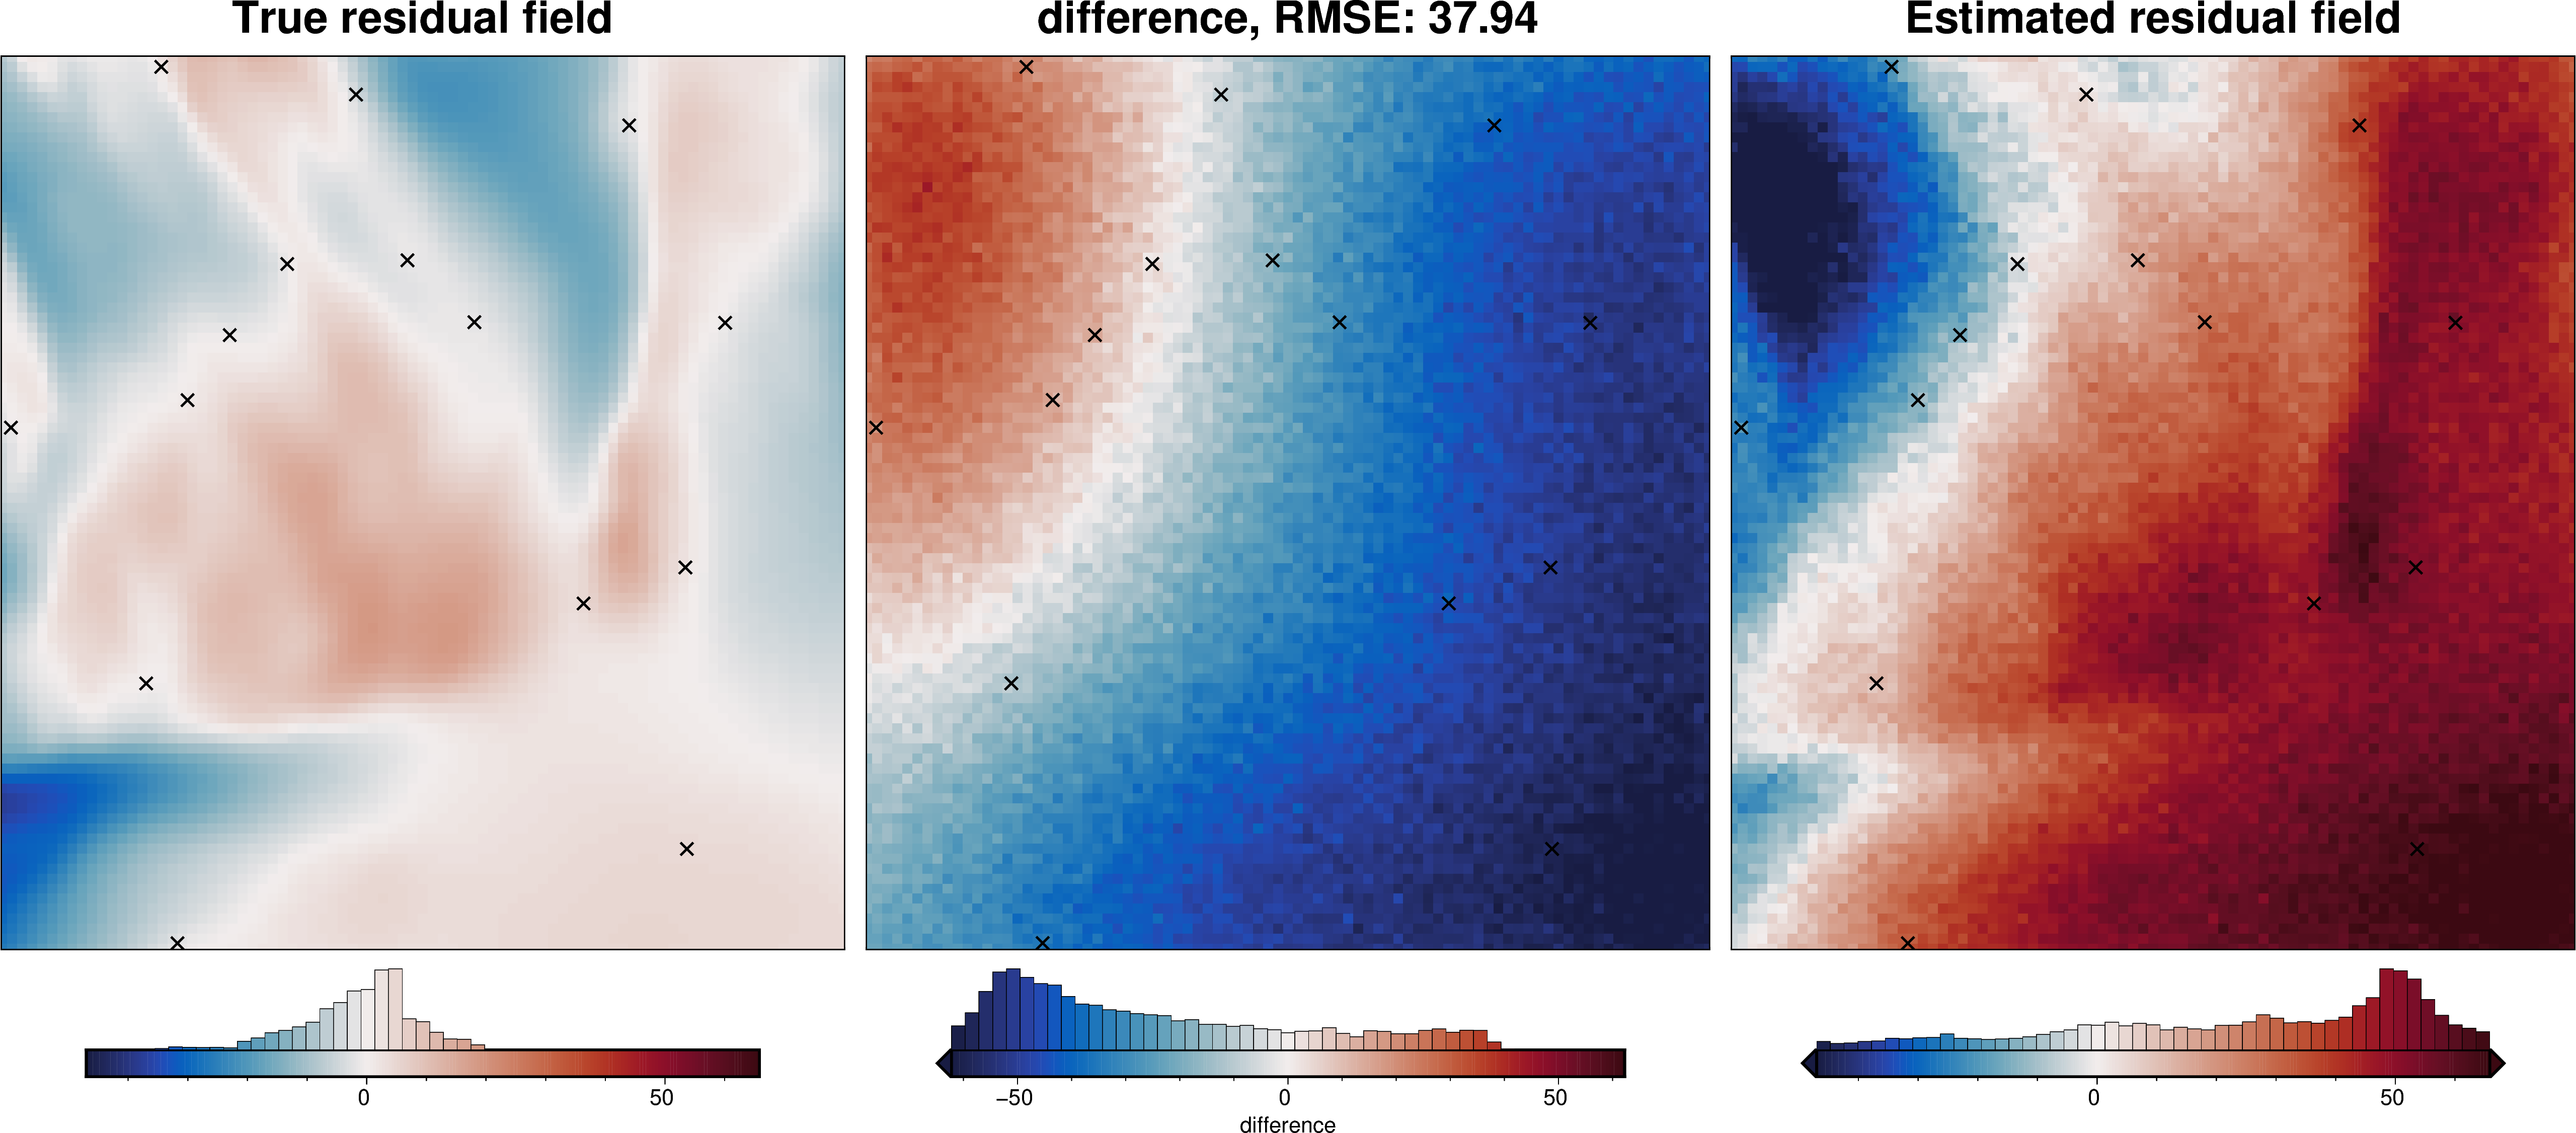

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

       gravity_anomaly_no_noise  gravity_anomaly  uncert  starting_gravity  \
count               7650.000000      7650.000000  7650.0       7650.000000   
mean                 101.157271       101.157271     2.0          1.548577   
std                    9.703771         9.919851     0.0         24.926461   
min                   75.617509        70.861220     2.0        -36.414267   
25%                   96.218487        96.092524     2.0        -17.408451   
50%                  102.149812       102.057202     2.0         -3.040309   
75%                  106.787344       107.006336     2.0         19.823536   
max                  126.329916       129.736453     2.0         59.698559   

       forward_gravity     true_res       misfit     reg          res  \
count      7650.000000  7650.000000  7650.000000  7650.0  7650.000000   
mean          1.548577    -1.245734    99.608694    75.0    24.608694   
std          24.926461     9.140039    30.581609     0.0    30.581609   
min         -36.414267   -37.589976    17.942842    75.0   -57.057158   
25%         -17.408451    -6.242037    78.143138    75.0     3.143138   
50%          -3.040309     0.182452   107.150139    75.0    32.150139   
75%          19.823536     4.467848   124.912841    75.0    49.912841   
max          59.698559    19.038660   148.090389    75.0    73.090389   

       constant_reg  constant_res  constant_custom_reg  constant_custom_res  
count  7.650000e+03   7650.000000               7650.0          7650.000000  
mean   9.119170e+01      8.416995                 75.0            24.608694  
std    1.421178e-14     30.581609                  0.0            30.581609  
min    9.119170e+01    -73.248856                 75.0           -57.057158  
25%    9.119170e+01    -13.048560                 75.0             3.143138  
50%    9.119170e+01     15.958441                 75.0            32.150139  
75%    9.119170e+01     33.721142                 75.0            49.912841  
max    9.119170e+01     56.898690                 75.0            73.090389

In [22]:
# estimate regional with the custom constant value
data = invert4geom.regional_constant(
    grav_ds=data,
    constant=75,
)
data["constant_custom_reg"] = data.reg
data["constant_custom_res"] = data.res

regional_comparison(data, "constant_custom_reg")

data.inv.df.describe()

### Filter

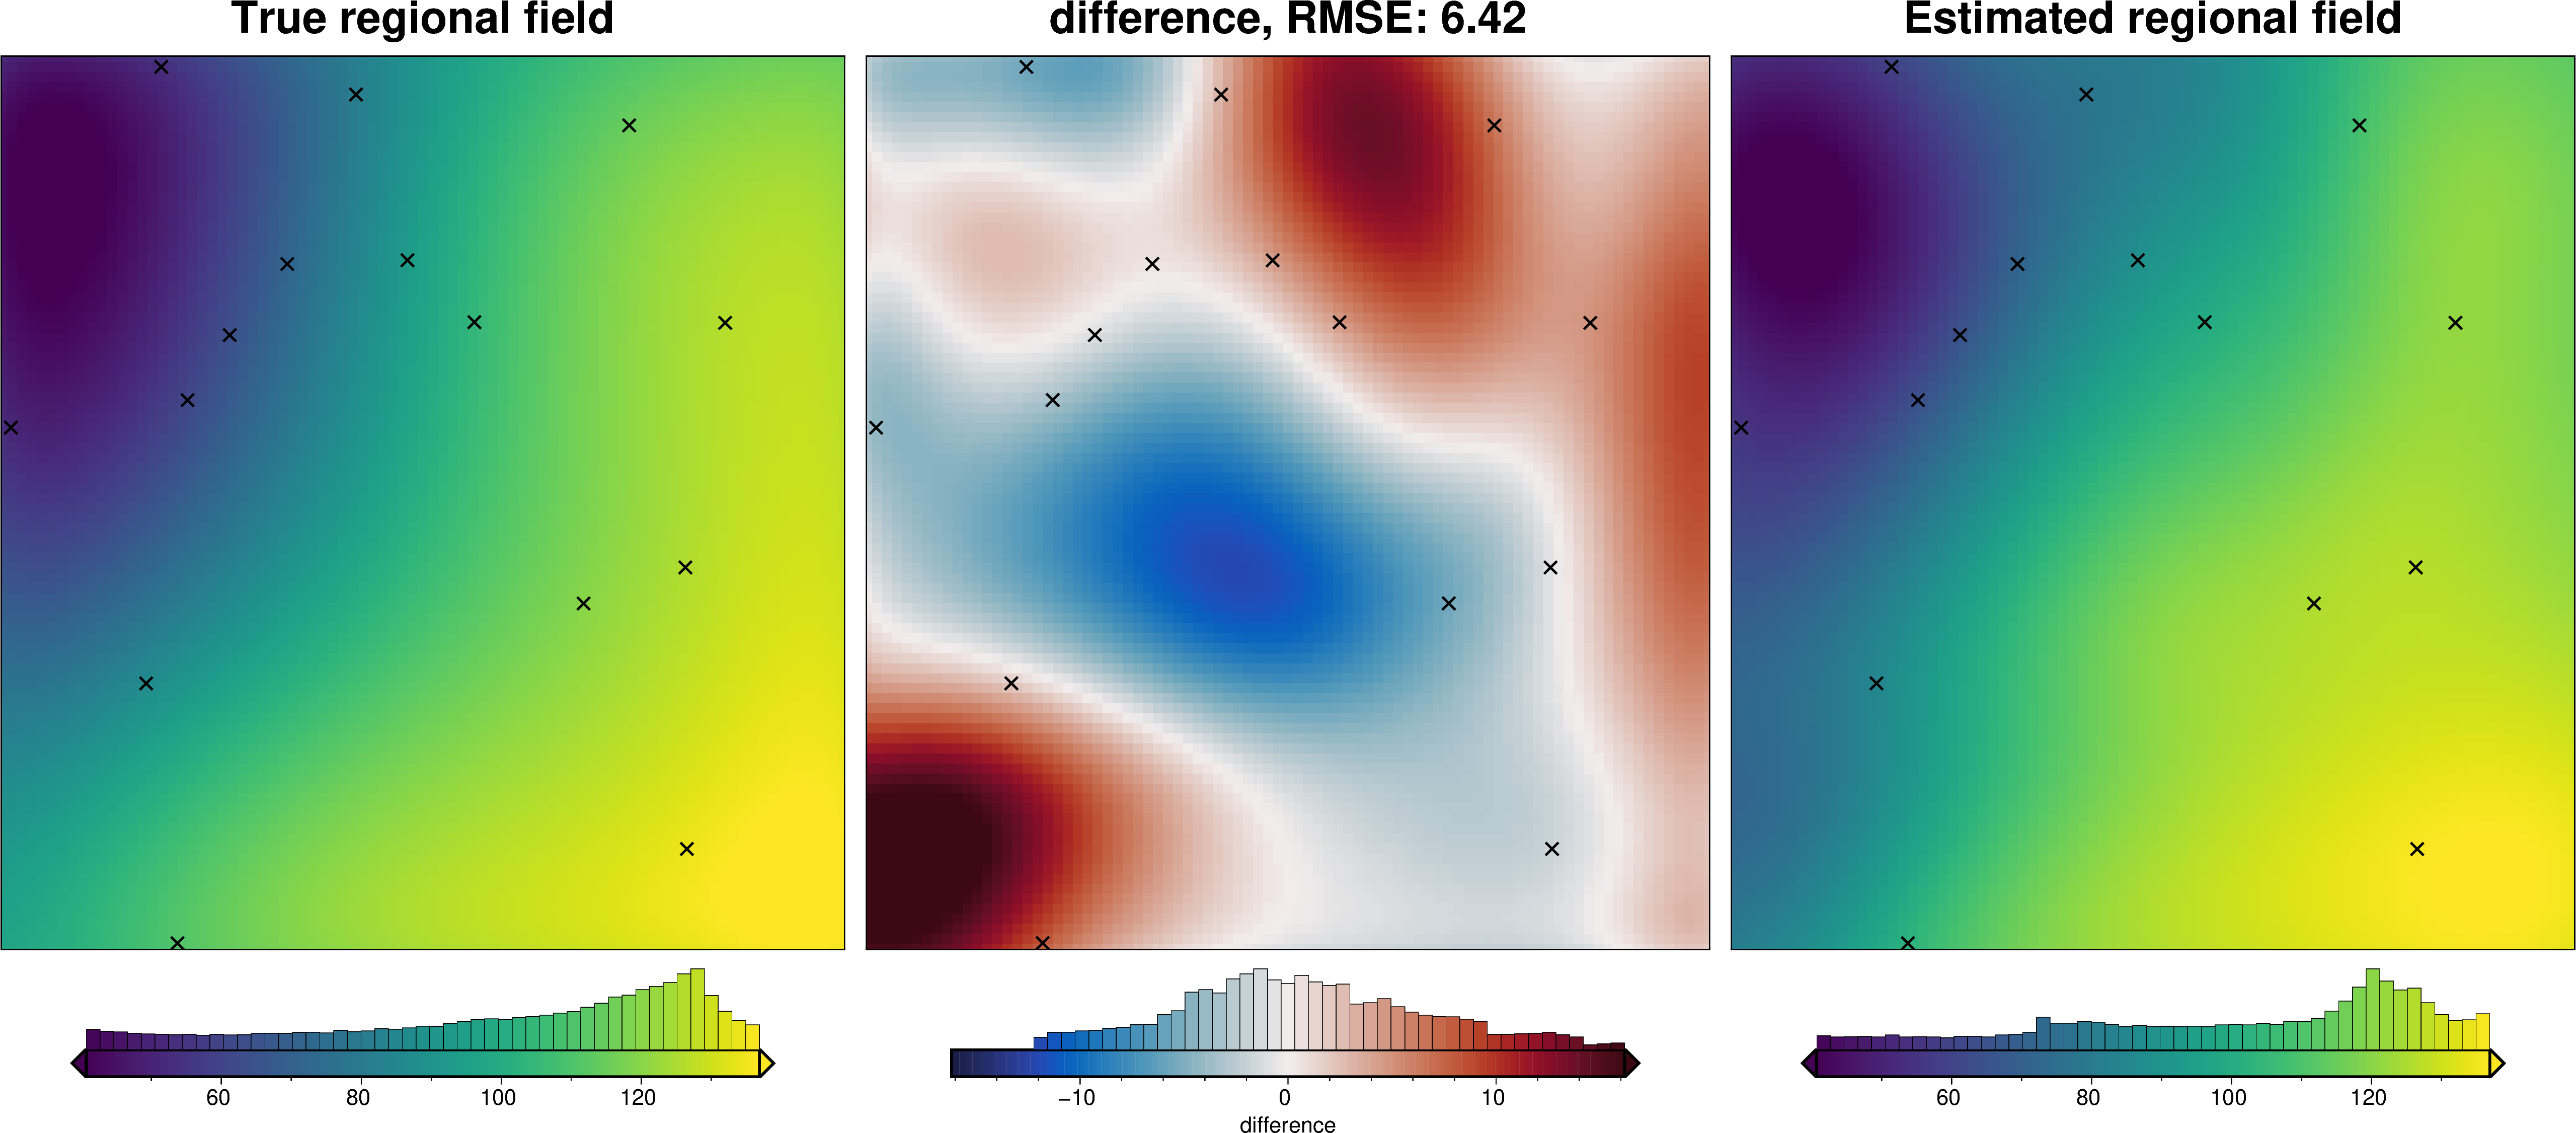

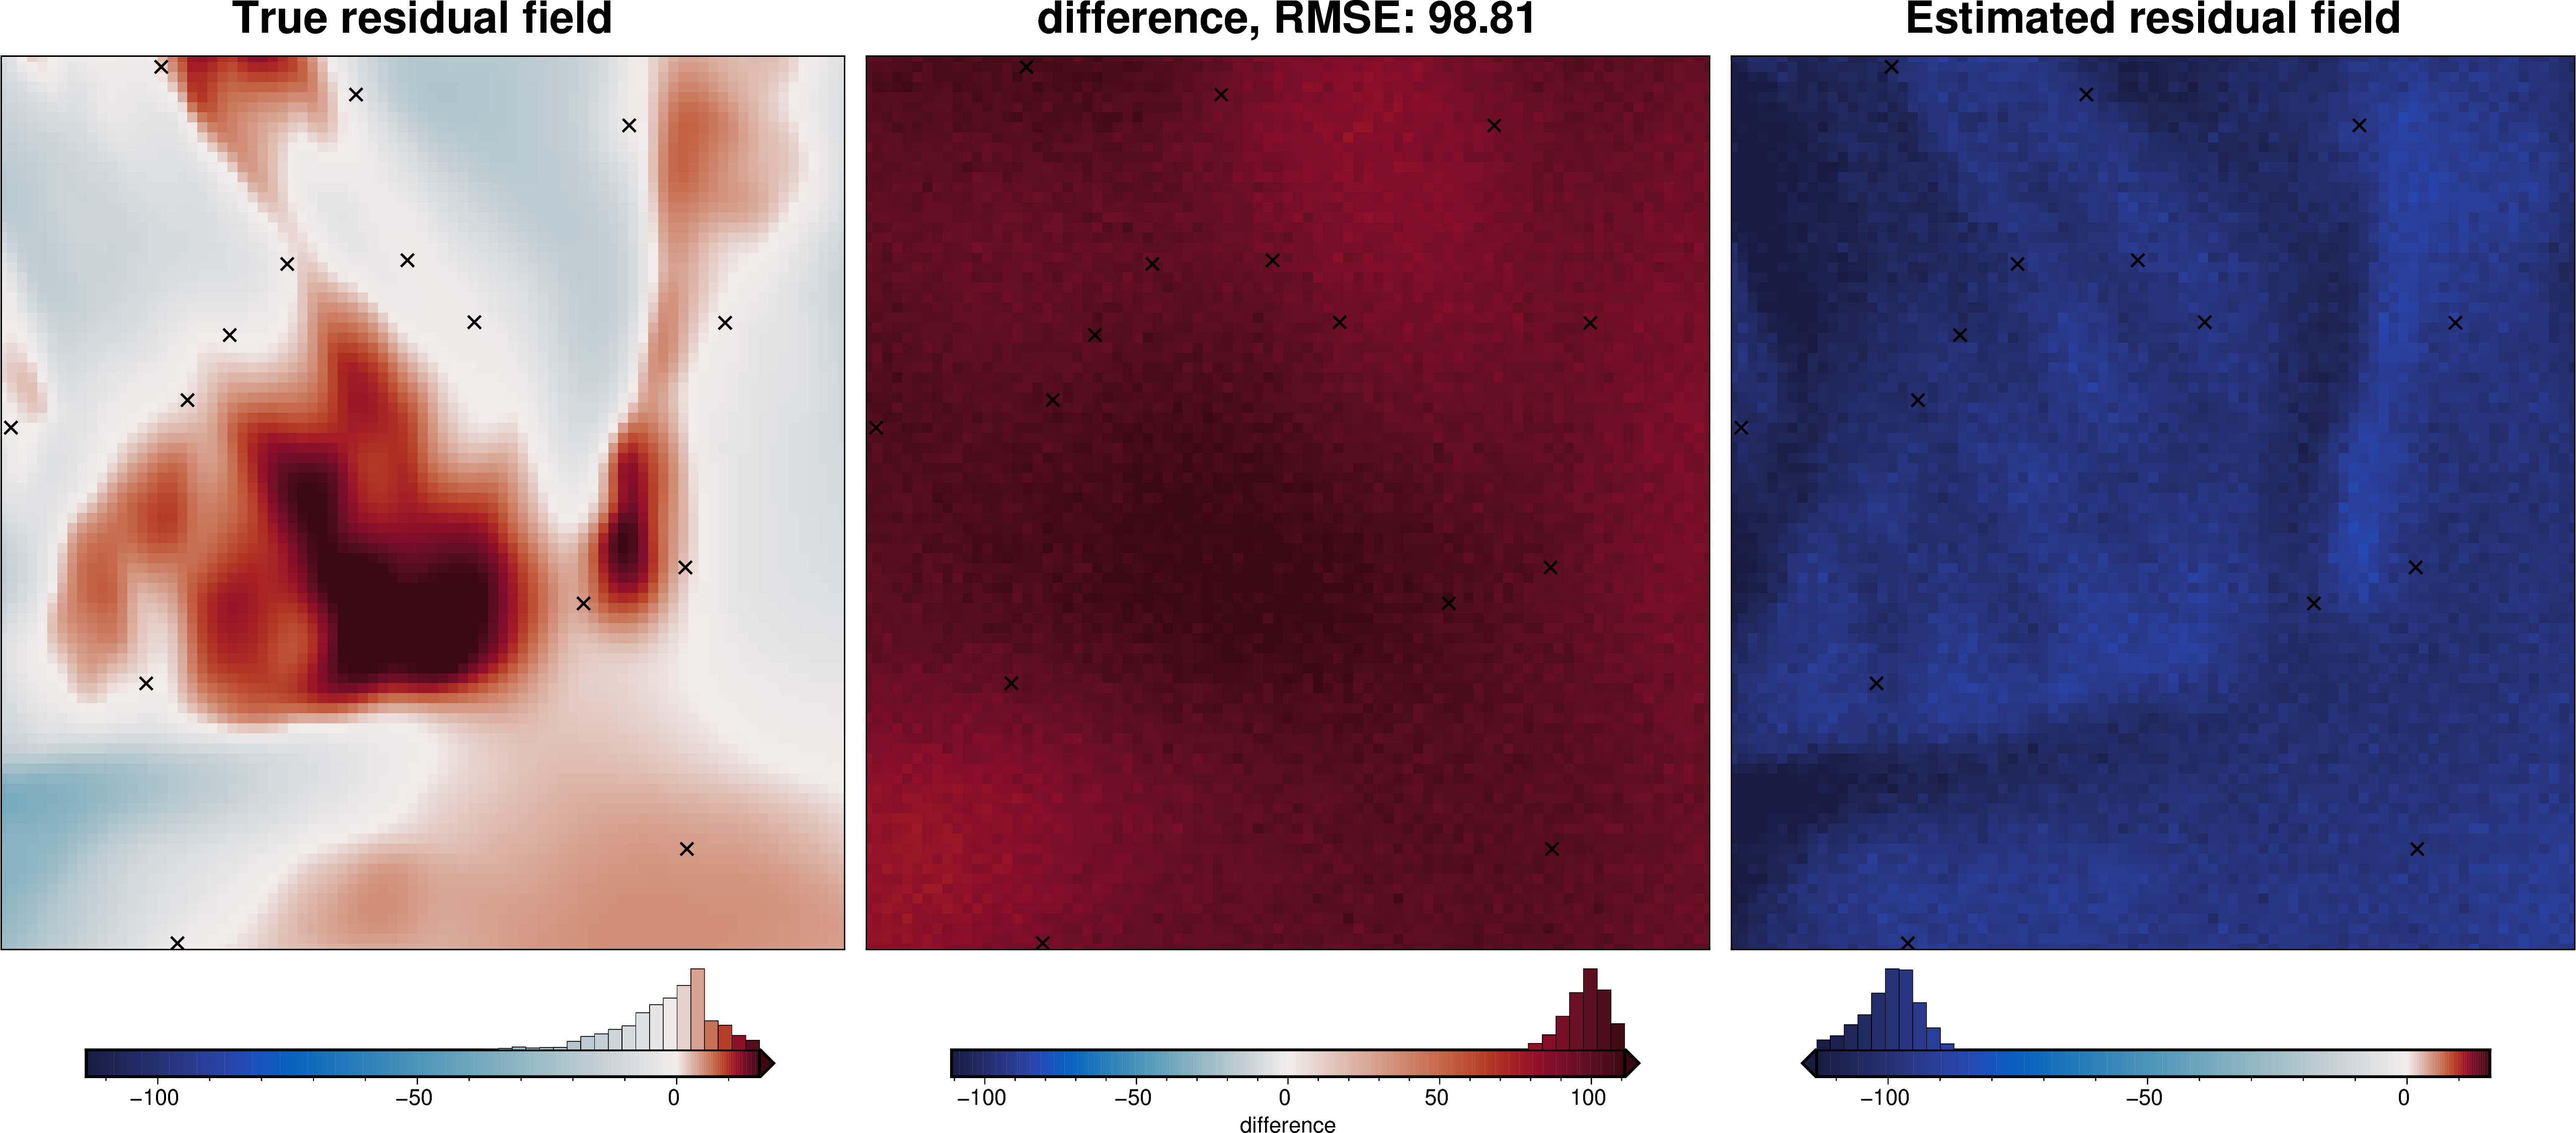

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

       gravity_anomaly_no_noise  gravity_anomaly  uncert  starting_gravity  \
count               7650.000000      7650.000000  7650.0       7650.000000   
mean                 101.157271       101.157271     2.0          1.548577   
std                    9.703771         9.919851     0.0         24.926461   
min                   75.617509        70.861220     2.0        -36.414267   
25%                   96.218487        96.092524     2.0        -17.408451   
50%                  102.149812       102.057202     2.0         -3.040309   
75%                  106.787344       107.006336     2.0         19.823536   
max                  126.329916       129.736453     2.0         59.698559   

       forward_gravity     true_res        misfit          reg          res  \
count      7650.000000  7650.000000  7.650000e+03  7650.000000  7650.000000   
mean          1.548577    -1.245734 -4.755528e-15    99.829289   -99.829289   
std          24.926461     9.140039  3.058161e+01    27.063857     5.642272   
min         -36.414267   -37.589976 -8.166585e+01    36.812193  -122.133212   
25%         -17.408451    -6.242037 -2.146556e+01    79.328207  -102.895648   
50%          -3.040309     0.182452  7.541446e+00   107.365011   -99.086918   
75%          19.823536     4.467848  2.530415e+01   121.943848   -96.012109   
max          59.698559    19.038660  4.848169e+01   137.738630   -84.125432   

       constant_reg  constant_res  constant_custom_reg  constant_custom_res  \
count  7.650000e+03   7650.000000               7650.0          7650.000000   
mean   9.119170e+01      8.416995                 75.0            24.608694   
std    1.421178e-14     30.581609                  0.0            30.581609   
min    9.119170e+01    -73.248856                 75.0           -57.057158   
25%    9.119170e+01    -13.048560                 75.0             3.143138   
50%    9.119170e+01     15.958441                 75.0            32.150139   
75%    9.119170e+01     33.721142                 75.0            49.912841   
max    9.119170e+01     56.898690                 75.0            73.090389   

        filter_reg   filter_res  
count  7650.000000  7650.000000  
mean     99.829289   -99.829289  
std      27.063857     5.642272  
min      36.812193  -122.133212  
25%      79.328207  -102.895648  
50%     107.365011   -99.086918  
75%     121.943848   -96.012109  
max     137.738630   -84.125432

In [23]:
# estimate regional with a 200km low pass filter
data = invert4geom.regional_filter(
    grav_ds=data,
    filter_width=200e3,
)
data["filter_reg"] = data.reg
data["filter_res"] = data.res

regional_comparison(data, "filter_reg")

data.inv.df.describe()

### Trend

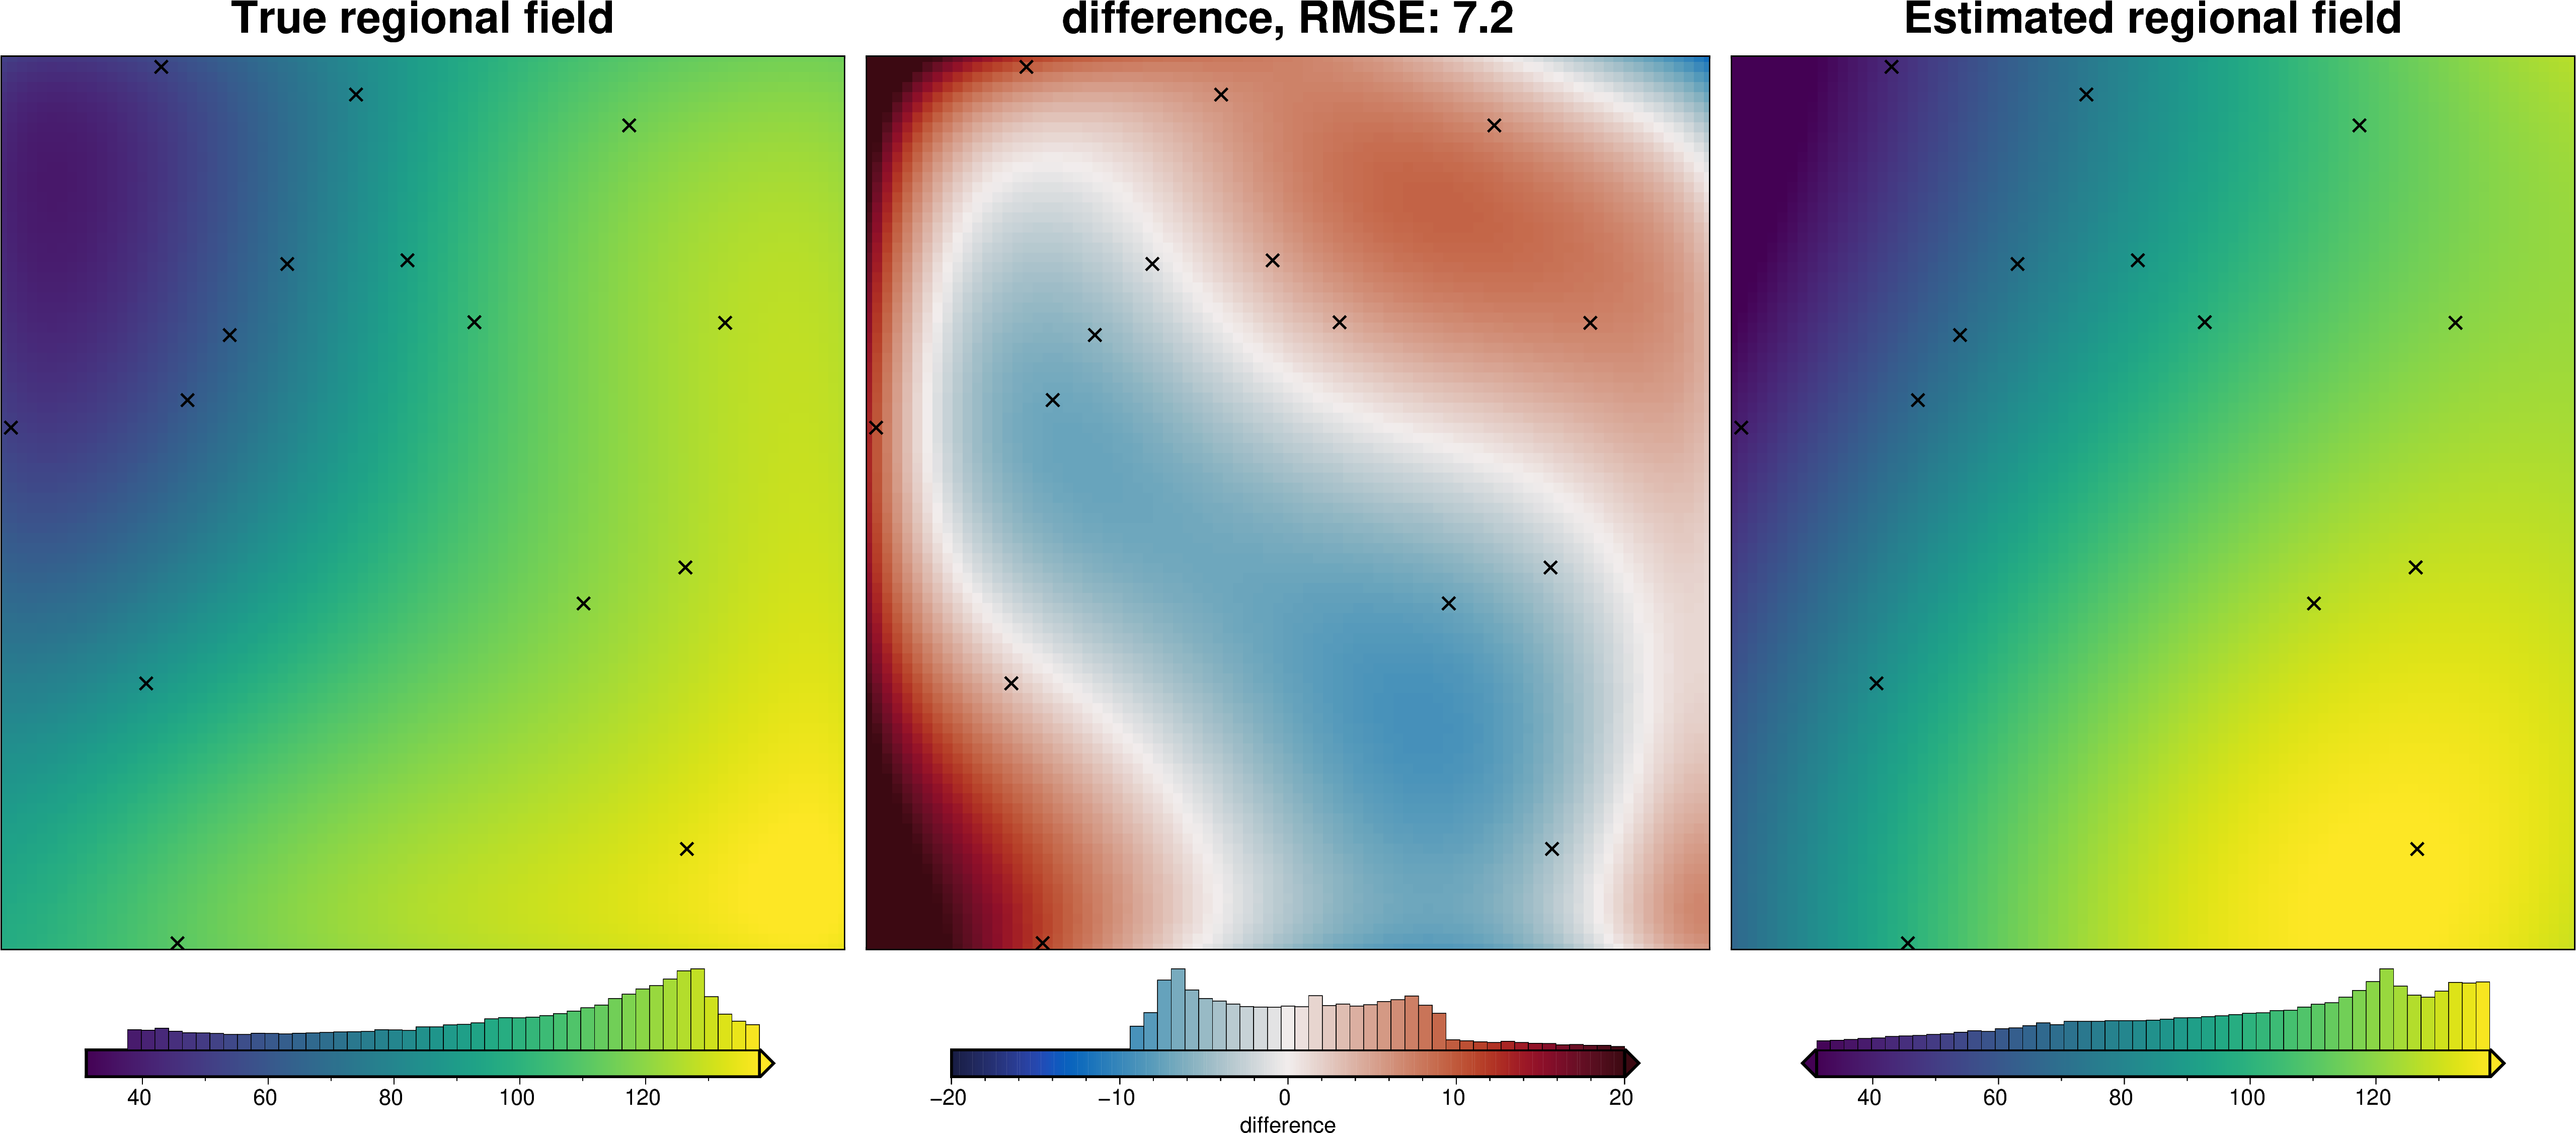

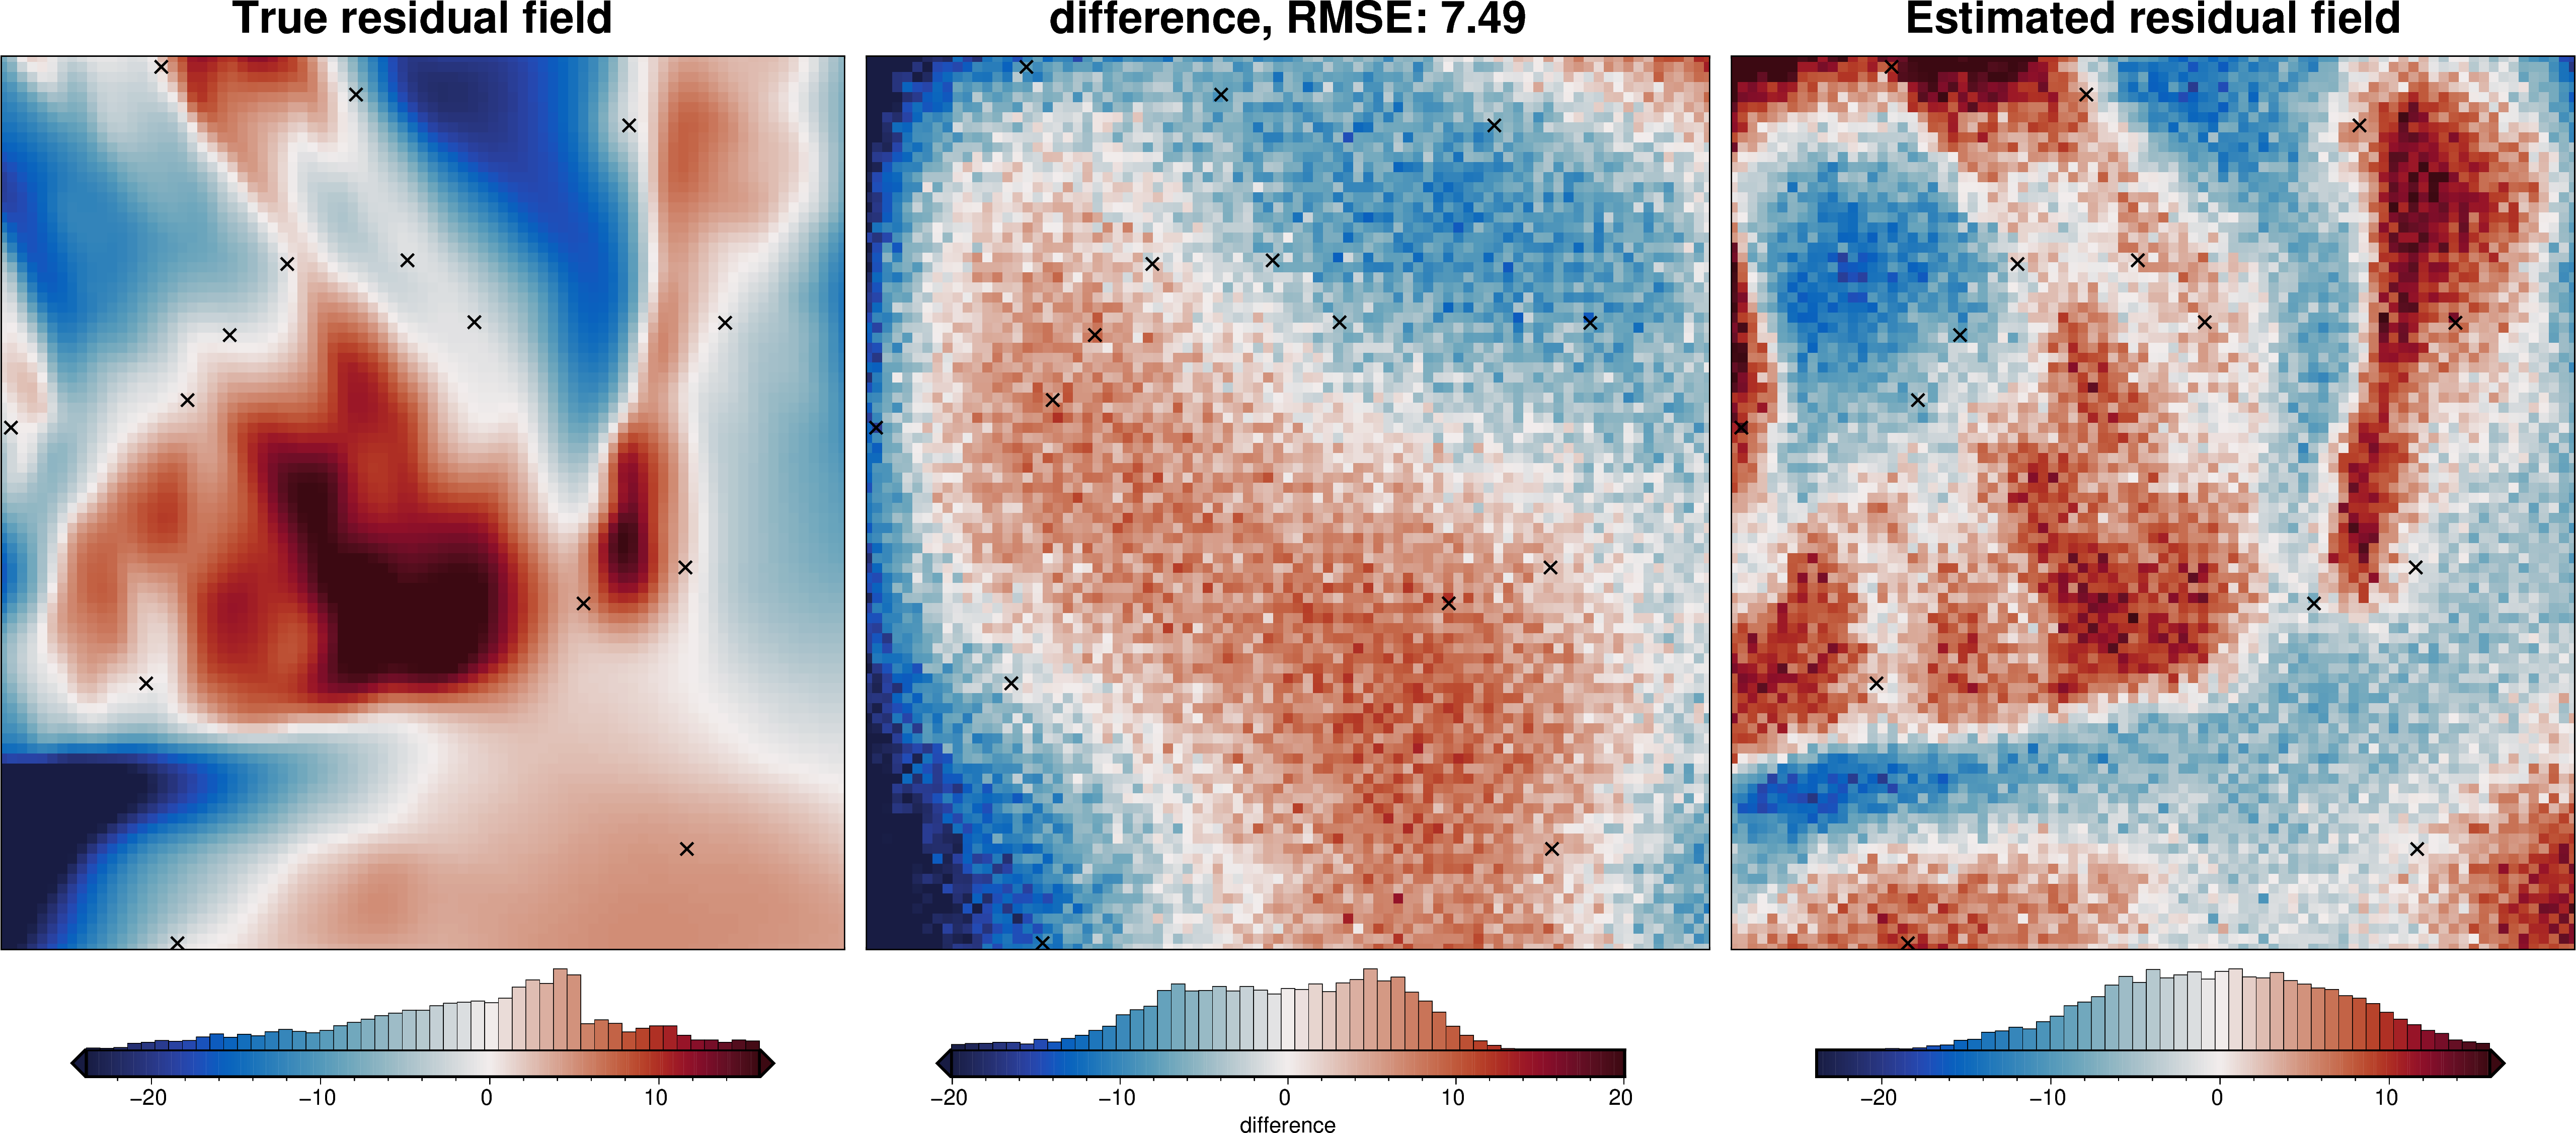

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

       gravity_anomaly_no_noise  gravity_anomaly  uncert  starting_gravity  \
count               7650.000000      7650.000000  7650.0       7650.000000   
mean                 101.157271       101.157271     2.0          1.548577   
std                    9.703771         9.919851     0.0         24.926461   
min                   75.617509        70.861220     2.0        -36.414267   
25%                   96.218487        96.092524     2.0        -17.408451   
50%                  102.149812       102.057202     2.0         -3.040309   
75%                  106.787344       107.006336     2.0         19.823536   
max                  126.329916       129.736453     2.0         59.698559   

       forward_gravity  ...          reg           res  constant_reg  \
count      7650.000000  ...  7650.000000  7.650000e+03  7.650000e+03   
mean          1.548577  ...    99.608694 -7.513734e-13  9.119170e+01   
std          24.926461  ...    29.768297  7.005950e+00  1.421178e-14   
min         -36.414267  ...    16.420129 -2.015606e+01  9.119170e+01   
25%         -17.408451  ...    78.401816 -5.089756e+00  9.119170e+01   
50%          -3.040309  ...   106.923096 -3.247819e-02  9.119170e+01   
75%          19.823536  ...   123.773507  5.122518e+00  9.119170e+01   
max          59.698559  ...   138.964569  3.065616e+01  9.119170e+01   

       constant_res  constant_custom_reg  constant_custom_res   filter_reg  \
count   7650.000000               7650.0          7650.000000  7650.000000   
mean       8.416995                 75.0            24.608694    99.829289   
std       30.581609                  0.0            30.581609    27.063857   
min      -73.248856                 75.0           -57.057158    36.812193   
25%      -13.048560                 75.0             3.143138    79.328207   
50%       15.958441                 75.0            32.150139   107.365011   
75%       33.721142                 75.0            49.912841   121.943848   
max       56.898690                 75.0            73.090389   137.738630   

        filter_res    trend_reg     trend_res  
count  7650.000000  7650.000000  7.650000e+03  
mean    -99.829289    99.608694 -7.513734e-13  
std       5.642272    29.768297  7.005950e+00  
min    -122.133212    16.420129 -2.015606e+01  
25%    -102.895648    78.401816 -5.089756e+00  
50%     -99.086918   106.923096 -3.247819e-02  
75%     -96.012109   123.773507  5.122518e+00  
max     -84.125432   138.964569  3.065616e+01  

[8 rows x 22 columns]

In [24]:
# estimate regional with fitting a 3rd order trend
data = invert4geom.regional_trend(
    grav_ds=data,
    trend=3,
)
data["trend_reg"] = data.reg
data["trend_res"] = data.res

regional_comparison(data, "trend_reg")

data.inv.df.describe()

### Equivalent Sources

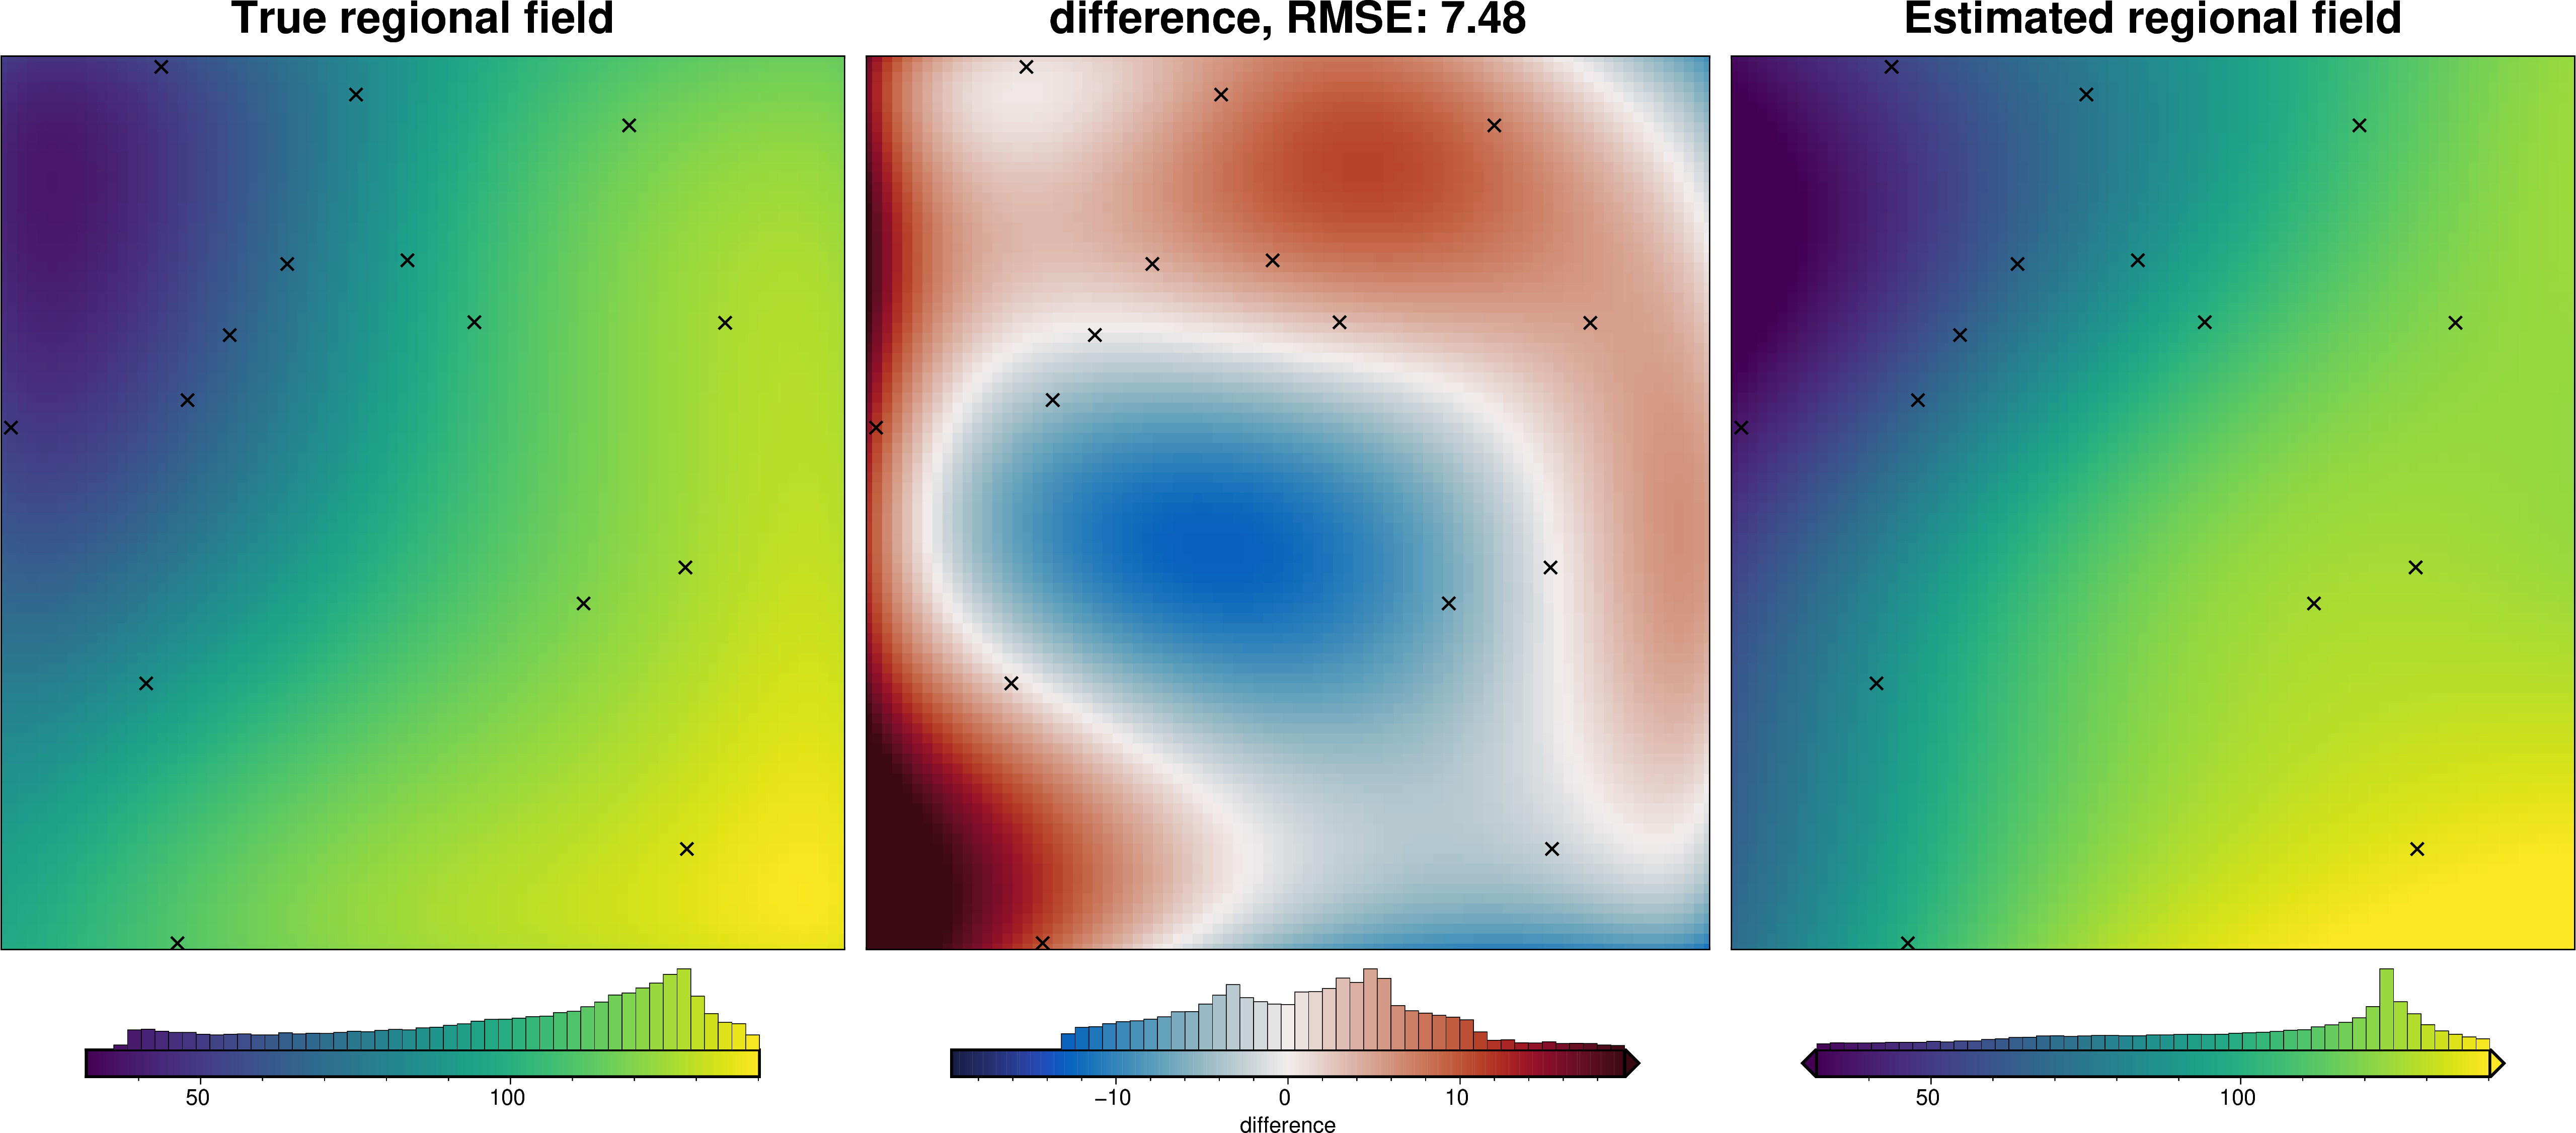

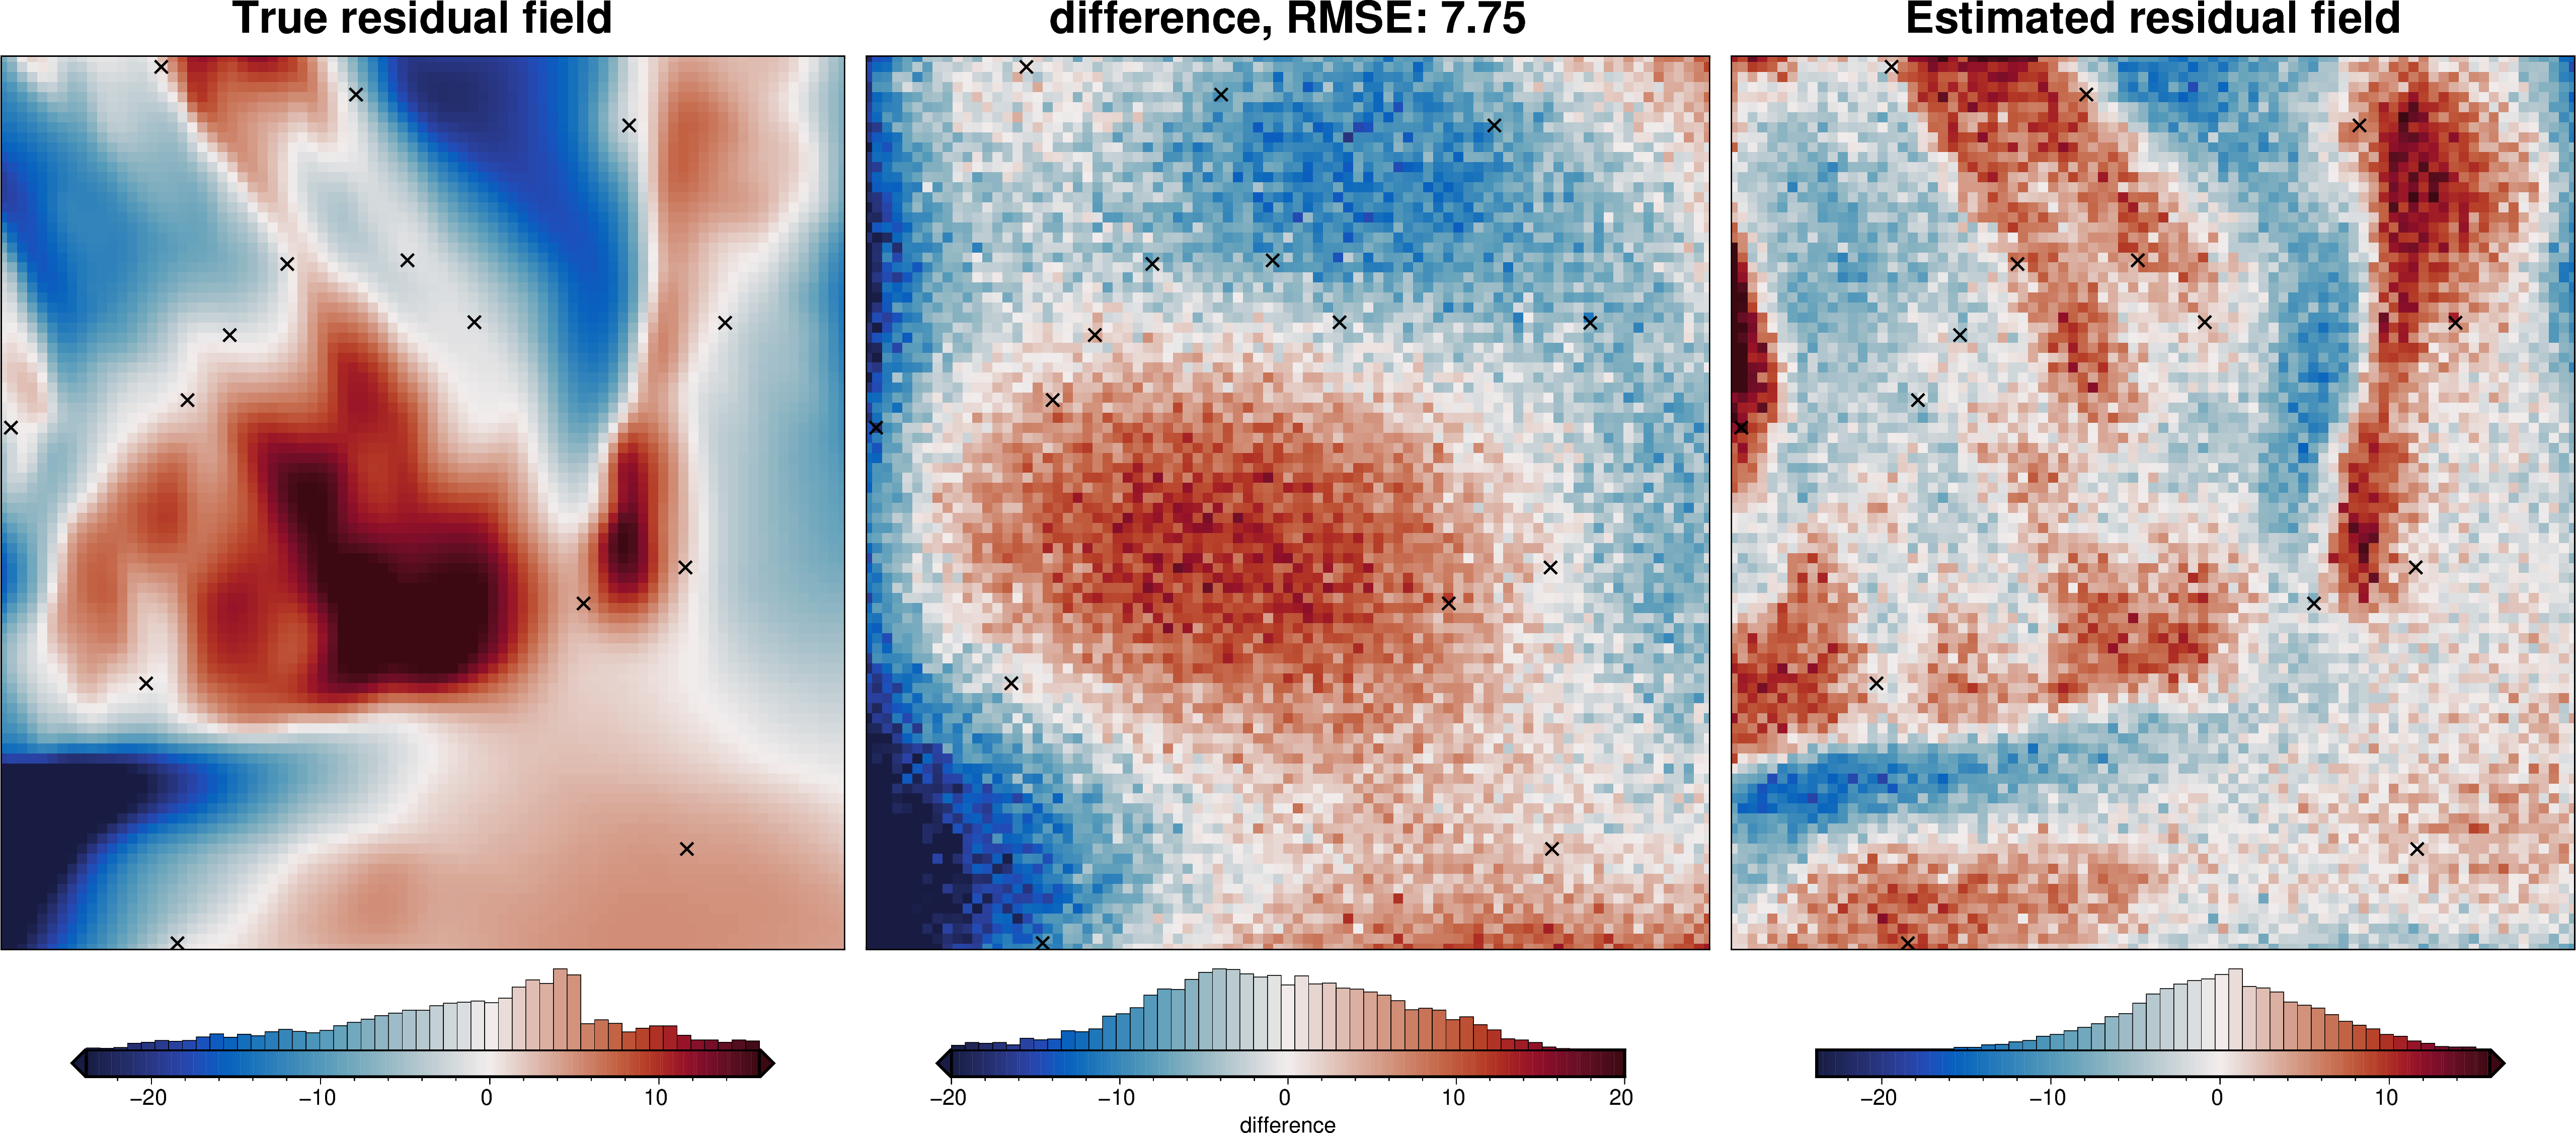

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

       gravity_anomaly_no_noise  gravity_anomaly  uncert  starting_gravity  \
count               7650.000000      7650.000000  7650.0       7650.000000   
mean                 101.157271       101.157271     2.0          1.548577   
std                    9.703771         9.919851     0.0         24.926461   
min                   75.617509        70.861220     2.0        -36.414267   
25%                   96.218487        96.092524     2.0        -17.408451   
50%                  102.149812       102.057202     2.0         -3.040309   
75%                  106.787344       107.006336     2.0         19.823536   
max                  126.329916       129.736453     2.0         59.698559   

       forward_gravity  ...  constant_reg  constant_res  constant_custom_reg  \
count      7650.000000  ...  7.650000e+03   7650.000000               7650.0   
mean          1.548577  ...  9.119170e+01      8.416995                 75.0   
std          24.926461  ...  1.421178e-14     30.581609                  0.0   
min         -36.414267  ...  9.119170e+01    -73.248856                 75.0   
25%         -17.408451  ...  9.119170e+01    -13.048560                 75.0   
50%          -3.040309  ...  9.119170e+01     15.958441                 75.0   
75%          19.823536  ...  9.119170e+01     33.721142                 75.0   
max          59.698559  ...  9.119170e+01     56.898690                 75.0   

       constant_custom_res   filter_reg   filter_res    trend_reg  \
count          7650.000000  7650.000000  7650.000000  7650.000000   
mean             24.608694    99.829289   -99.829289    99.608694   
std              30.581609    27.063857     5.642272    29.768297   
min             -57.057158    36.812193  -122.133212    16.420129   
25%               3.143138    79.328207  -102.895648    78.401816   
50%              32.150139   107.365011   -99.086918   106.923096   
75%              49.912841   121.943848   -96.012109   123.773507   
max              73.090389   137.738630   -84.125432   138.964569   

          trend_res  eq_sources_reg  eq_sources_res  
count  7.650000e+03     7650.000000     7650.000000  
mean  -7.513734e-13       99.529885        0.078809  
std    7.005950e+00       29.887298        5.608333  
min   -2.015606e+01       22.406783      -18.294135  
25%   -5.089756e+00       77.708304       -3.555612  
50%   -3.247819e-02      108.694621        0.084550  
75%    5.122518e+00      123.546778        3.731717  
max    3.065616e+01      146.611638       22.281547  

[8 rows x 24 columns]

In [25]:
# estimate regional with equivalent sources. This estimates the longwavlength component
# by either
# 1) using deep sources (`depth` parameter)
# 2) upwards continuing the fitted data (`grav_obs_height` parameter)
# 3) apply damping to the fitting (`damping` parameter)
data = invert4geom.regional_eq_sources(
    grav_ds=data,
    depth=300e3,
    damping=0.1,
    grav_obs_height=1.5e3,
    block_size=spacing * 10,
)
data["eq_sources_reg"] = data.reg
data["eq_sources_res"] = data.res

regional_comparison(data, "eq_sources_reg")

data.inv.df.describe()

### Constraint point minimization

#### gridding with PyGMT and tension factors

In [26]:
data

<xarray.Dataset> Size: 1MB
Dimensions:                   (northing: 90, easting: 85)
Coordinates:
  * easting                   (easting) float64 680B 2.39e+04 ... 3.599e+05
  * northing                  (northing) float64 720B 1.629e+05 ... 5.189e+05
Data variables: (12/22)
    upward                    (northing, easting) float64 61kB 1e+03 ... 1e+03
    basement_grav             (northing, easting) float64 61kB -2.757 ... -16.32
    moho_grav                 (northing, easting) float64 61kB 96.96 ... 114.7
    gravity_anomaly_no_noise  (northing, easting) float64 61kB 94.2 ... 98.37
    gravity_anomaly           (northing, easting) float64 61kB 94.46 ... 98.23
    uncert                    (northing, easting) float64 61kB 2.0 2.0 ... 2.0
    ...                        ...
    filter_reg                (northing, easting) float64 61kB 81.35 ... 112.9
    filter_res                (northing, easting) float64 61kB -110.1 ... -104.2
    trend_reg                 (northing, easting) float64 61kB 66.73 ... 126.8
    trend_res                 (northing, easting) float64 61kB 4.086 ... -18.44
    eq_sources_reg            (northing, easting) float64 61kB 69.67 ... 123.8
    eq_sources_res            (northing, easting) float64 61kB 1.14 ... -15.4
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data

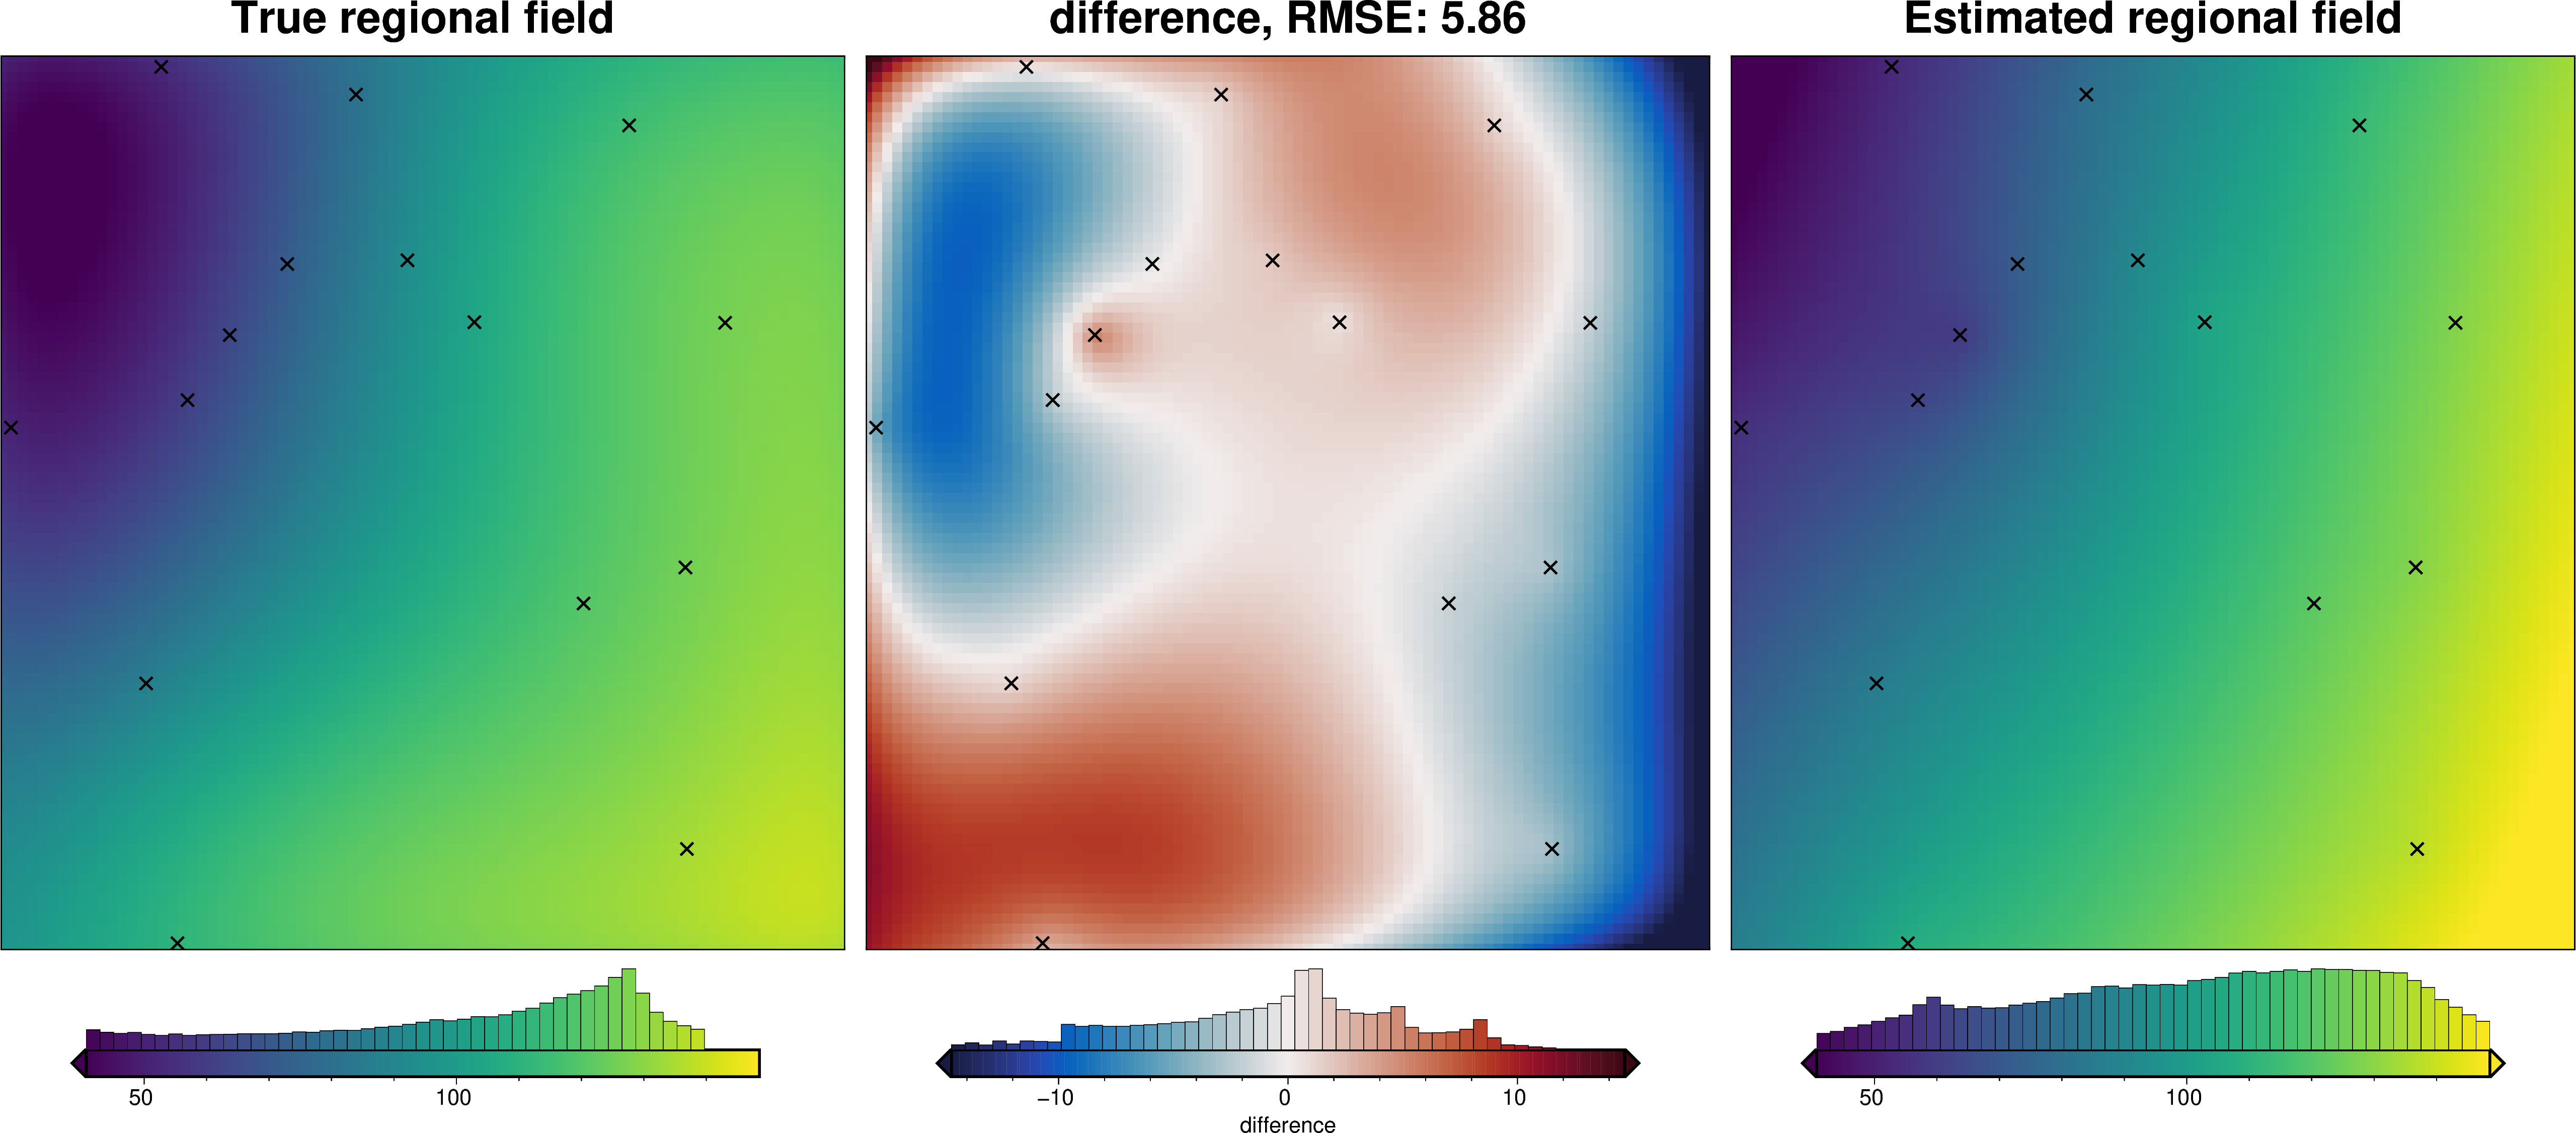

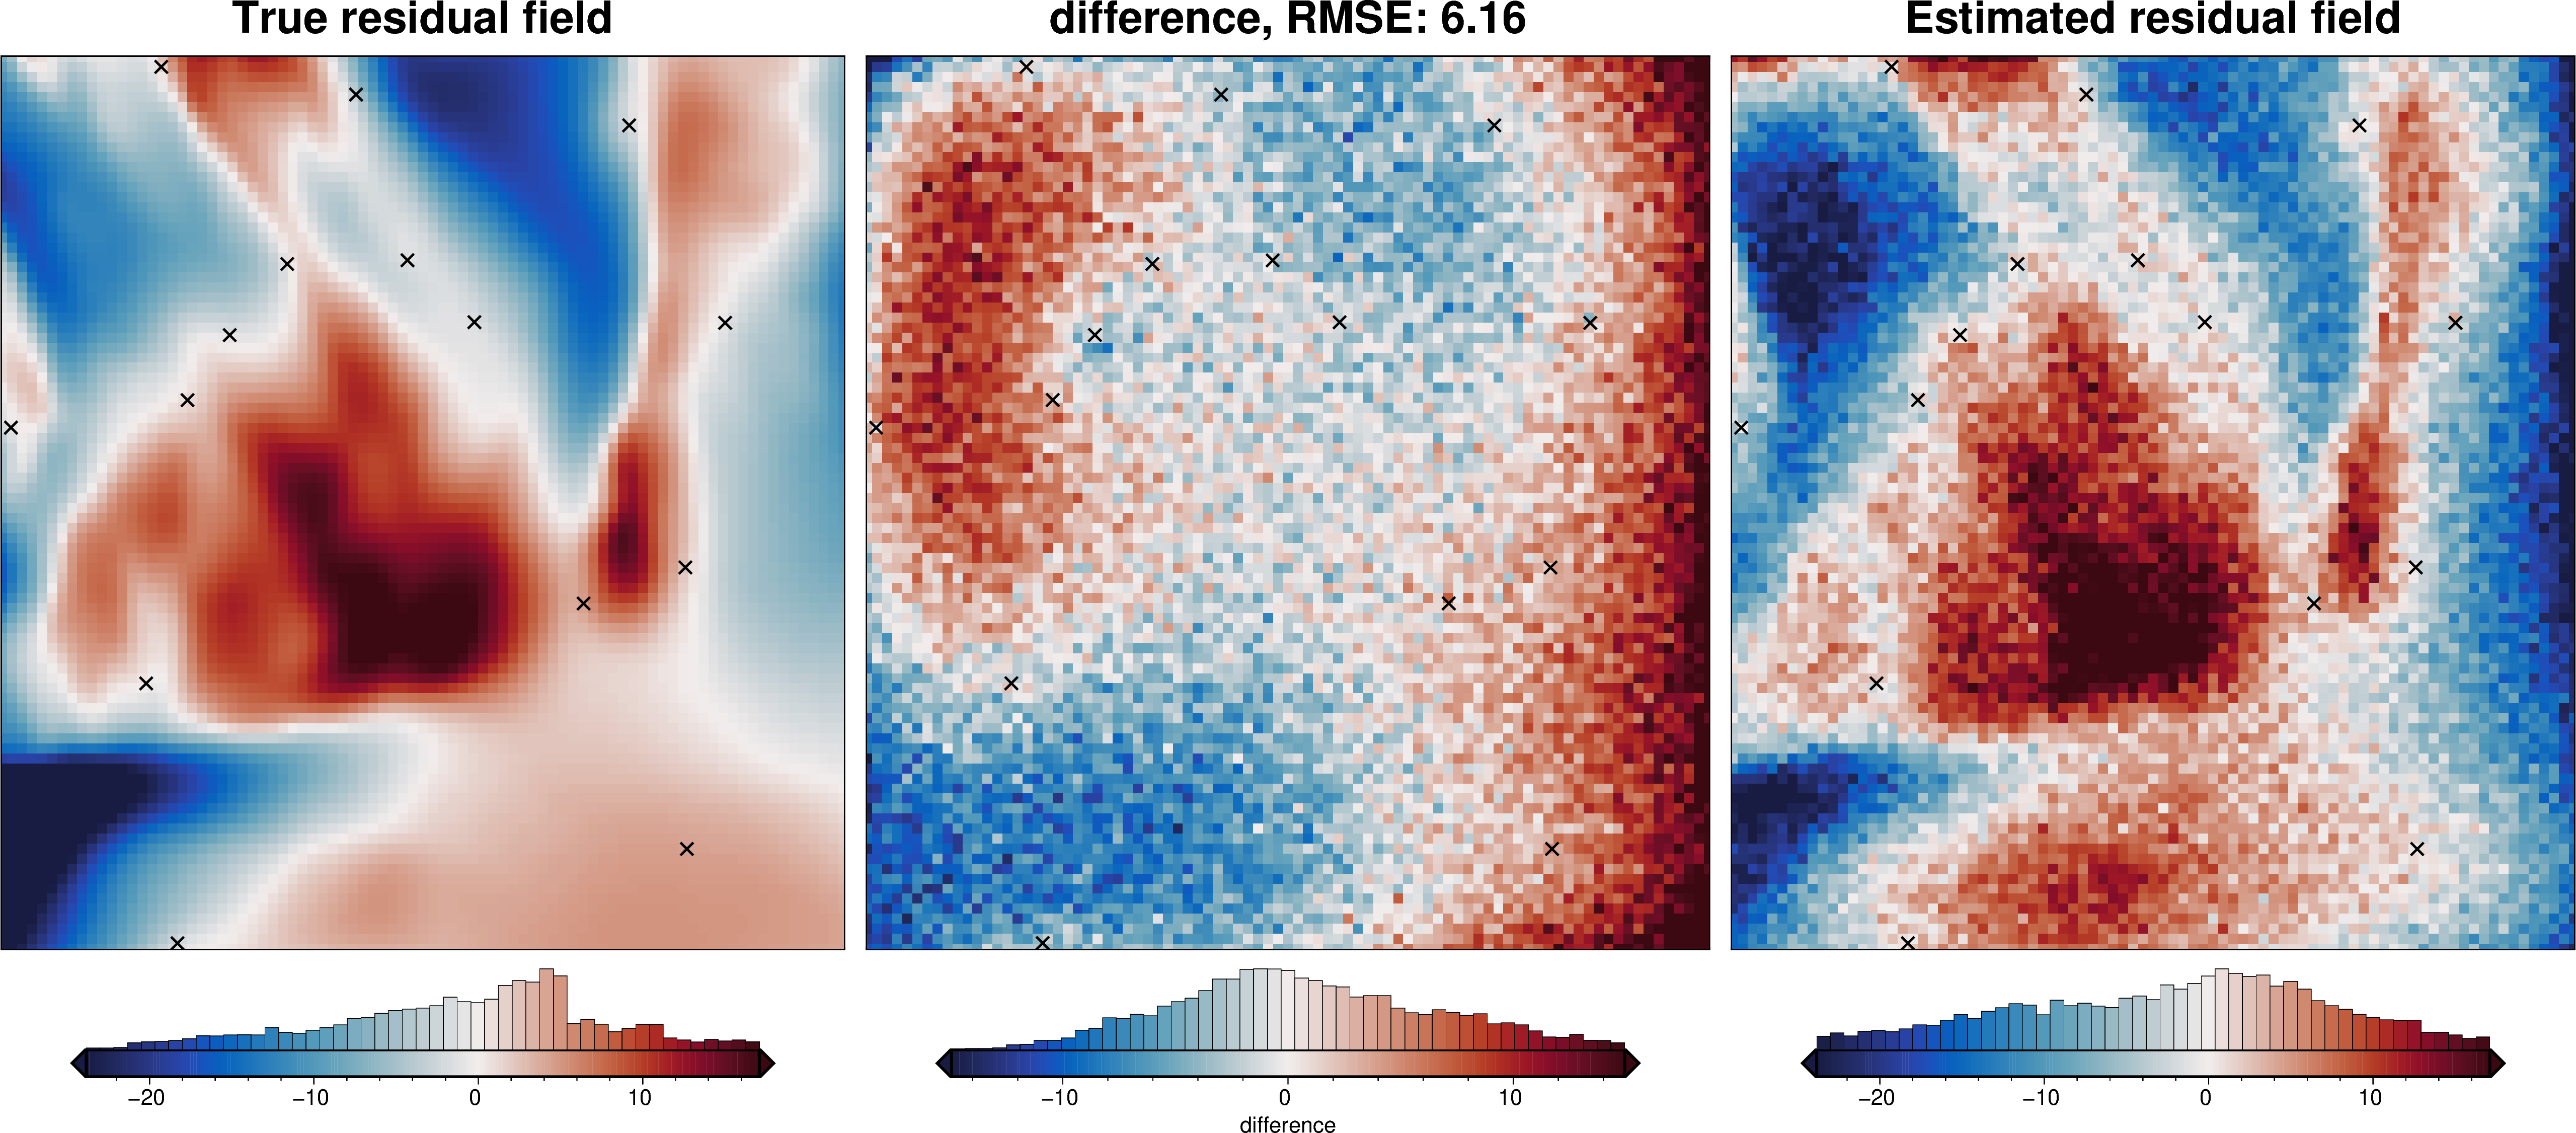

<xarray.Dataset> Size: 1MB
Dimensions:                   (northing: 90, easting: 85)
Coordinates:
  * easting                   (easting) float64 680B 2.39e+04 ... 3.599e+05
  * northing                  (northing) float64 720B 1.629e+05 ... 5.189e+05
Data variables: (12/24)
    upward                    (northing, easting) float64 61kB 1e+03 ... 1e+03
    basement_grav             (northing, easting) float64 61kB -2.757 ... -16.32
    moho_grav                 (northing, easting) float64 61kB 96.96 ... 114.7
    gravity_anomaly_no_noise  (northing, easting) float64 61kB 94.2 ... 98.37
    gravity_anomaly           (northing, easting) float64 61kB 94.46 ... 98.23
    uncert                    (northing, easting) float64 61kB 2.0 2.0 ... 2.0
    ...                        ...
    trend_reg                 (northing, easting) float64 61kB 66.73 ... 126.8
    trend_res                 (northing, easting) float64 61kB 4.086 ... -18.44
    eq_sources_reg            (northing, easting) float64 61kB 69.67 ... 123.8
    eq_sources_res            (northing, easting) float64 61kB 1.14 ... -15.4
    constraints_pygmt_reg     (northing, easting) float32 31kB 86.34 ... 133.7
    constraints_pygmt_res     (northing, easting) float64 61kB -15.52 ... -25.32
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data

In [27]:
# estimate regional with the constraints method
data = invert4geom.regional_constraints(
    grav_ds=data,
    constraints_df=constraint_points,
    grid_method="pygmt",
    tension_factor=0.3,
)
data["constraints_pygmt_reg"] = data.reg
data["constraints_pygmt_res"] = data.res

regional_comparison(data, "constraints_pygmt_reg")

data  # .inv.df.describe()

#### gridding with Verde and biharmonic splines

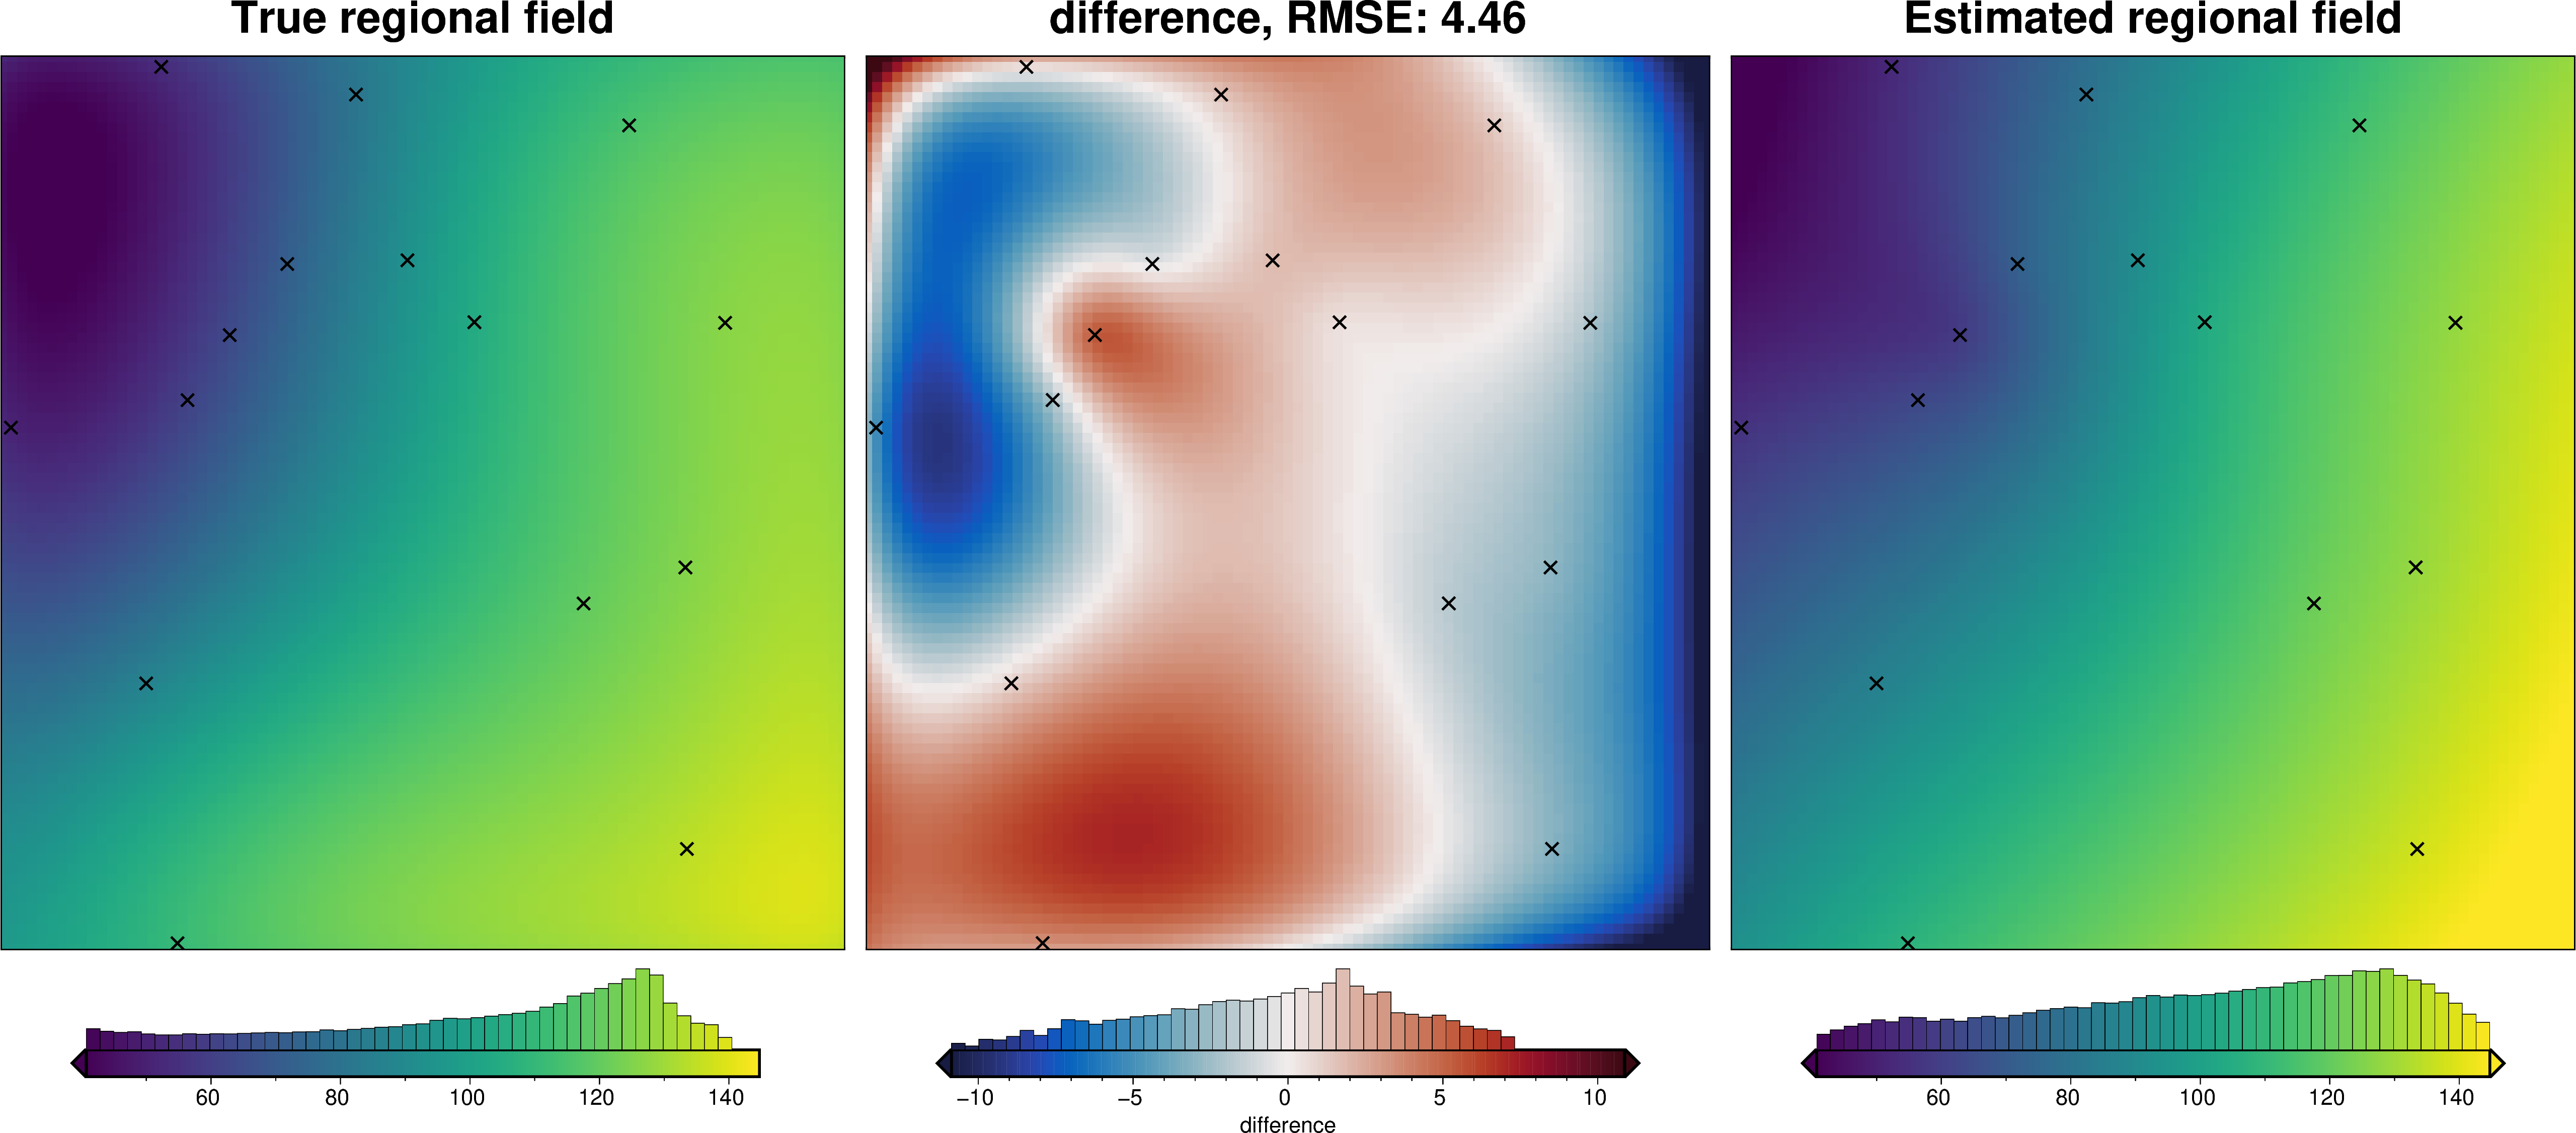

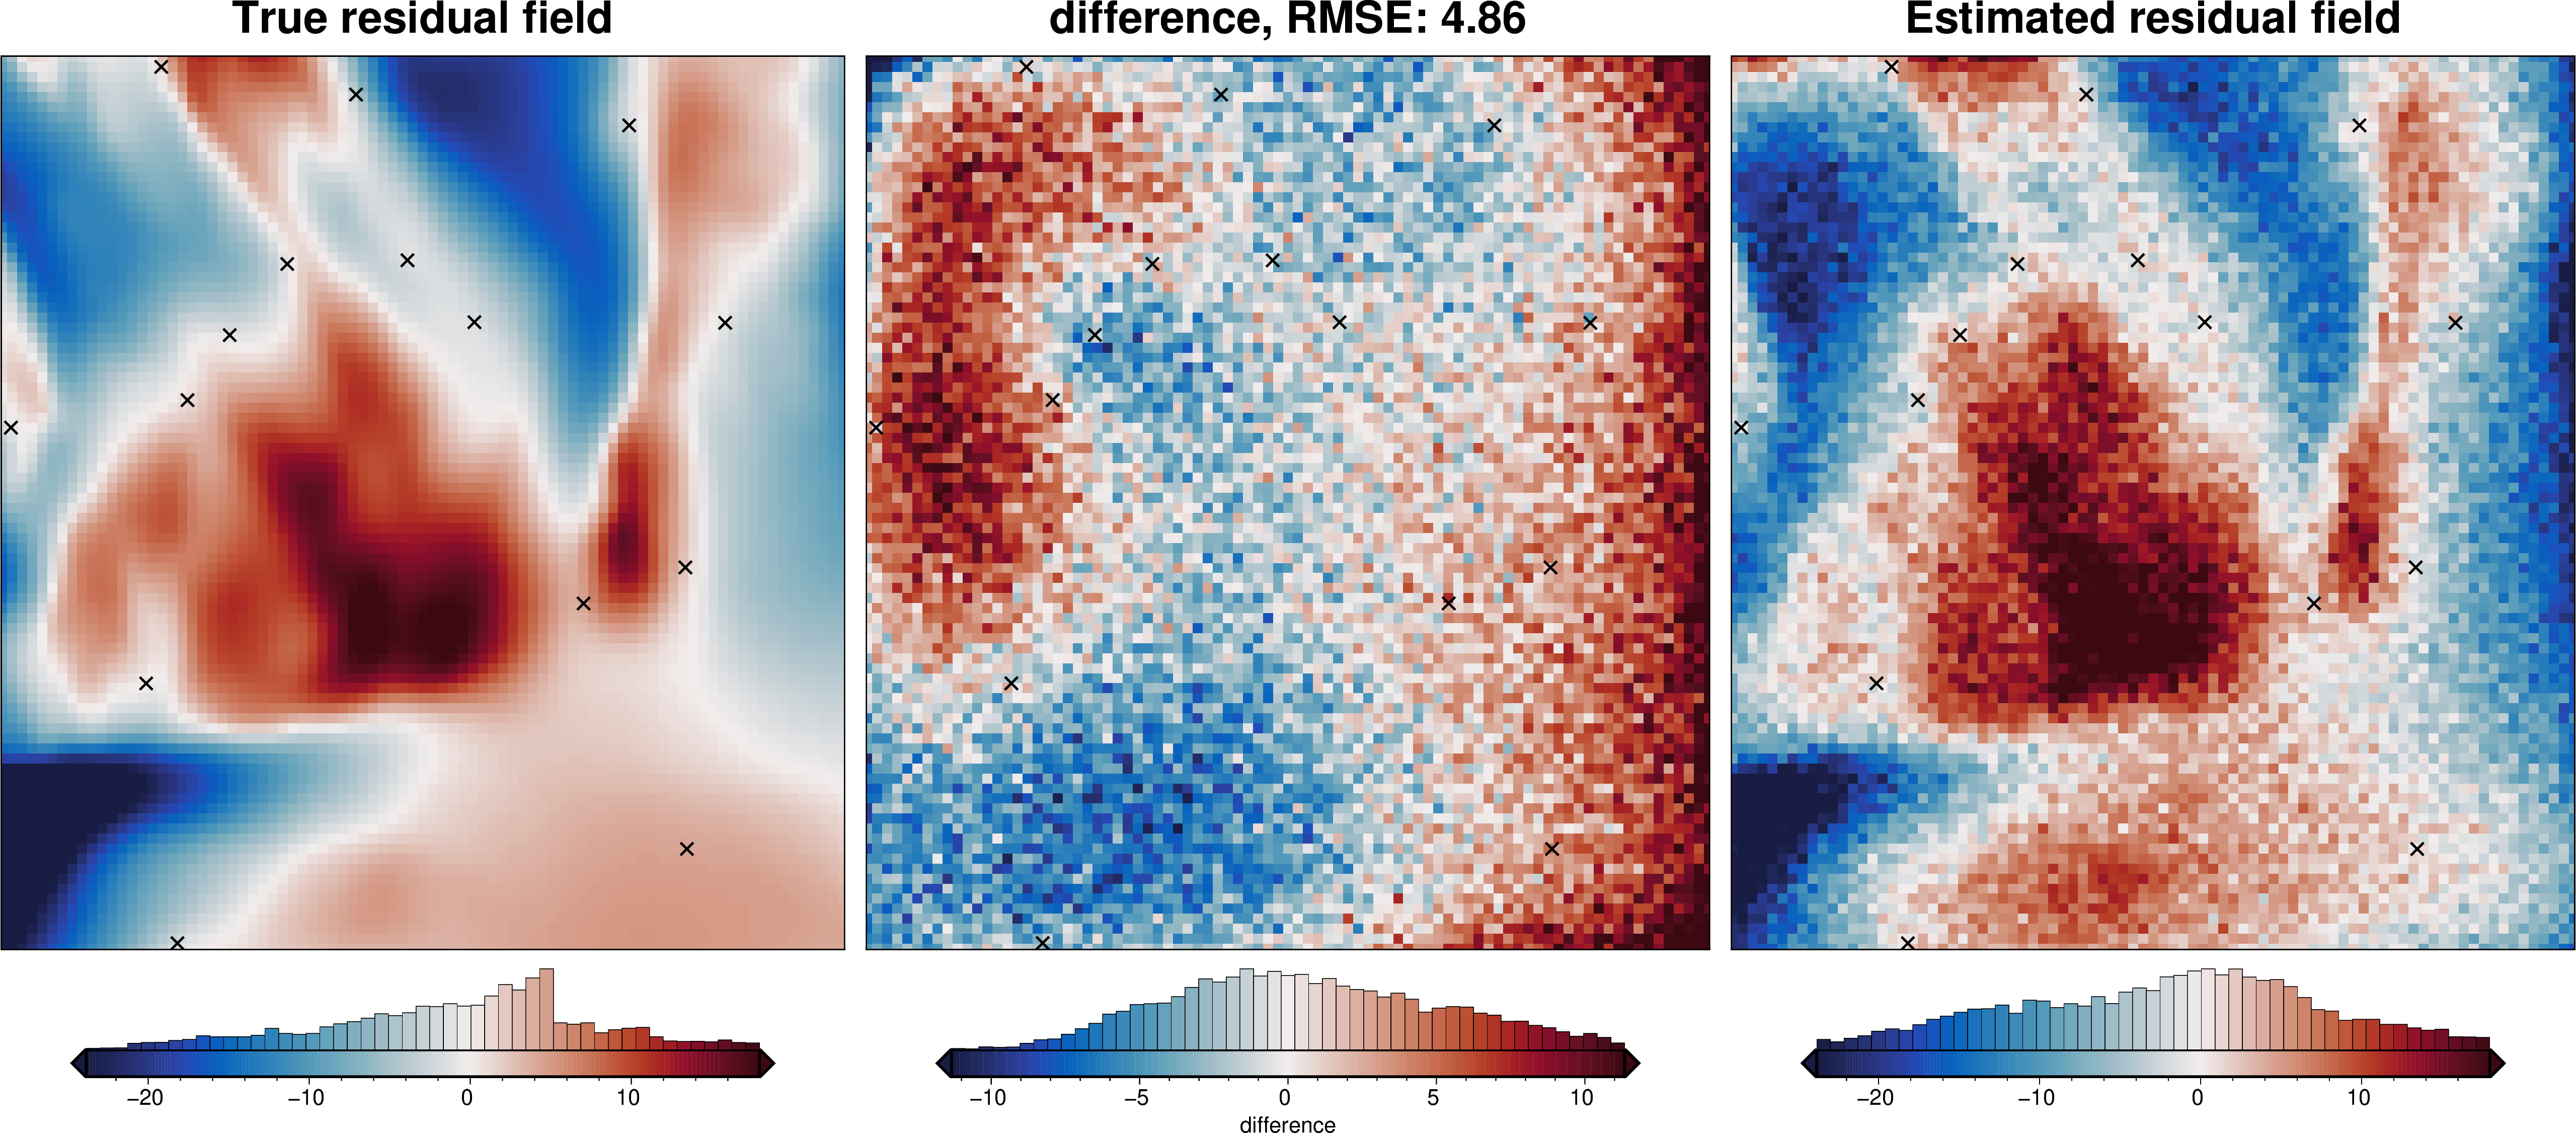

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

       gravity_anomaly_no_noise  gravity_anomaly  uncert  starting_gravity  \
count               7650.000000      7650.000000  7650.0       7650.000000   
mean                 101.157271       101.157271     2.0          1.548577   
std                    9.703771         9.919851     0.0         24.926461   
min                   75.617509        70.861220     2.0        -36.414267   
25%                   96.218487        96.092524     2.0        -17.408451   
50%                  102.149812       102.057202     2.0         -3.040309   
75%                  106.787344       107.006336     2.0         19.823536   
max                  126.329916       129.736453     2.0         59.698559   

       forward_gravity  ...   filter_reg   filter_res    trend_reg  \
count      7650.000000  ...  7650.000000  7650.000000  7650.000000   
mean          1.548577  ...    99.829289   -99.829289    99.608694   
std          24.926461  ...    27.063857     5.642272    29.768297   
min         -36.414267  ...    36.812193  -122.133212    16.420129   
25%         -17.408451  ...    79.328207  -102.895648    78.401816   
50%          -3.040309  ...   107.365011   -99.086918   106.923096   
75%          19.823536  ...   121.943848   -96.012109   123.773507   
max          59.698559  ...   137.738630   -84.125432   138.964569   

          trend_res  eq_sources_reg  eq_sources_res  constraints_pygmt_reg  \
count  7.650000e+03     7650.000000     7650.000000            7650.000000   
mean  -7.513734e-13       99.529885        0.078809             101.843475   
std    7.005950e+00       29.887298        5.608333              28.443087   
min   -2.015606e+01       22.406783      -18.294135              33.253517   
25%   -5.089756e+00       77.708304       -3.555612              80.630211   
50%   -3.247819e-02      108.694621        0.084550             105.069168   
75%    5.122518e+00      123.546778        3.731717             125.050148   
max    3.065616e+01      146.611638       22.281547             159.096756   

       constraints_pygmt_res  constraints_verde_reg  constraints_verde_res  
count            7650.000000            7650.000000            7650.000000  
mean               -2.234777             101.688063              -2.079369  
std                10.085719              28.039639              10.010793  
min               -30.545652              34.975867             -34.421193  
25%                -9.449601              81.053890              -9.317515  
50%                -1.090657             106.005007              -1.220205  
75%                 4.841547             124.994716               4.661532  
max                24.801272             153.796027              25.245437  

[8 rows x 28 columns]

In [28]:
# estimate regional with the constraints method
data = invert4geom.regional_constraints(
    grav_ds=data,
    constraints_df=constraint_points,
    grid_method="verde",
    spline_dampings=np.logspace(-20, 0, 10),
)
data["constraints_verde_reg"] = data.reg
data["constraints_verde_res"] = data.res

regional_comparison(data, "constraints_verde_reg")

data.inv.df.describe()

#### gridding with Equivalent sources

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

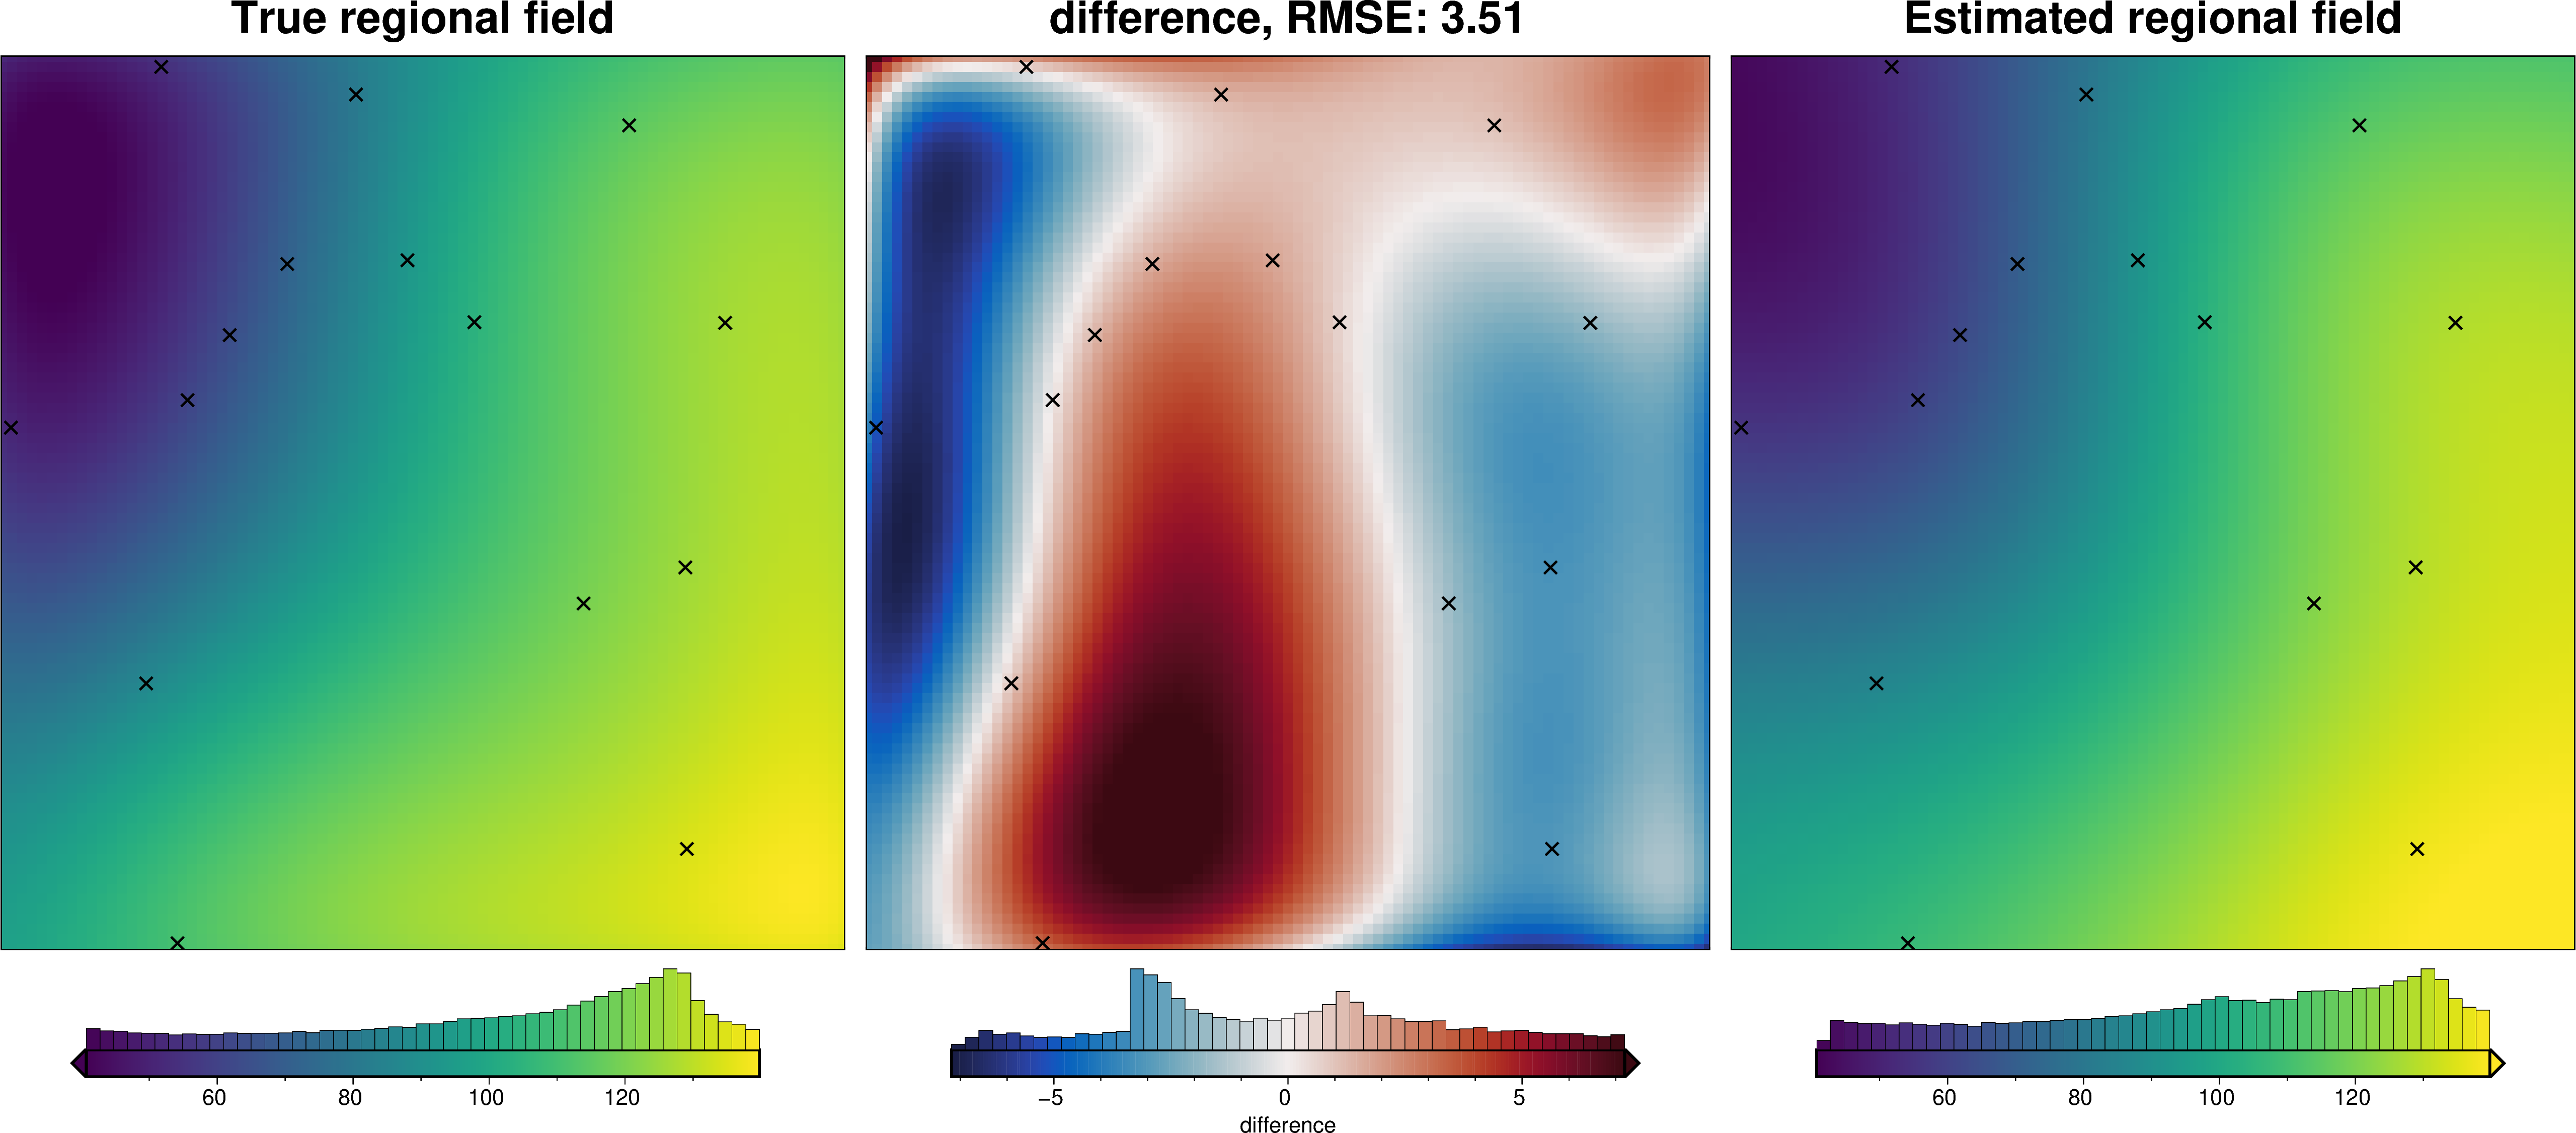

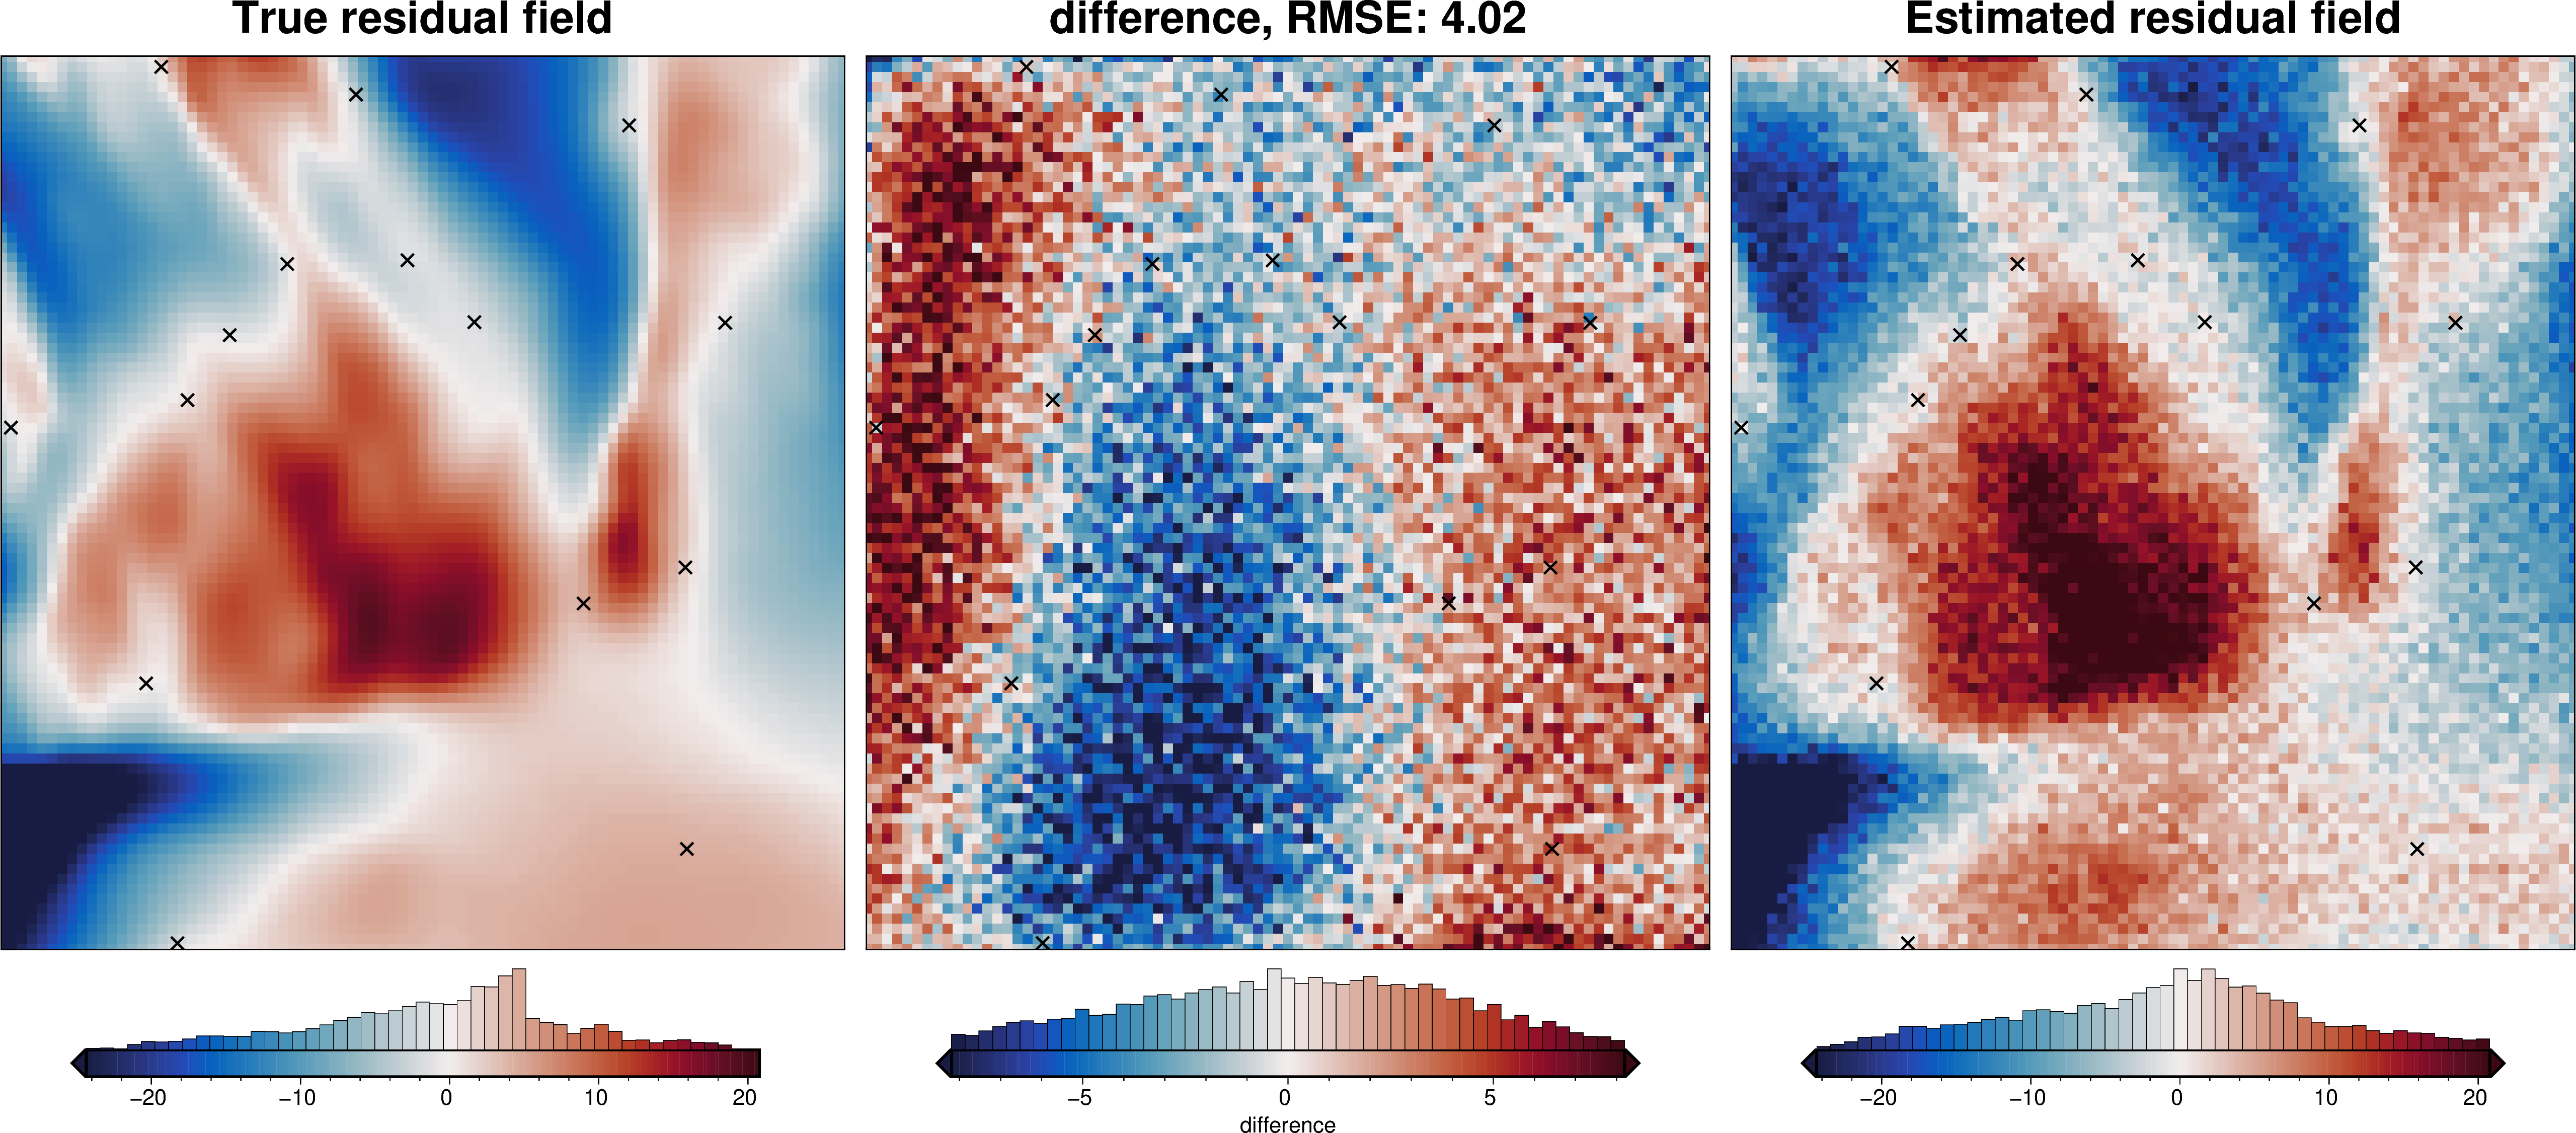

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

       gravity_anomaly_no_noise  gravity_anomaly  uncert  starting_gravity  \
count               7650.000000      7650.000000  7650.0       7650.000000   
mean                 101.157271       101.157271     2.0          1.548577   
std                    9.703771         9.919851     0.0         24.926461   
min                   75.617509        70.861220     2.0        -36.414267   
25%                   96.218487        96.092524     2.0        -17.408451   
50%                  102.149812       102.057202     2.0         -3.040309   
75%                  106.787344       107.006336     2.0         19.823536   
max                  126.329916       129.736453     2.0         59.698559   

       forward_gravity  ...    trend_reg     trend_res  eq_sources_reg  \
count      7650.000000  ...  7650.000000  7.650000e+03     7650.000000   
mean          1.548577  ...    99.608694 -7.513734e-13       99.529885   
std          24.926461  ...    29.768297  7.005950e+00       29.887298   
min         -36.414267  ...    16.420129 -2.015606e+01       22.406783   
25%         -17.408451  ...    78.401816 -5.089756e+00       77.708304   
50%          -3.040309  ...   106.923096 -3.247819e-02      108.694621   
75%          19.823536  ...   123.773507  5.122518e+00      123.546778   
max          59.698559  ...   138.964569  3.065616e+01      146.611638   

       eq_sources_res  constraints_pygmt_reg  constraints_pygmt_res  \
count     7650.000000            7650.000000            7650.000000   
mean         0.078809             101.843475              -2.234777   
std          5.608333              28.443087              10.085719   
min        -18.294135              33.253517             -30.545652   
25%         -3.555612              80.630211              -9.449601   
50%          0.084550             105.069168              -1.090657   
75%          3.731717             125.050148               4.841547   
max         22.281547             159.096756              24.801272   

       constraints_verde_reg  constraints_verde_res  constraints_eqs_reg  \
count            7650.000000            7650.000000          7650.000000   
mean              101.688063              -2.079369           100.848926   
std                28.039639              10.010793            27.314795   
min                34.975867             -34.421193            42.105334   
25%                81.053890              -9.317515            80.728987   
50%               106.005007              -1.220205           105.739066   
75%               124.994716               4.661532           124.163119   
max               153.796027              25.245437           141.669816   

       constraints_eqs_res  
count          7650.000000  
mean             -1.240232  
std              10.822622  
min             -43.374590  
25%              -8.159128  
50%              -0.260960  
75%               5.395736  
max              28.063082  

[8 rows x 30 columns]

In [29]:
# estimate regional with the constraints method
data = invert4geom.regional_constraints(
    grav_ds=data,
    constraints_df=constraint_points,
    grid_method="eq_sources",
    # either automatically determine best damping
    cv=True,
    cv_kwargs=dict(
        n_trials=20,
        damping_limits=(1e-20, 1e3),
        fname="../tmp/tmp",
    ),
    # or provide a value
    # damping=1e-15,
    depth="default",
    block_size=None,
)
data["constraints_eqs_reg"] = data.reg
data["constraints_eqs_res"] = data.res

regional_comparison(data, "constraints_eqs_reg")

data.inv.df.describe()

We can also use the class method `regional_separation()` and pass through the `method` and keyword args, combining all the above functions into one.

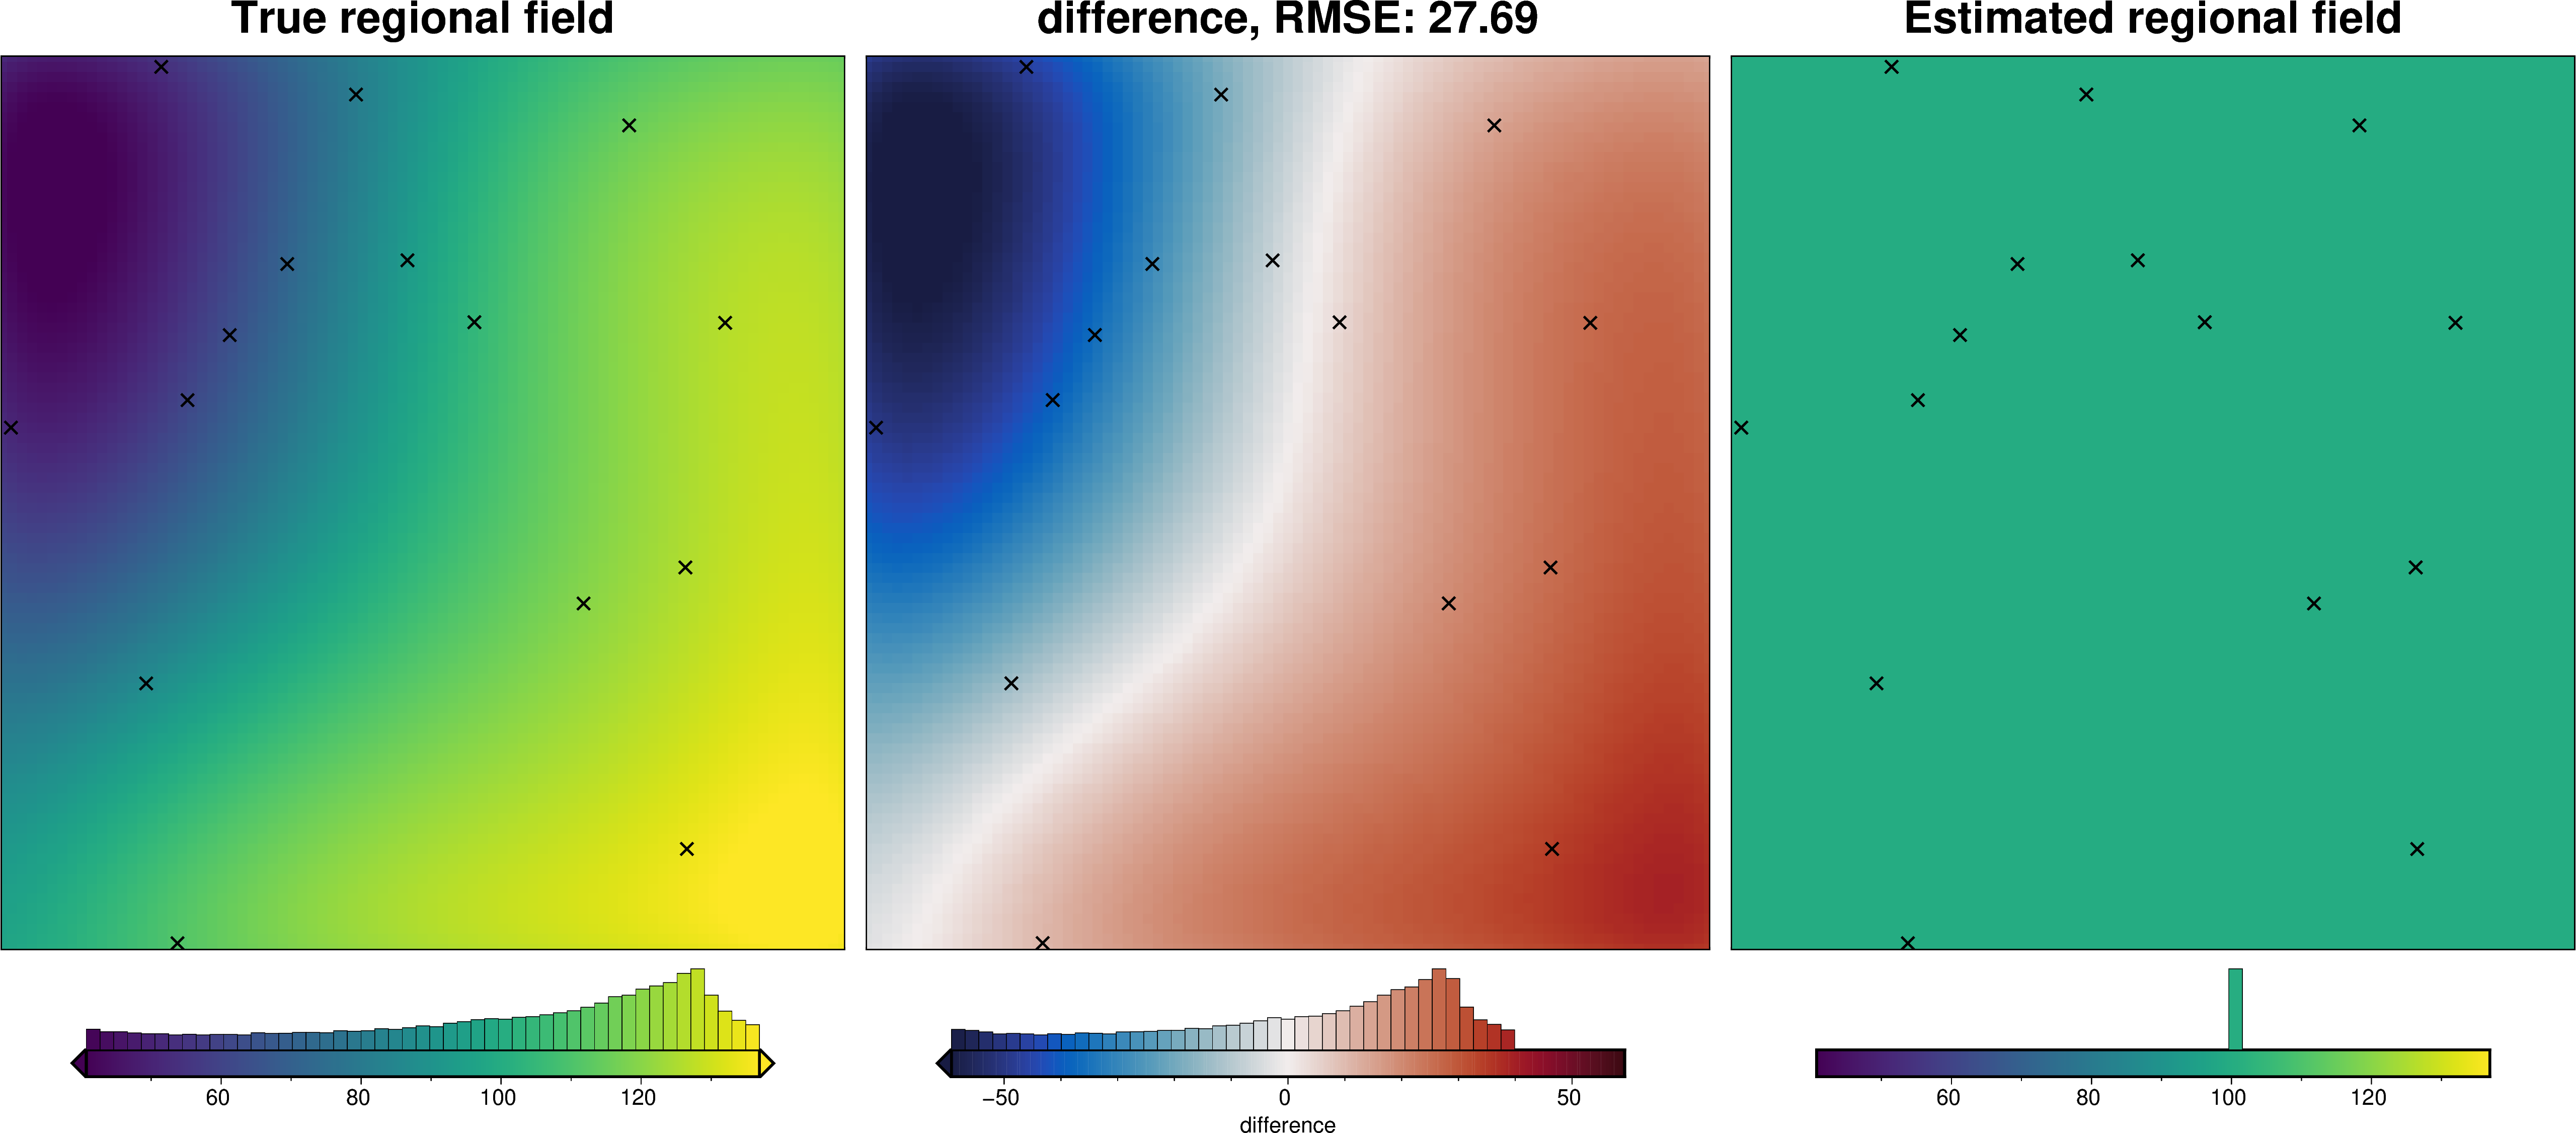

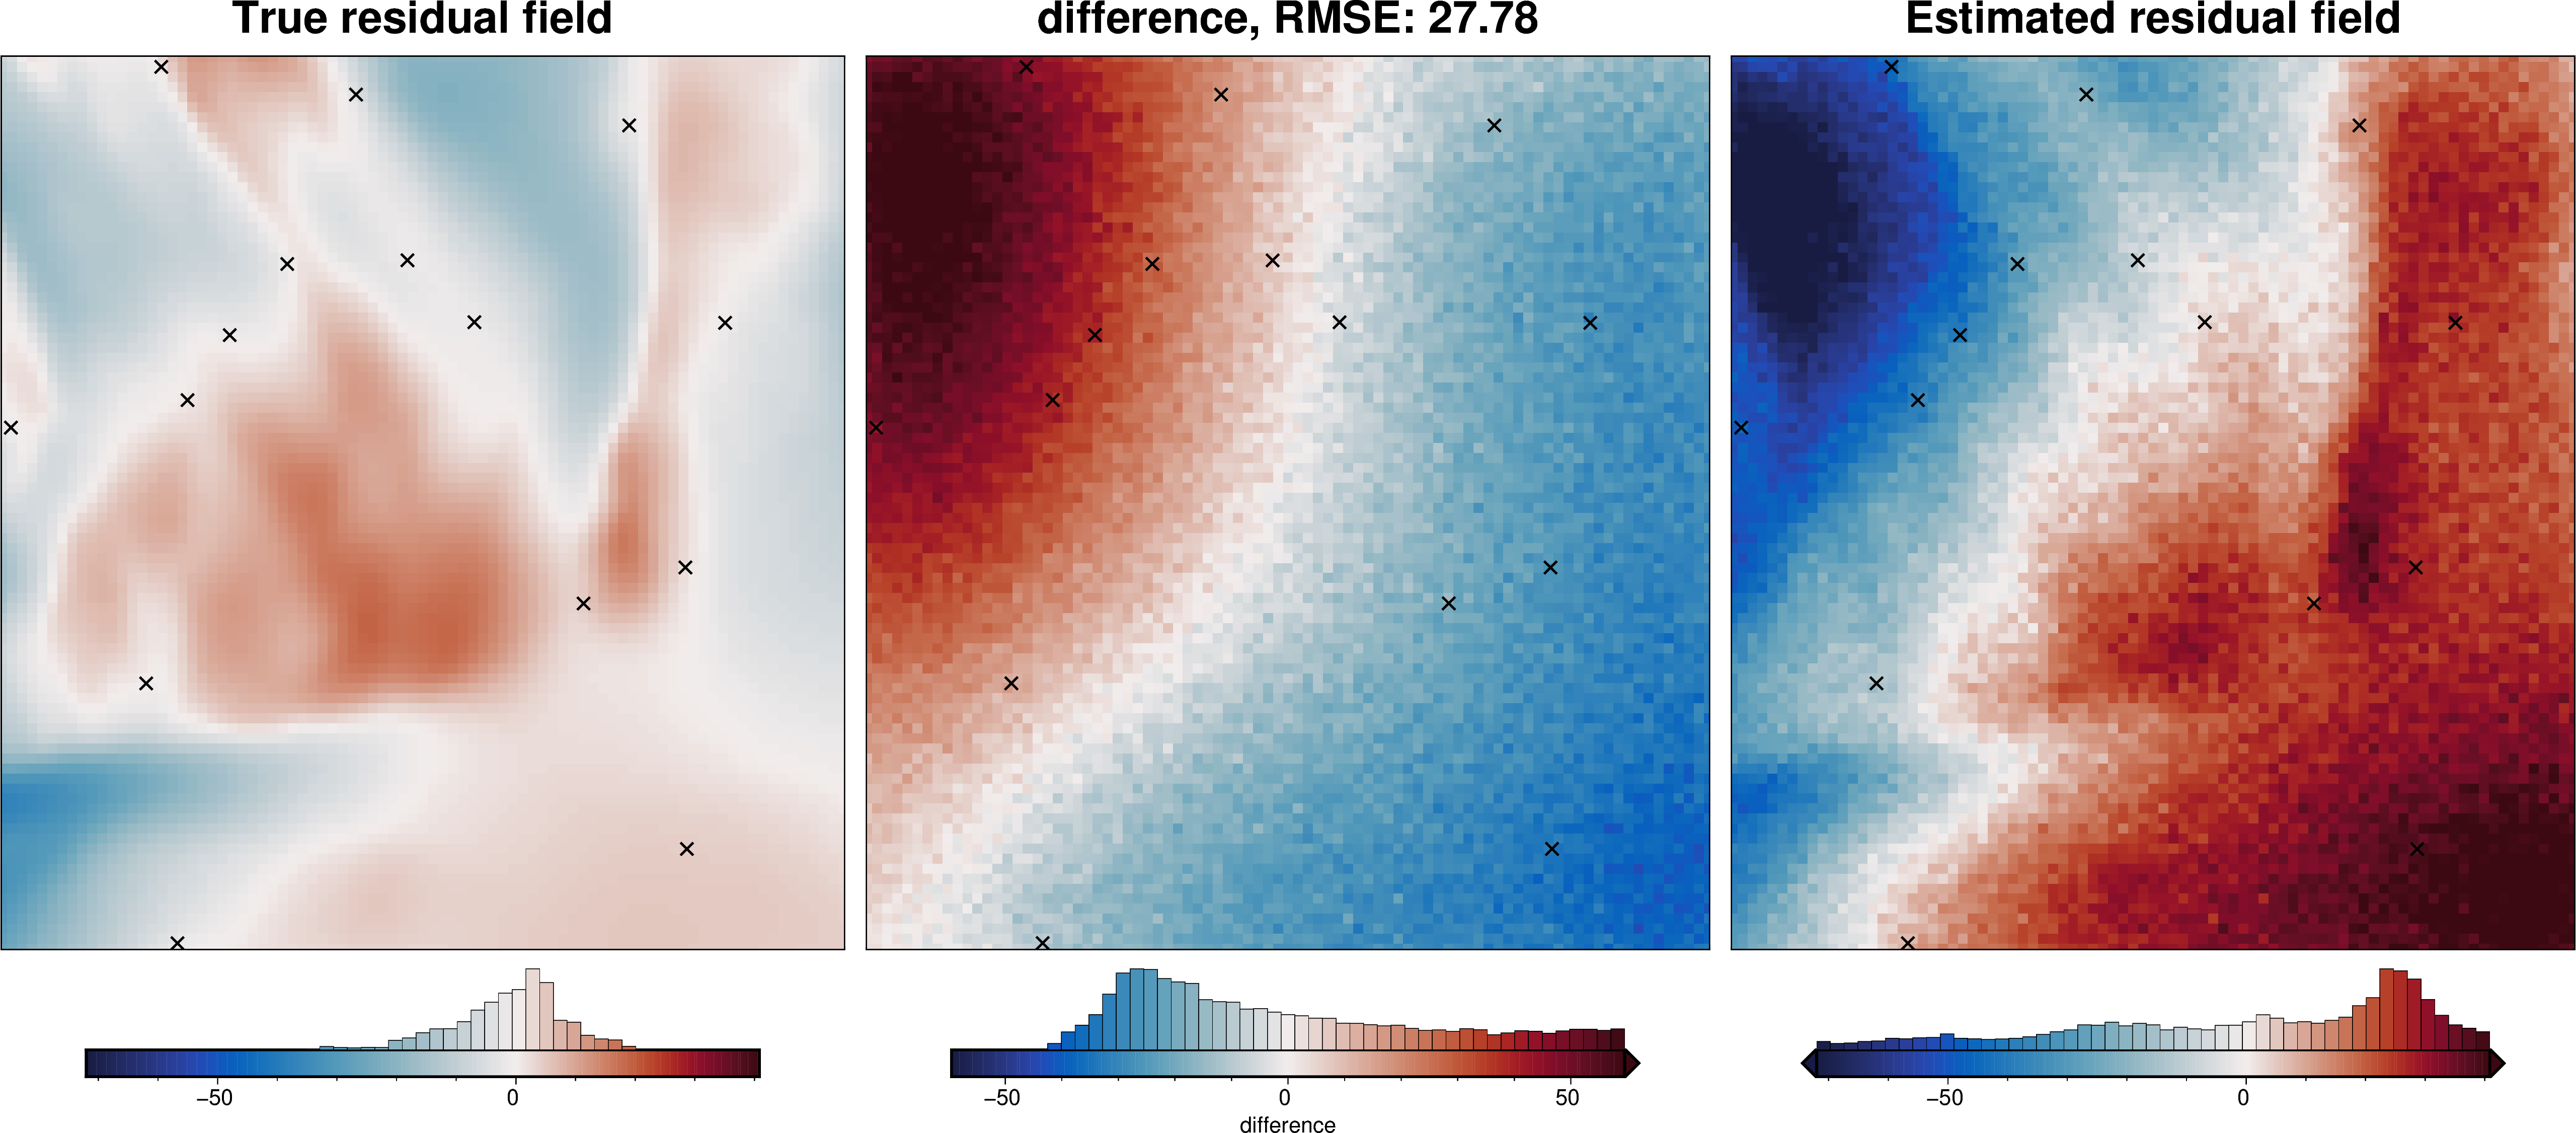

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

       gravity_anomaly_no_noise  gravity_anomaly  uncert  starting_gravity  \
count               7650.000000      7650.000000  7650.0       7650.000000   
mean                 101.157271       101.157271     2.0          1.548577   
std                    9.703771         9.919851     0.0         24.926461   
min                   75.617509        70.861220     2.0        -36.414267   
25%                   96.218487        96.092524     2.0        -17.408451   
50%                  102.149812       102.057202     2.0         -3.040309   
75%                  106.787344       107.006336     2.0         19.823536   
max                  126.329916       129.736453     2.0         59.698559   

       forward_gravity  ...  eq_sources_res  constraints_pygmt_reg  \
count      7650.000000  ...     7650.000000            7650.000000   
mean          1.548577  ...        0.078809             101.843475   
std          24.926461  ...        5.608333              28.443087   
min         -36.414267  ...      -18.294135              33.253517   
25%         -17.408451  ...       -3.555612              80.630211   
50%          -3.040309  ...        0.084550             105.069168   
75%          19.823536  ...        3.731717             125.050148   
max          59.698559  ...       22.281547             159.096756   

       constraints_pygmt_res  constraints_verde_reg  constraints_verde_res  \
count            7650.000000            7650.000000            7650.000000   
mean               -2.234777             101.688063              -2.079369   
std                10.085719              28.039639              10.010793   
min               -30.545652              34.975867             -34.421193   
25%                -9.449601              81.053890              -9.317515   
50%                -1.090657             106.005007              -1.220205   
75%                 4.841547             124.994716               4.661532   
max                24.801272             153.796027              25.245437   

       constraints_eqs_reg  constraints_eqs_res  starting_misfit  \
count          7650.000000          7650.000000      7650.000000   
mean            100.848926            -1.240232        99.608694   
std              27.314795            10.822622        30.581609   
min              42.105334           -43.374590        17.942842   
25%              80.728987            -8.159128        78.143138   
50%             105.739066            -0.260960       107.150139   
75%             124.163119             5.395736       124.912841   
max             141.669816            28.063082       148.090389   

       starting_reg  starting_res  
count        7650.0   7650.000000  
mean          100.0     -0.391306  
std             0.0     30.581609  
min           100.0    -82.057158  
25%           100.0    -21.856862  
50%           100.0      7.150139  
75%           100.0     24.912841  
max           100.0     48.090389  

[8 rows x 33 columns]

In [32]:
# estimate regional with the mean misfit at constraints
data = data.inv.regional_separation(
    method="constant",
    # constraints_df=constraint_points,
    constant=100,
)

regional_comparison(data, "reg")

data.inv.df.describe()

Above we just picked these hyperparameter values arbitrarily. The next [user guide](regional_field_hyperparameters.ipynb) shows a more informed technique for choosing each of these hyperparameter values.